# OpenSearch with Atom

This notebook explains the use of the OpenSearch interface with Atom response format to access collection and granule metadata according to the two-step mechanism recommended by CEOS Best Practices [[RD1]](#RD1).

## Overview  
 The subjects covered in this notebook are:    
 * [Colllection Search](#collection-search) 
   * [Access API Description](#access-api-description)
   * [Search by free text](#search-by-free-text)
   * [Search by title](#search-by-title)
   * [Search by free text](#search-by-platform)
   * [Search by instrument](#search-by-instrument)
   * [Search by organisation](#search-by-organisation)
   * [Search by identifier](#search-by-identifier)
   * [Search by concept](#search-by-concept)
 * [Colllection Properties](#collection-properties) 
   * [Collection geometry](#collection-geometry) 
   * [Collection temporal extent](#collection-temporal-extent) 
   * [Collection identifier](#collection-identifier) 
   * [Collection keywords](#collection-keywords) 
   * [Collection other representations](#collection-other-representations) 
   * [Collection embedding other formats](#collection-embedding-other-formats) 
   * [Collection related documentation](#collection-related-documentation) 
 * [Granule Search](#granule-search) 
   * [Access API Description](#granule-access-api-description)
   * [Search by bounding box](#granule-search-by-bounding-box)
   * [Search by geometry](#granule-search-by-geometry)
   * [Search by temporal extent](#granule-search-by-temporal-extent)
   * [Search by identifier](#granule-search-by-identifier)
 * [Granule Properties](#granule-properties) 
   * [Geometry](#geometry) 
   * [Temporal extent](#temporal-extent) 
   * [Granule identifier](#granule-identifier) 
   * [Quicklook](#quicklook)
   * [Granule download](#granule-download)
   * [Other representations](#other-representations) 
   * [Embedding other formats](#embedding-other-formats) 
 * [Advanced Topics](#advanced-topics)
   * [Result paging](#result-paging)
   * [Sorting results](#sorting-results)
   * [Faceted search](#faceted-search)
   * [Content negotiation](#content-negotiation)
 * [Further Reading](#further-reading) 

In [200]:
#:tags: [remove-cell]
import json, requests, xml
import pandas as pd
from xml.dom import minidom
from IPython.display import Image

from xml.etree import ElementTree
import ipywidgets as widgets

from IPython.display import HTML
from IPython.display import Markdown as md

import re

# %pip install ipyleaflet
from ipyleaflet import (Map, GeoData, basemaps, WidgetControl, GeoJSON, Polygon,
   LayersControl, Icon, Marker, basemap_to_tiles, Choropleth,
   MarkerCluster, Heatmap, SearchControl, 
   FullScreenControl)

# from lxml import etree

# Select the top-level OSDD from which the user will be able to choose.
url_osdd_choices = [ 
    'https://eocat.esa.int' + '/opensearch/description.xml' ,
    'https://fedeo.ceos.org' + '/opensearch/description.xml' ,
    'https://eovoc.spacebel.be' + '/api?httpAccept=application%2Fopensearchdescription%2Bxml' ,  # original
   # 'https://eovoc.spacebel.be' + '/api?httpAccept=application/opensearchdescription+xml' ,
   # 'https://eovoc.spacebel.be' + '/api' ,
    
    'https://geo.spacebel.be' + '/opensearch/description.xml' ]

url_explain_choices = [ 
    'https://eocat.esa.int' + '/opensearch/request' ,
    'https://fedeo.ceos.org' + '/opensearch/request' ,
    'https://eovoc.spacebel.be' + '/api?httpAccept=application/sru%2Bxml' ,
    'https://geo.spacebel.be' + '/opensearch/request' ]


# url_explain = 'https://fedeo.ceos.org' + '/opensearch/request'
# url_explain = 'https://eovoc.spacebel.be' + '/api?httpAccept=application/sru%2Bxml'

# Verification of SSL certificate is to be set to False for the eocat endpoint to work.
# verify_ssl = False
verify_ssl = False

In [201]:
#:tags: [remove-cell]
def load_dataframe( resp ):
  
  df = pd.DataFrame(columns=['dc:identifier', 'atom:title', 'atom:updated', 'atom:link[rel="search"]', 'atom:link[rel="enclosure"]', 'atom:link[rel="icon"]'])

  rt = ElementTree.fromstring(response.text)
  for r in rt.findall('{http://www.w3.org/2005/Atom}entry'):
     name = r.find('{http://purl.org/dc/elements/1.1/}identifier').text
     title = r.find('{http://www.w3.org/2005/Atom}title').text
     updated = r.find('{http://www.w3.org/2005/Atom}updated').text
     dcdate = r.find('{http://purl.org/dc/elements/1.1/}date').text
     # print('collection',count,'-', name, ':')
     # print('\tidentifier: ',name)
     
     try:
         href = r.find('{http://www.w3.org/2005/Atom}link[@rel="search"][@type="application/opensearchdescription+xml"]').attrib['href']
     except AttributeError:
         href= ''

     try:
         rel_enclosure = r.find('{http://www.w3.org/2005/Atom}link[@rel="enclosure"]').attrib['href']
     except AttributeError:
         rel_enclosure= ''

     try:
         rel_icon = r.find('{http://www.w3.org/2005/Atom}link[@rel="icon"]').attrib['href']
     except AttributeError:
         rel_icon= ''

     # append a row to the df 
     new_row = { 'dc:identifier': name, 'atom:title': title, 'dc:date': dcdate, 'atom:updated': updated, 'atom:link[rel="search"]': href, 
        'atom:link[rel="enclosure"]': rel_enclosure , 'atom:link[rel="icon"]': rel_icon}
     df = df.append(new_row, ignore_index=True)

  return df

def load_facet( root, facet ):
  # create dataframe with information about 'facet' found in XML tree with 'root".
  ns = {'sru': 'http://a9.com/-/opensearch/extensions/sru/2.0/'}
  el = root.find('.//sru:facet[sru:index="' + facet + '"]', ns)
  
  df = pd.DataFrame(columns=['name', 'count'])

  for r in el.findall('.//sru:term', ns):
     name = r.find('sru:actualTerm', ns).text
     count = r.find('sru:count', ns).text
    
     # append a row to the df 
     new_row = { 'name': name, 'count': int(count) }
     df = df.append(new_row, ignore_index=True)

  df.set_index('name', inplace=True)
  return df


def show_features_on_map( georss_box, georss_polygon ):
  # display map showing the 'polygon' and use center of 'box' to center the map.
  list1 = georss_polygon.split()
  list2 = georss_box.split()
      
  points = []    
  for i in range(0,len(list1),2):
      # print (list2[i], list2[i+1])
      points = points + [ (float(list1[i]), float(list1[i+1])) ]
      
  # use center of the bounding box.
  try:
         center = [ (float(list2[0])+float(list2[2]))/2.0 , (float(list2[1])+float(list2[3]))/2.0 ]  
  except:
         # default center and zoom factor for an empty map
         center = [50.85, 4.3488]
         zoom = 3
         
  m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center)
  polygon = Polygon(locations=points, color="green", fill_color="green")
  m.add_layer(polygon)
  m.add_control(FullScreenControl())
  m.add_control(LayersControl(position='topright'))
  
  return m


In [202]:
#:tags: [remove-cell]

import re;

def get_api_request(template, os_querystring):
  # Fill (URL) template with OpenSearch parameter values provided in os_querystring and return as short HTTP URL without empty parameters.
  
  print("URL template: " + template)
      
  # perform substitutions in template
  for p in os_querystring:
      print("  .. replacing:", p, "by", os_querystring[p])
      template = re.sub('\{'+p+'.*?\}', os_querystring[p] , template)
      # print("- intermediate new template:" + template)
      
  # remove empty search parameters
  template=re.sub('&?[a-zA-Z]*=\{.*?\}', '' , template)
  # print("- Shorter template step 1: " + template)
  
  # remove remaining empty search parameters which did not have an HTTP query parameter attached (e.g. time:end).
  template=re.sub('\{.*?\}', '' , template)
  
  print("API request: " + template)
  # md("API request: " + template)
            
  return (template)


The Notebook can be used with a number of different endpoints.  Change the OSDD to be used for collection search by executing the notebook. 

In [203]:
#:tags: [remove-cell]
list = widgets.Dropdown(options=url_osdd_choices, description="Select OSDD", index=0)
list

Dropdown(description='Select OSDD', options=('https://eocat.esa.int/opensearch/description.xml', 'https://fede…

In [204]:
#:tags: [remove-input]
# Get the selected OSDD endpoint from the list.
url_osdd = list.value
# select the corresponding url_explain accoridng to the list selection
url_explain = url_explain_choices[list.index]

# remove next line
# url_osdd = url_osdd_choices[1]

url_osdd

'https://eocat.esa.int/opensearch/description.xml'

##  Collection Search

### Access API Description

In [205]:
#:tags: [remove-input]
md("The OpenSearch Description Document is accessible at the fixed location [{url}]({url}) and contains the URL template to be used for collection search.".format(url=url_osdd))

The OpenSearch Description Document is accessible at the fixed location [https://eocat.esa.int/opensearch/description.xml](https://eocat.esa.int/opensearch/description.xml) and contains the URL template to be used for collection search.

**Example: 2.1**  
>  Access the API Description in OpenSearch Description Document (OSDD) format.  


In [206]:
# response = requests.get(url_osdd, verify=bool(verify_ssl), headers={'Accept': 'application/opensearchdescription+xml'})
# above does not work for eovoc (from inside Spacebel)
response = requests.get(url_osdd, verify=bool(verify_ssl) )

xmlstr = minidom.parseString(response.text).toprettyxml(indent='  ',newl='')
md("```xml\n" + xmlstr + "\n```\n")


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


```xml
<?xml version="1.0" ?><OpenSearchDescription xmlns="http://a9.com/-/spec/opensearch/1.1/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:param="http://a9.com/-/spec/opensearch/extensions/parameters/1.0/" xmlns:semantic="http://a9.com/-/opensearch/extensions/semantic/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/">  
  <ShortName>ESA Catalog</ShortName>  
  <Description>Provides interoperable access, following ISO/OGC interface guidelines, to Earth Observation metadata.</Description>  
  <Tags>ESA, Earth Observation, Digital Repository, HMA, HMA-S, HMA-SE, CEOS-OS-BP-V1.1/L1.</Tags>  
  <Url rel="self" template="https://eocat.esa.int/opensearch/description.xml" type="application/opensearchdescription+xml"/>  
  <Url rel="search" template="https://eocat.esa.int/opensearch/description.xml?parentIdentifier={eo:parentIdentifier}" type="application/opensearchdescription+xml"/>  
  <Url indexOffset="1" pageOffset="1" rel="results" template="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier={eo:parentIdentifier}&amp;query={searchTerms?}&amp;startRecord={startIndex?}&amp;startPage={startPage?}&amp;maximumRecords={count?}&amp;startDate={time:start?}&amp;endDate={time:end?}&amp;bbox={geo:box?}&amp;name={geo:name?}&amp;lat={geo:lat?}&amp;lon={geo:lon?}&amp;radius={geo:radius?}&amp;uid={geo:uid?}&amp;recordSchema={sru:recordSchema?}" type="application/atom+xml">    
    <param:Parameter maxInclusive="50" minInclusive="0" name="maximumRecords" pattern="[0-9]+" value="{count}"/>    
    <param:Parameter minInclusive="1" name="startRecord" pattern="[0-9]+" value="{startIndex}"/>    
    <param:Parameter minInclusive="1" name="startPage" pattern="[0-9]+" value="{startPage}"/>    
    <param:Parameter name="startDate" pattern="^[0-9]{4}-[0-9]{2}-[0-9]{2}T[0-9]{2}:[0-9]{2}:[0-9]{2}(\.[0-9]+)?(Z|[\+\-][0-9]{2}:[0-9]{2})$" value="{time:start}"/>    
    <param:Parameter name="endDate" pattern="^[0-9]{4}-[0-9]{2}-[0-9]{2}T[0-9]{2}:[0-9]{2}:[0-9]{2}(\.[0-9]+)?(Z|[\+\-][0-9]{2}:[0-9]{2})$" value="{time:end}"/>    
    <param:Parameter maxInclusive="90" minInclusive="-90" name="lat" value="{geo:lat}"/>    
    <param:Parameter maxInclusive="180" minInclusive="-180" name="lon" value="{geo:lon}"/>    
    <param:Parameter name="recordSchema" value="{sru:recordSchema}">      
      <param:Option label="O&amp;M 1.1" value="om"/>      
      <param:Option label="O&amp;M 1.0" value="om10"/>      
      <param:Option label="server-choice" value="server-choice"/>      
    </param:Parameter>    
    <param:Parameter name="query" title="Textual search in the title, abstract or keyword section of the collection. Surround with double quotes for exact match." value="{searchTerms}"/>    
  </Url>  
  <Url indexOffset="1" pageOffset="1" rel="collection" template="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier={eo:parentIdentifier?}&amp;subject={dc:subject?}&amp;query={searchTerms?}&amp;startRecord={startIndex?}&amp;startPage={startPage?}&amp;maximumRecords={count?}&amp;startDate={time:start?}&amp;endDate={time:end?}&amp;type={dc:type?}&amp;title={dc:title?}&amp;publisher={dc:publisher?}&amp;bbox={geo:box?}&amp;name={geo:name?}&amp;lat={geo:lat?}&amp;lon={geo:lon?}&amp;radius={geo:radius?}&amp;uid={geo:uid?}&amp;geometry={geo:geometry?}&amp;organisationName={eo:organisationName?}&amp;platform={eo:platform?}&amp;instrument={eo:instrument?}&amp;processingLevel={eo:processingLevel?}&amp;useLimitation={eo:useLimitation?}&amp;otherConstraint={eo:otherConstraint?}&amp;classifiedAs={semantic:classifiedAs?}&amp;facetLimit={sru:facetLimit?}&amp;recordSchema={sru:recordSchema?}" type="application/atom+xml">    

    <param:Parameter name="type" value="{dc:type}">      
      <param:Option label="dataset series" value="collection"/>      
    </param:Parameter>    
    <param:Parameter name="parentIdentifier" value="{eo:parentIdentifier}">      
      <param:Option label="ESA:EARTH-ONLINE" value="EOP:ESA:EARTH-ONLINE"/>      
    </param:Parameter>    
    <param:Parameter maxInclusive="50" minInclusive="0" name="maximumRecords" pattern="[0-9]+" value="{count}"/>    
    <param:Parameter minInclusive="1" name="startRecord" pattern="[0-9]+" value="{startIndex}"/>    
    <param:Parameter minInclusive="1" name="startPage" pattern="[0-9]+" value="{startPage}"/>    
    <param:Parameter name="startDate" pattern="^[0-9]{4}-[0-9]{2}-[0-9]{2}T[0-9]{2}:[0-9]{2}:[0-9]{2}(\.[0-9]+)?(Z|[\+\-][0-9]{2}:[0-9]{2})$" value="{time:start}"/>    
    <param:Parameter name="endDate" pattern="^[0-9]{4}-[0-9]{2}-[0-9]{2}T[0-9]{2}:[0-9]{2}:[0-9]{2}(\.[0-9]+)?(Z|[\+\-][0-9]{2}:[0-9]{2})$" value="{time:end}"/>    
    <param:Parameter maxInclusive="90" minInclusive="-90" name="lat" value="{geo:lat}"/>    
    <param:Parameter maxInclusive="180" minInclusive="-180" name="lon" value="{geo:lon}"/>    
    <param:Parameter name="platform" pattern="[a-z|A-Z|1-9|\-|_]+" value="{eo:platform}">      
      <param:Option label="ALOS-1 (6)" value="ALOS-1"/>      
      <param:Option label="AQUA (1)" value="AQUA"/>      
      <param:Option label="Aeolus (3)" value="Aeolus"/>      
      <param:Option label="Aura (1)" value="Aura"/>      
      <param:Option label="Beijing-1 (1)" value="Beijing-1"/>      
      <param:Option label="COSMO-SkyMed (2)" value="COSMO-SkyMed"/>      
      <param:Option label="COSMO-SkyMed Second Generation (1)" value="COSMO-SkyMed Second Generation"/>      
      <param:Option label="CryoSat-2 (1)" value="CryoSat-2"/>      
      <param:Option label="Deimos-1 (3)" value="Deimos-1"/>      
      <param:Option label="Deimos-2 (2)" value="Deimos-2"/>      
      <param:Option label="ERS-1 (16)" value="ERS-1"/>      
      <param:Option label="ERS-2 (20)" value="ERS-2"/>      
      <param:Option label="Envisat (41)" value="Envisat"/>      
      <param:Option label="GHGSat-C1 (1)" value="GHGSat-C1"/>      
      <param:Option label="GHGSat-C2 (1)" value="GHGSat-C2"/>      
      <param:Option label="GOCE (7)" value="GOCE"/>      
      <param:Option label="GOSAT-1 (1)" value="GOSAT-1"/>      
      <param:Option label="GOSAT-2 (1)" value="GOSAT-2"/>      
      <param:Option label="GRACE (1)" value="GRACE"/>      
      <param:Option label="GeoEye-1 (2)" value="GeoEye-1"/>      
      <param:Option label="ICEYE (1)" value="ICEYE"/>      
      <param:Option label="IKONOS-2 (1)" value="IKONOS-2"/>      
      <param:Option label="IRS-1C (2)" value="IRS-1C"/>      
      <param:Option label="IRS-1D (2)" value="IRS-1D"/>      
      <param:Option label="IRS-P5 (1)" value="IRS-P5"/>      
      <param:Option label="IRS-P6 (2)" value="IRS-P6"/>      
      <param:Option label="IRS-R2 (1)" value="IRS-R2"/>      
      <param:Option label="JERS-1 (3)" value="JERS-1"/>      
      <param:Option label="KOMPSAT-2 (2)" value="KOMPSAT-2"/>      
      <param:Option label="Landsat-1 (1)" value="Landsat-1"/>      
      <param:Option label="Landsat-2 (1)" value="Landsat-2"/>      
      <param:Option label="Landsat-3 (1)" value="Landsat-3"/>      
      <param:Option label="Landsat-4 (1)" value="Landsat-4"/>      
      <param:Option label="Landsat-5 (3)" value="Landsat-5"/>      
      <param:Option label="Landsat-7 (2)" value="Landsat-7"/>      
      <param:Option label="Landsat-8 (2)" value="Landsat-8"/>      
      <param:Option label="Metop (1)" value="Metop"/>      
      <param:Option label="NOAA POES (1)" value="NOAA POES"/>      
      <param:Option label="NigeriaSat-1 (1)" value="NigeriaSat-1"/>      
      <param:Option label="ODIN (2)" value="ODIN"/>      
      <param:Option label="OceanSat-2 (1)" value="OceanSat-2"/>      
      <param:Option label="OrbView-2 (1)" value="OrbView-2"/>      
      <param:Option label="PAZ (1)" value="PAZ"/>      
      <param:Option label="PROBA-1 (2)" value="PROBA-1"/>      
      <param:Option label="PROBA-V (1)" value="PROBA-V"/>      
      <param:Option label="PlanetScope (2)" value="PlanetScope"/>      
      <param:Option label="Pleiades (1)" value="Pleiades"/>      
      <param:Option label="Pleiades Neo (1)" value="Pleiades Neo"/>      
      <param:Option label="Pleiades-1A (1)" value="Pleiades-1A"/>      
      <param:Option label="Pleiades-1B (1)" value="Pleiades-1B"/>      
      <param:Option label="QuickBird-2 (2)" value="QuickBird-2"/>      
      <param:Option label="QuikSCAT (1)" value="QuikSCAT"/>      
      <param:Option label="RADARSAT-1 (2)" value="RADARSAT-1"/>      
      <param:Option label="RADARSAT-2 (1)" value="RADARSAT-2"/>      
      <param:Option label="RapidEye (4)" value="RapidEye"/>      
      <param:Option label="SAOCOM-1A (1)" value="SAOCOM-1A"/>      
      <param:Option label="SAOCOM-1B (1)" value="SAOCOM-1B"/>      
      <param:Option label="SCISAT-1 (1)" value="SCISAT-1"/>      
      <param:Option label="SMOS (9)" value="SMOS"/>      
      <param:Option label="SPOT 1 (1)" value="SPOT 1"/>      
      <param:Option label="SPOT 2 (1)" value="SPOT 2"/>      
      <param:Option label="SPOT 3 (1)" value="SPOT 3"/>      
      <param:Option label="SPOT 4 (3)" value="SPOT 4"/>      
      <param:Option label="SPOT 5 (4)" value="SPOT 5"/>      
      <param:Option label="SPOT 6 (2)" value="SPOT 6"/>      
      <param:Option label="SPOT 7 (2)" value="SPOT 7"/>      
      <param:Option label="Seasat (1)" value="Seasat"/>      
      <param:Option label="SkySat (2)" value="SkySat"/>      
      <param:Option label="Spire (1)" value="Spire"/>      
      <param:Option label="Swarm (11)" value="Swarm"/>      
      <param:Option label="TERRA (1)" value="TERRA"/>      
      <param:Option label="TanDEM-X (1)" value="TanDEM-X"/>      
      <param:Option label="TerraSAR-X (2)" value="TerraSAR-X"/>      
      <param:Option label="UK-DMC-1 (1)" value="UK-DMC-1"/>      
      <param:Option label="Vision-1 (1)" value="Vision-1"/>      
      <param:Option label="WorldView-1 (2)" value="WorldView-1"/>      
      <param:Option label="WorldView-2 (3)" value="WorldView-2"/>      
      <param:Option label="WorldView-3 (2)" value="WorldView-3"/>      
      <param:Option label="WorldView-4 (2)" value="WorldView-4"/>      
    </param:Parameter>    
    <param:Parameter name="instrument" pattern="[a-z|A-Z|1-9|\-|_]+" value="{eo:instrument}">      
      <param:Option label="AATSR (8)" value="AATSR"/>      
      <param:Option label="ACC (11)" value="ACC"/>      
      <param:Option label="ACE-FTS (1)" value="ACE-FTS"/>      
      <param:Option label="AIRSAFE (1)" value="AIRSAFE"/>      
      <param:Option label="ALADIN (3)" value="ALADIN"/>      
      <param:Option label="AMI/SAR (4)" value="AMI/SAR"/>      
      <param:Option label="AMI/Scatterometer (3)" value="AMI/Scatterometer"/>      
      <param:Option label="ASAR (15)" value="ASAR"/>      
      <param:Option label="ASM (11)" value="ASM"/>      
      <param:Option label="ATSR-1 (6)" value="ATSR-1"/>      
      <param:Option label="ATSR-2 (6)" value="ATSR-2"/>      
      <param:Option label="AVHRR (1)" value="AVHRR"/>      
      <param:Option label="AVNIR-2 (3)" value="AVNIR-2"/>      
      <param:Option label="AwiFS (2)" value="AwiFS"/>      
      <param:Option label="BGI (2)" value="BGI"/>      
      <param:Option label="CHRIS (1)" value="CHRIS"/>      
      <param:Option label="CSG-SAR (1)" value="CSG-SAR"/>      
      <param:Option label="DORIS (2)" value="DORIS"/>      
      <param:Option label="EFI (11)" value="EFI"/>      
      <param:Option label="EGG (7)" value="EGG"/>      
      <param:Option label="ETM+ (2)" value="ETM+"/>      
      <param:Option label="GIS (2)" value="GIS"/>      
      <param:Option label="GOME (3)" value="GOME"/>      
      <param:Option label="GOMOS (6)" value="GOMOS"/>      
      <param:Option label="GPSR (11)" value="GPSR"/>      
      <param:Option label="GRACE ACC (1)" value="GRACE ACC"/>      
      <param:Option label="GRACE INTERFEROMETER (1)" value="GRACE INTERFEROMETER"/>      
      <param:Option label="GRACE LRR (1)" value="GRACE LRR"/>      
      <param:Option label="GRACE SCA (1)" value="GRACE SCA"/>      
      <param:Option label="HRC (1)" value="HRC"/>      
      <param:Option label="HRG (3)" value="HRG"/>      
      <param:Option label="HRS (3)" value="HRS"/>      
      <param:Option label="HRV (1)" value="HRV"/>      
      <param:Option label="HRVIR (3)" value="HRVIR"/>      
      <param:Option label="HiRAIS (2)" value="HiRAIS"/>      
      <param:Option label="HiRI (2)" value="HiRI"/>      
      <param:Option label="KBR (1)" value="KBR"/>      
      <param:Option label="LISS-3 (3)" value="LISS-3"/>      
      <param:Option label="LISS-4 (2)" value="LISS-4"/>      
      <param:Option label="LRR (11)" value="LRR"/>      
      <param:Option label="MAESTRO (1)" value="MAESTRO"/>      
      <param:Option label="MERIS (4)" value="MERIS"/>      
      <param:Option label="MGM (1)" value="MGM"/>      
      <param:Option label="MIPAS (2)" value="MIPAS"/>      
      <param:Option label="MIRAS (9)" value="MIRAS"/>      
      <param:Option label="MODIS (1)" value="MODIS"/>      
      <param:Option label="MSC (2)" value="MSC"/>      
      <param:Option label="MSI (4)" value="MSI"/>      
      <param:Option label="MSS (1)" value="MSS"/>      
      <param:Option label="MWR (3)" value="MWR"/>      
      <param:Option label="NAOMI (2)" value="NAOMI"/>      
      <param:Option label="OCM-2 (1)" value="OCM-2"/>      
      <param:Option label="OLI (2)" value="OLI"/>      
      <param:Option label="OMI (1)" value="OMI"/>      
      <param:Option label="OPS (1)" value="OPS"/>      
      <param:Option label="OSA (1)" value="OSA"/>      
      <param:Option label="OSIRIS (1)" value="OSIRIS"/>      
      <param:Option label="PALSAR (2)" value="PALSAR"/>      
      <param:Option label="PAN (3)" value="PAN"/>      
      <param:Option label="PAZ-SAR (1)" value="PAZ-SAR"/>      
      <param:Option label="PNEO (1)" value="PNEO"/>      
      <param:Option label="PRARE (1)" value="PRARE"/>      
      <param:Option label="PRISM (2)" value="PRISM"/>      
      <param:Option label="PlanetScope Camera (2)" value="PlanetScope Camera"/>      
      <param:Option label="RA (3)" value="RA"/>      
      <param:Option label="RA-2 (2)" value="RA-2"/>      
      <param:Option label="SAOCOM-SAR (1)" value="SAOCOM-SAR"/>      
      <param:Option label="SAR (7)" value="SAR"/>      
      <param:Option label="SCIAMACHY (2)" value="SCIAMACHY"/>      
      <param:Option label="SENSE (1)" value="SENSE"/>      
      <param:Option label="SIRAL (1)" value="SIRAL"/>      
      <param:Option label="SLIM6 (4)" value="SLIM6"/>      
      <param:Option label="SMR (1)" value="SMR"/>      
      <param:Option label="SSTI (7)" value="SSTI"/>      
      <param:Option label="SSTL S1-4 (1)" value="SSTL S1-4"/>      
      <param:Option label="STR (18)" value="STR"/>      
      <param:Option label="STRATOS (1)" value="STRATOS"/>      
      <param:Option label="SeaWiFS (1)" value="SeaWiFS"/>      
      <param:Option label="SeaWinds (1)" value="SeaWinds"/>      
      <param:Option label="SkySat Camera (2)" value="SkySat Camera"/>      
      <param:Option label="SpaceView-110 (2)" value="SpaceView-110"/>      
      <param:Option label="TANSO-CAI (1)" value="TANSO-CAI"/>      
      <param:Option label="TANSO-CAI-2 (1)" value="TANSO-CAI-2"/>      
      <param:Option label="TANSO-FTS (1)" value="TANSO-FTS"/>      
      <param:Option label="TANSO-FTS-2 (1)" value="TANSO-FTS-2"/>      
      <param:Option label="TDX-1 (1)" value="TDX-1"/>      
      <param:Option label="TIRS (2)" value="TIRS"/>      
      <param:Option label="TM (2)" value="TM"/>      
      <param:Option label="TSX-1 (2)" value="TSX-1"/>      
      <param:Option label="VFM (11)" value="VFM"/>      
      <param:Option label="VGT (1)" value="VGT"/>      
      <param:Option label="WAF-P (1)" value="WAF-P"/>      
      <param:Option label="WV110 (4)" value="WV110"/>      
      <param:Option label="WV60 (2)" value="WV60"/>      
      <param:Option label="X-SAR (1)" value="X-SAR"/>      
    </param:Parameter>    
    <param:Parameter name="organisationName" pattern="[a-z|A-Z|1-9|\-|_]+" value="{eo:organisationName}">      
      <param:Option label="ESA/ESRIN (170)" value="ESA/ESRIN"/>      
    </param:Parameter>    
    <param:Parameter name="processingLevel" pattern="[a-z|A-Z|1-9|\-|_]+" value="{eo:processingLevel}">      
      <param:Option label="level 0 (8)" value="level 0"/>      
      <param:Option label="level 1 (37)" value="level 1"/>      
      <param:Option label="level 1.5 (1)" value="level 1.5"/>      
      <param:Option label="level 1a (16)" value="level 1a"/>      
      <param:Option label="level 1b (53)" value="level 1b"/>      
      <param:Option label="level 1b+ (1)" value="level 1b+"/>      
      <param:Option label="level 1c (7)" value="level 1c"/>      
      <param:Option label="level 1d (3)" value="level 1d"/>      
      <param:Option label="level 1g (2)" value="level 1g"/>      
      <param:Option label="level 1gt (2)" value="level 1gt"/>      
      <param:Option label="level 1r (4)" value="level 1r"/>      
      <param:Option label="level 1t (6)" value="level 1t"/>      
      <param:Option label="level 2 (68)" value="level 2"/>      
      <param:Option label="level 2a (6)" value="level 2a"/>      
      <param:Option label="level 2b (3)" value="level 2b"/>      
      <param:Option label="level 2c (1)" value="level 2c"/>      
      <param:Option label="level 3 (28)" value="level 3"/>      
      <param:Option label="level 3a (6)" value="level 3a"/>      
      <param:Option label="level 3b (3)" value="level 3b"/>      
      <param:Option label="level 4 (3)" value="level 4"/>      
      <param:Option label="level-a (1)" value="level-a"/>      
      <param:Option label="level-a+ (1)" value="level-a+"/>      
      <param:Option label="multiple (46)" value="multiple"/>      
    </param:Parameter>    
    <param:Parameter name="useLimitation" pattern="[a-z|A-Z|1-9|\-|_]+" value="{eo:useLimitation}">      
      <param:Option label="data service request (7)" value="data service request"/>      
      <param:Option label="eo sign in authentication (55)" value="eo sign in authentication"/>      
      <param:Option label="external data (11)" value="external data"/>      
      <param:Option label="fast registration with approval (31)" value="fast registration with approval"/>      
      <param:Option label="fast registration with immediate access (29)" value="fast registration with immediate access"/>      
      <param:Option label="open access (13)" value="open access"/>      
      <param:Option label="procedures requiring evaluation (1)" value="procedures requiring evaluation"/>      
      <param:Option label="project proposal (23)" value="project proposal"/>      
    </param:Parameter>    
    <param:Parameter xmlns:param="http://a9.com/-/spec/opensearch/extensions/parameters/1.0/" name="recordSchema" value="{sru:recordSchema}">      
	      <!-- Short/long form of ISO 19139 recordSchema as defined in OGC 13-026r8 -->      
	      <param:Option label="ISO 19139" value="iso"/>      
	      <param:Option label="ISO 19139" value="iso19139"/>      
	      <param:Option label="ISO 19139" value="http://www.isotc211.org/2005/gmd"/>      
	      <!-- Short/long form of ISO 19139-2 recordSchema as defined in OGC 13-026r8 -->      
	      <param:Option label="ISO 19139-2" value="iso19139-2"/>      
	      <param:Option label="ISO 19139-2" value="http://www.isotc211.org/2005/gmi"/>      
	      <!-- Short/long form of ISO 19115-3 recordSchema as defined in OGC 13-026r8 -->      
	      <param:Option label="ISO 19115-3" value="iso19115-3"/>      
	      <param:Option label="ISO 19115-3" value="http://standards.iso.org/iso/19115/-3/mdb/1.0"/>      
	      <!-- Short/long form of Dublin Core recordSchema as defined in OGC 13-026r8 -->      
	      <param:Option label="Dublin Core" value="dc"/>      
	      <param:Option label="Dublin Core" value="info:srw/schema/1/dc-v1.1"/>      
	      <!-- Short/long form of ISO-MENDS recordSchema -->      
	      <param:Option label="ISO-MENDS" value="iso19115"/>      
	      <param:Option label="ISO-MENDS" value="https://cdn.earthdata.nasa.gov/iso/gmi"/>      
	      <!-- Short/long form of DIF-10 recordSchema -->      
	      <param:Option label="DIF-10" value="dif10"/>      
	      <param:Option label="DIF-10" value="https://cdn.earthdata.nasa.gov/dif/10.x"/>      
	      <!-- Short/long form of Schema Negotiation recordSchema -->      
	      <param:Option label="Schema Negotiation" value="server-choice"/>      
    </param:Parameter>    
    <param:Parameter name="query" title="Textual search in the title, abstract or keyword section of the collection. Surround with double quotes for exact match." value="{searchTerms}"/>    
  </Url>  
  <Query eo:parentIdentifier="TropForest" role="example" time:end="2009-04-10T00:00:00Z" time:start="2009-04-01T00:00:00Z"/>  
  <Query eo:parentIdentifier="EOP:ESA:EARTH-ONLINE" role="example"/>  
  <Query eo:platform="Envisat" role="example"/>  
  <LongName>Earth Observation Catalogue</LongName>  
  <Image height="64" type="image/png" width="64">https://eocat.esa.int/opensearch/images/esa_favicon.ico</Image>  
  <Image height="16" type="image/vnd.microsoft.icon" width="16">https://eocat.esa.int/opensearch/images/esa_favicon.ico</Image>  
  <Developer>Spacebel s.a.</Developer>  
  <Attribution>Copyright 2017-2018, European Space Agency.</Attribution>  
  <SyndicationRight>open</SyndicationRight>  
  <AdultContent>false</AdultContent>  
  <Language>en-us</Language>  
  <OutputEncoding>UTF-8</OutputEncoding>  
  <InputEncoding>UTF-8</InputEncoding>  
</OpenSearchDescription>
```


In [207]:
#:tags: [remove-input]
md("The Explain Document is accessible at the location [{url}]({url}) and contains additional information about the API such as default values, definitions of available record schemas at `/explain/responseFormats` etc.".format(url=url_explain))

The Explain Document is accessible at the location [https://eocat.esa.int/opensearch/request](https://eocat.esa.int/opensearch/request) and contains additional information about the API such as default values, definitions of available record schemas at `/explain/responseFormats` etc.

**Example: 2.2**  
>  Extract all URL templates from the OSDD. 

The OSDD may contain URL templates for multiple values for `type` (media types) and multiple values for `rel` (relations).  The `rel` values have the following meaning (if present) as defined in [[RD1]](#RD1). :

| **rel** |  **description**  | 
| ----- | ----- |
| collection |  URL template to be used for collection search.  |
| results |  URL template to be used for granule search (default).  |
| service |  URL template to be used for service or application search.  |

In [208]:
from xml.etree import ElementTree
root = ElementTree.fromstring(response.text)

list = pd.DataFrame(columns=['rel', 'type'])
ns = {'os': 'http://a9.com/-/spec/opensearch/1.1/'}
for r in root.findall('os:Url', ns):  
    rel = ''
    mtype = ''
    try:
        rel   = r.attrib['rel']
        mtype = r.attrib['type']
    except:
        pass
    list = list.append( { 'rel': rel, 'type': mtype }, ignore_index=True )
    
list
     

,rel,type
0,self,application/opensearchdescription+xml
1,search,application/opensearchdescription+xml
2,results,application/atom+xml
3,collection,application/atom+xml


<a name='selecting-mediatype-in-osdd'></a>   
**Example: 2.3**  
>  Extract collection search URL template for Atom  

Extract the URL template for collection search `rel="collection"` corresponding to the media type `type="application/atom+xml"` of the search result.

In [209]:
from xml.etree import ElementTree
root = ElementTree.fromstring(response.text)

ns = {'os': 'http://a9.com/-/spec/opensearch/1.1/'}
collection_url_atom = root.find('os:Url[@rel="collection"][@type="application/atom+xml"]', ns)

template = collection_url_atom.attrib['template']
collection_template = template
print('Collection search template: ', template)

Collection search template:  https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}



### Search by free text

**Example: 2.4**  
>  Search collections by free text {searchTerms}  


In [210]:
osquerystring = {}
osquerystring['count'] = '1'
osquerystring['searchTerms'] = 'forestry'

request_url = get_api_request(template, osquerystring)

response = requests.get(request_url, verify=bool(verify_ssl))
xmlstr = minidom.parseString(response.text).toprettyxml(indent='   ', newl='')
md("```xml\n" + xmlstr + "\n```\n")

URL template: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}
  .. replacing: count by 1
  .. replacing: searchTerms by forestry
API request: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&query=forestry&maximumRecords=1


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


```xml
<?xml version="1.0" ?><feed xmlns="http://www.w3.org/2005/Atom" xmlns:atom="http://www.w3.org/2005/Atom" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:georss="http://www.georss.org/georss" xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:gmi="http://www.isotc211.org/2005/gmi" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:semantic="http://a9.com/-/opensearch/extensions/semantic/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:urlencoder="java.net.URLEncoder">   
   <author>      
      <name>ESA Catalog</name>      
      <email>eohelp@eo.esa.int</email>      
   </author>   
   <generator>ESA Catalog</generator>   
   <id>https://eocat.esa.int/opensearch/request</id>   
   <rights>Copyright 2016-2018, European Space Agency</rights>   
   <title>ESA Catalog - Search Response</title>   
   <updated>2022-08-11T11:51:20Z</updated>   
   <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;query=forestry&amp;maximumRecords=1" hreflang="en" rel="self" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/FedEO_OSGW_Service.xml" rel="describedby" type="application/xml"/>   
   <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;query=forestry&amp;maximumRecords=1&amp;startRecord=1" rel="first" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;query=forestry&amp;maximumRecords=1&amp;startRecord=2" rel="next" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;query=forestry&amp;maximumRecords=1&amp;startRecord=23" rel="last" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/description.xml" hreflang="en" rel="search" type="application/opensearchdescription+xml"/>   
   <os:totalResults>23</os:totalResults>   
   <os:startIndex>1</os:startIndex>   
   <os:itemsPerPage>1</os:itemsPerPage>   
   <os:Query eo:parentIdentifier="EOP:ESA:EARTH-ONLINE" os:count="1" os:searchTerms="forestry" role="request"/>   
   <sru:facetedResults>      
      <sru:datasource>         
         <sru:facets>            
            <sru:facet>               
               <sru:index>eo:platform</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>ALOS-1</sru:actualTerm>                     
                     <sru:count>3</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>Deimos-1</sru:actualTerm>                     
                     <sru:count>3</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>ERS-1</sru:actualTerm>                     
                     <sru:count>3</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>ERS-2</sru:actualTerm>                     
                     <sru:count>3</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>WorldView-2</sru:actualTerm>                     
                     <sru:count>3</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>Deimos-2</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>Landsat-8</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>PROBA-1</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>WorldView-1</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>WorldView-3</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:organisationName</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>ESA/ESRIN</sru:actualTerm>                     
                     <sru:count>23</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:useLimitation</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>project proposal</sru:actualTerm>                     
                     <sru:count>8</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>fast registration with approval</sru:actualTerm>                     
                     <sru:count>7</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>eo sign in authentication</sru:actualTerm>                     
                     <sru:count>6</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>data service request</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:instrument</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>WV110</sru:actualTerm>                     
                     <sru:count>4</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>ATSR-1</sru:actualTerm>                     
                     <sru:count>3</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>ATSR-2</sru:actualTerm>                     
                     <sru:count>3</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>AVNIR-2</sru:actualTerm>                     
                     <sru:count>3</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>SLIM6</sru:actualTerm>                     
                     <sru:count>3</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>AwiFS</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>HiRAIS</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>LISS-3</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>LISS-4</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>OLI</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:processingLevel</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>multiple</sru:actualTerm>                     
                     <sru:count>12</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>level 2</sru:actualTerm>                     
                     <sru:count>10</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>level 1</sru:actualTerm>                     
                     <sru:count>6</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>level 3</sru:actualTerm>                     
                     <sru:count>6</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>level 1a</sru:actualTerm>                     
                     <sru:count>4</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>level 1b</sru:actualTerm>                     
                     <sru:count>4</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>level 1r</sru:actualTerm>                     
                     <sru:count>3</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>level 1t</sru:actualTerm>                     
                     <sru:count>3</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>level 1c</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>level 2a</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
         </sru:facets>         
      </sru:datasource>      
   </sru:facetedResults>   
   <entry>      
      <category label="691.65 km" term="https://earth.esa.int/eop-ext/orbitHeight"/>      
      <category label="35 km PRISM, 70 km AVNIR-2" term="https://earth.esa.int/eop-ext/swathWidth"/>      
      <category label="VIS (0.40 - 0.75 µm)" term="http://www.opengis.net/eop/2.1/wavelengthInformation"/>      
      <category label="NIR (0.75 - 1.30 µm)" term="http://www.opengis.net/eop/2.1/wavelengthInformation"/>      
      <category label="Sun-synchronous" term="http://www.opengis.net/eop/2.1/orbitType"/>      
      <category label="High Resolution - HR (5 - 20 m)" term="http://www.opengis.net/eop/2.1/resolution"/>      
      <category label="Medium Resolution - MR (20 - 500 m)" term="http://www.opengis.net/eop/2.1/resolution"/>      
      <category label="AV2_OBS_11" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="PSM_OB1_11" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="EARTH SCIENCE &gt; HUMAN DIMENSIONS &gt; NATURAL HAZARDS" term="https://gcmd.earthdata.nasa.gov/kms/concept/ec0e2762-f57a-4fdc-b395-c8d7d5590d18"/>      
      <category label="EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS" term="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010"/>      
      <category label="EARTH SCIENCE &gt; AGRICULTURE" term="https://gcmd.earthdata.nasa.gov/kms/concept/a956d045-3b12-441c-8a18-fac7d33b2b4e"/>      
      <category label="EARTH SCIENCE &gt; LAND SURFACE" term="https://gcmd.earthdata.nasa.gov/kms/concept/6a426480-c58f-4b6b-8e35-0975b7f6edb5"/>      
      <category label="EARTH SCIENCE &gt; CRYOSPHERE &gt; SNOW/ICE" term="https://gcmd.earthdata.nasa.gov/kms/concept/aa35a52f-e3d9-41bd-abd2-ec7e1a8101d1"/>      
      <category label="Natural Hazards and Disaster Risk" term="https://earth.esa.int/concept/e3666b36-a100-5e2c-b0c0-a24ed76f195e"/>      
      <category label="Forestry" term="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1"/>      
      <category label="Agriculture" term="https://earth.esa.int/concept/bbe13d71-bea9-55c2-9b65-a24043c35937"/>      
      <category label="Land Surface" term="https://earth.esa.int/concept/e4d01e03-0ef5-5b4c-b40f-2b5f49667f53"/>      
      <category label="Snow and Ice" term="https://earth.esa.int/concept/87ad9b0f-dd65-5ced-8131-9fb51a4e46b6"/>      
      <category label="Imaging Spectrometers/Radiometers" term="https://earth.esa.int/concept/66ab957a-0434-5953-8b33-be95150a9ecb"/>      
      <category label="ALOS-1" term="https://earth.esa.int/concept/fa4e3c89-5966-5617-b2cc-f6aad122e685"/>      
      <category label="AVNIR-2" term="https://earth.esa.int/concept/a361a690-aa56-5851-824d-3d34c8fe00ea"/>      
      <category label="PRISM" term="https://earth.esa.int/concept/3382d430-4373-55eb-b7cd-0f398da21773"/>      
      <category label="JAXA" term="JAXA"/>      
      <category label="Africa" term="Africa"/>      
      <id>https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=ALOS</id>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=ALOS" rel="alternate" title="Atom format" type="application/atom+xml"/>      
      <link href="https://eocat.esa.int/opensearch/description.xml?parentIdentifier=ALOS" hreflang="en" rel="search" type="application/opensearchdescription+xml"/>      
      <link href="https://earth.esa.int/eogateway/documents/20142/37627/ALOS-PALSAR-Product-Format-Description-Level-1-1.5.pdf" rel="describedby" title="JAXA Level 1.1 and 1.5 data format - Product Specifications" type="application/pdf"/>      
      <link href="https://earth.esa.int/eogateway/documents/20142/37627/Information-on-ALOS-AVNIR-2-PRISM-Products-for-ADEN-users.pdf" rel="describedby" title="Information on ALOS Optical products for ADEN users - Technical Note" type="application/pdf"/>      
      <link href="https://earth.esa.int/eogateway/documents/20142/37627/ALOS-user-handbook.pdf" rel="describedby" title="ALOS User Handbook - Product Description" type="application/pdf"/>      
      <link href="https://esatellus.service-now.com/csp?id=esa_simple_request" rel="describedby" title="Get Help? - ESA Earth Observation User Services Portal" type="text/html"/>      
      <link href="https://eoli.eo.esa.int/opensearch/images/esa.png" rel="icon" type="image/png"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=ALOS&amp;recordSchema=iso" rel="alternate" title="ISO 19139 metadata" type="application/vnd.iso.19139+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139-2%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=ALOS&amp;recordSchema=iso19139-2" rel="alternate" title="ISO 19139-2 metadata" type="application/vnd.iso.19139-2+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/iso19115%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=ALOS&amp;recordSchema=iso19115" rel="alternate" title="ISO MENDS metadata" type="application/iso19115+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19115-3%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=ALOS&amp;recordSchema=iso19115-3" rel="alternate" title="ISO 19115-3 metadata" type="application/vnd.iso.19115-3+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/dif10%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=ALOS&amp;recordSchema=dif10" rel="alternate" title="DIF-10 metadata" type="application/dif10+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/xml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=ALOS&amp;recordSchema=dc" rel="alternate" title="Dublin Core metadata" type="application/xml"/>      
      <summary type="html"><![CDATA[<table xmlns="">
<tr valign="top">
<td>
<b>Title</b>
</td>
<td>Alos African Coverage ESA archive</td>
</tr>
<tr valign="top">
<td>
<b>Description</b>
</td>
<td>ALOS Africa is a dataset of the best available (cloud minimal, below 10%) African coverage acquired by AVNIR-2 in OBS mode and PRISM in OB1 mode (all Backward, Nadir and Forward views, in separated products), two different collections one for each instrument. The processing level for both AVNIR-2 and PRISM products is L1B.</td>
</tr>
<tr valign="top">
<td>
<b>Type</b>
</td>
<td>Collection</td>
</tr>
<tr valign="top">
<td>
<b>Date</b>
</td>
<td>2006-07-09T00:00:00.000Z/2009-05-12T23:59:59.999Z</td>
</tr>
<tr valign="top">
<td>
<b>Media Type</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=ALOS" title="ATOM format">ATOM</a>
</td>
</tr>
<tr valign="top">
<td>
<b>Metadata</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=ALOS&amp;recordSchema=iso" title="ISO format">ISO 19139</a>   |   <a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139-2%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=ALOS&amp;recordSchema=iso19139-2" title="ISO format">ISO 19139-2</a> |   <a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/dif10%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=ALOS&amp;recordSchema=dif10" title="ISO format">DIF-10</a>
</td>
</tr>
</table>]]></summary>      
      <content type="html">ALOS Africa is a dataset of the best available (cloud minimal, below 10%) African coverage acquired by AVNIR-2 in OBS mode and PRISM in OB1 mode (all Backward, Nadir and Forward views, in separated products), two different collections one for each instrument. The processing level for both AVNIR-2 and PRISM products is L1B.</content>      
      <rights type="html">&lt;a href=&quot;https://alos-ds.eo.esa.int/oads/access/collection&quot;&gt;Data Available on LDS&lt;/a&gt; Users can freely access the collection using the below links. An active _$$ESA EO Sign In$$ https://eoiam-idp.eo.esa.int/ account is required to download the products.  ESA internal users can use their ESAAD account.   The products are available for download via the _$$ESA ALOS Optical$$ http://alos-ds.eo.esa.int/oads/access/collection/ dedicated dissemination service and catalogue.  The data from ALOS PRISM African Coverage ESA archive can be searched and downloaded by _$$treeview and filename$$ https://alos-ds.eo.esa.int/oads/access/collection/ALOS_Africa_PRISM As well as _$$via geographical search$$ http://alos-ds.eo.esa.int/smcat/ALOS_Africa_PRISM.  Data from ALOS AVNIR-2 African Coverage ESA archive are available on _$$treeview$$ https://alos-ds.eo.esa.int/oads/access/collection/ALOS_Africa_AVNIR2 and on _$$Static Map$$ http://alos-ds.eo.esa.int/smcat/ALOS_Africa_AVNIR2/ for geographical searches.   For further information about the EO Sign In Service you can visit _$$TellUs$$ https://esatellus.service-now.com/csp?id=esa_faq&amp;kb_category=3e0b38dedb212700ee849785ca96194e]  Should you need support please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958</rights>      
      <title>Alos African Coverage ESA archive</title>      
      <updated>2019-05-23T00:00:00.000Z</updated>      
      <dc:identifier>ALOS</dc:identifier>      
      <dc:date>2006-07-09T00:00:00.000Z/2009-05-12T23:59:59.999Z</dc:date>      
   </entry>   
</feed>
```


<a name='Collection-Search-by-Title'></a>     
### Search by title

**Example: 2.5**  
>  Search collections by title {dc:title}  

In [211]:
osquerystring = {}
osquerystring['dc:title'] = 'Column'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

rt = ElementTree.fromstring(response.text)
# Get title of all entries in result page
for r in rt.findall('{http://www.w3.org/2005/Atom}entry'):
     title = r.find('{http://www.w3.org/2005/Atom}title').text
     print("title: ", title)


URL template: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}
  .. replacing: dc:title by Column
API request: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&title=Column


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


title:  GOME Total Column Water Vapour Climate product
title:  ERS-2 GOME Total Column Amount of Trace Gases Product
title:  Envisat SCIAMACHY Total column densities and stratospheric profiles [SCI_OL__2P]


<a name='Collection-Search-by-Platform'></a>     
### Search by platform

The `<url>` element contains additional information about the parameters available in the template using the OpenSearch Parameter extension syntax.  For example, the `eo:platform` parameter provides the following additional information, including the list of possible values for which the server can provide results.

**Example: 2.6**  
>  Extract available values for the `eo:platform` parameter from the OSDD.  


In [212]:
# Extract <Parameter> element for eo:platform
el = collection_url_atom.find('{http://a9.com/-/spec/opensearch/extensions/parameters/1.0/}Parameter[@value="{eo:platform}"]')

# el2 = ElementTree.indent(el)
# https://docs.python.org/3/library/xml.etree.elementtree.html
xmltxt = ElementTree.tostring(el, encoding='unicode', method='xml')
md("```xml\n" + xmltxt + "\n```\n")

# todo: add output scrolling tag to the cell output tag: "output_scroll"
# insert Markdown string in an HTML frame with scrollbar ?


```xml
<ns0:Parameter xmlns:ns0="http://a9.com/-/spec/opensearch/extensions/parameters/1.0/" name="platform" pattern="[a-z|A-Z|1-9|\-|_]+" value="{eo:platform}">
<ns0:Option label="ALOS-1 (6)" value="ALOS-1" />
<ns0:Option label="AQUA (1)" value="AQUA" />
<ns0:Option label="Aeolus (3)" value="Aeolus" />
<ns0:Option label="Aura (1)" value="Aura" />
<ns0:Option label="Beijing-1 (1)" value="Beijing-1" />
<ns0:Option label="COSMO-SkyMed (2)" value="COSMO-SkyMed" />
<ns0:Option label="COSMO-SkyMed Second Generation (1)" value="COSMO-SkyMed Second Generation" />
<ns0:Option label="CryoSat-2 (1)" value="CryoSat-2" />
<ns0:Option label="Deimos-1 (3)" value="Deimos-1" />
<ns0:Option label="Deimos-2 (2)" value="Deimos-2" />
<ns0:Option label="ERS-1 (16)" value="ERS-1" />
<ns0:Option label="ERS-2 (20)" value="ERS-2" />
<ns0:Option label="Envisat (41)" value="Envisat" />
<ns0:Option label="GHGSat-C1 (1)" value="GHGSat-C1" />
<ns0:Option label="GHGSat-C2 (1)" value="GHGSat-C2" />
<ns0:Option label="GOCE (7)" value="GOCE" />
<ns0:Option label="GOSAT-1 (1)" value="GOSAT-1" />
<ns0:Option label="GOSAT-2 (1)" value="GOSAT-2" />
<ns0:Option label="GRACE (1)" value="GRACE" />
<ns0:Option label="GeoEye-1 (2)" value="GeoEye-1" />
<ns0:Option label="ICEYE (1)" value="ICEYE" />
<ns0:Option label="IKONOS-2 (1)" value="IKONOS-2" />
<ns0:Option label="IRS-1C (2)" value="IRS-1C" />
<ns0:Option label="IRS-1D (2)" value="IRS-1D" />
<ns0:Option label="IRS-P5 (1)" value="IRS-P5" />
<ns0:Option label="IRS-P6 (2)" value="IRS-P6" />
<ns0:Option label="IRS-R2 (1)" value="IRS-R2" />
<ns0:Option label="JERS-1 (3)" value="JERS-1" />
<ns0:Option label="KOMPSAT-2 (2)" value="KOMPSAT-2" />
<ns0:Option label="Landsat-1 (1)" value="Landsat-1" />
<ns0:Option label="Landsat-2 (1)" value="Landsat-2" />
<ns0:Option label="Landsat-3 (1)" value="Landsat-3" />
<ns0:Option label="Landsat-4 (1)" value="Landsat-4" />
<ns0:Option label="Landsat-5 (3)" value="Landsat-5" />
<ns0:Option label="Landsat-7 (2)" value="Landsat-7" />
<ns0:Option label="Landsat-8 (2)" value="Landsat-8" />
<ns0:Option label="Metop (1)" value="Metop" />
<ns0:Option label="NOAA POES (1)" value="NOAA POES" />
<ns0:Option label="NigeriaSat-1 (1)" value="NigeriaSat-1" />
<ns0:Option label="ODIN (2)" value="ODIN" />
<ns0:Option label="OceanSat-2 (1)" value="OceanSat-2" />
<ns0:Option label="OrbView-2 (1)" value="OrbView-2" />
<ns0:Option label="PAZ (1)" value="PAZ" />
<ns0:Option label="PROBA-1 (2)" value="PROBA-1" />
<ns0:Option label="PROBA-V (1)" value="PROBA-V" />
<ns0:Option label="PlanetScope (2)" value="PlanetScope" />
<ns0:Option label="Pleiades (1)" value="Pleiades" />
<ns0:Option label="Pleiades Neo (1)" value="Pleiades Neo" />
<ns0:Option label="Pleiades-1A (1)" value="Pleiades-1A" />
<ns0:Option label="Pleiades-1B (1)" value="Pleiades-1B" />
<ns0:Option label="QuickBird-2 (2)" value="QuickBird-2" />
<ns0:Option label="QuikSCAT (1)" value="QuikSCAT" />
<ns0:Option label="RADARSAT-1 (2)" value="RADARSAT-1" />
<ns0:Option label="RADARSAT-2 (1)" value="RADARSAT-2" />
<ns0:Option label="RapidEye (4)" value="RapidEye" />
<ns0:Option label="SAOCOM-1A (1)" value="SAOCOM-1A" />
<ns0:Option label="SAOCOM-1B (1)" value="SAOCOM-1B" />
<ns0:Option label="SCISAT-1 (1)" value="SCISAT-1" />
<ns0:Option label="SMOS (9)" value="SMOS" />
<ns0:Option label="SPOT 1 (1)" value="SPOT 1" />
<ns0:Option label="SPOT 2 (1)" value="SPOT 2" />
<ns0:Option label="SPOT 3 (1)" value="SPOT 3" />
<ns0:Option label="SPOT 4 (3)" value="SPOT 4" />
<ns0:Option label="SPOT 5 (4)" value="SPOT 5" />
<ns0:Option label="SPOT 6 (2)" value="SPOT 6" />
<ns0:Option label="SPOT 7 (2)" value="SPOT 7" />
<ns0:Option label="Seasat (1)" value="Seasat" />
<ns0:Option label="SkySat (2)" value="SkySat" />
<ns0:Option label="Spire (1)" value="Spire" />
<ns0:Option label="Swarm (11)" value="Swarm" />
<ns0:Option label="TERRA (1)" value="TERRA" />
<ns0:Option label="TanDEM-X (1)" value="TanDEM-X" />
<ns0:Option label="TerraSAR-X (2)" value="TerraSAR-X" />
<ns0:Option label="UK-DMC-1 (1)" value="UK-DMC-1" />
<ns0:Option label="Vision-1 (1)" value="Vision-1" />
<ns0:Option label="WorldView-1 (2)" value="WorldView-1" />
<ns0:Option label="WorldView-2 (3)" value="WorldView-2" />
<ns0:Option label="WorldView-3 (2)" value="WorldView-3" />
<ns0:Option label="WorldView-4 (2)" value="WorldView-4" />
</ns0:Parameter>

```


**Example: 2.7**  
>  Search collections by platform {eo:platform} [[RD3]](#RD3). 

Search parameters which are optional can be skipped in the search template or their value can be left empty.
Prepare a search request by replacing all mandatory search parameters with a value.  

By default, each `<atom:entry>` represents one search result (an EO collection) and the search response contains faceted search results under the element `<sru:facetedResults>`.  The faceted search information groups the results by `platform`, by `instrument`, by `organisation` etc.  The original metadata for the collection is not embedded in the response but available as an `atom:link`.

In [213]:
osquerystring = {}
osquerystring['eo:platform'] = 'proba-1'
osquerystring['count'] = '2'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

xmlstr = minidom.parseString(response.text).toprettyxml(indent='   ', newl='')
md("```xml\n" + xmlstr + "\n```\n")

URL template: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}
  .. replacing: eo:platform by proba-1
  .. replacing: count by 2
API request: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&maximumRecords=2&platform=proba-1


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


```xml
<?xml version="1.0" ?><feed xmlns="http://www.w3.org/2005/Atom" xmlns:atom="http://www.w3.org/2005/Atom" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:georss="http://www.georss.org/georss" xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:gmi="http://www.isotc211.org/2005/gmi" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:semantic="http://a9.com/-/opensearch/extensions/semantic/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:urlencoder="java.net.URLEncoder">   
   <author>      
      <name>ESA Catalog</name>      
      <email>eohelp@eo.esa.int</email>      
   </author>   
   <generator>ESA Catalog</generator>   
   <id>https://eocat.esa.int/opensearch/request</id>   
   <rights>Copyright 2016-2018, European Space Agency</rights>   
   <title>ESA Catalog - Search Response</title>   
   <updated>2022-08-11T11:51:21Z</updated>   
   <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;maximumRecords=2&amp;platform=proba-1" hreflang="en" rel="self" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/FedEO_OSGW_Service.xml" rel="describedby" type="application/xml"/>   
   <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;maximumRecords=2&amp;platform=proba-1&amp;startRecord=1" rel="first" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;maximumRecords=2&amp;platform=proba-1&amp;startRecord=1" rel="last" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/description.xml" hreflang="en" rel="search" type="application/opensearchdescription+xml"/>   
   <os:totalResults>2</os:totalResults>   
   <os:startIndex>1</os:startIndex>   
   <os:itemsPerPage>2</os:itemsPerPage>   
   <os:Query eo:parentIdentifier="EOP:ESA:EARTH-ONLINE" eo:platform="proba-1" os:count="2" role="request"/>   
   <sru:facetedResults>      
      <sru:datasource>         
         <sru:facets>            
            <sru:facet>               
               <sru:index>eo:platform</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>PROBA-1</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:organisationName</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>ESA/ESRIN</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:useLimitation</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>eo sign in authentication</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:instrument</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>CHRIS</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
                  <sru:term>                     
                     <sru:actualTerm>HRC</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:processingLevel</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>level 1a</sru:actualTerm>                     
                     <sru:count>2</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
         </sru:facets>         
      </sru:datasource>      
   </sru:facetedResults>   
   <entry>      
      <category label="615 km" term="https://earth.esa.int/eop-ext/orbitHeight"/>      
      <category label="14 km" term="https://earth.esa.int/eop-ext/swathWidth"/>      
      <category label="VIS (0.40 - 0.75 µm)" term="http://www.opengis.net/eop/2.1/wavelengthInformation"/>      
      <category label="NIR (0.75 - 1.30 µm)" term="http://www.opengis.net/eop/2.1/wavelengthInformation"/>      
      <category label="Sun-synchronous" term="http://www.opengis.net/eop/2.1/orbitType"/>      
      <category label="High Resolution - HR (5 - 20 m)" term="http://www.opengis.net/eop/2.1/resolution"/>      
      <category label="Medium Resolution - MR (20 - 500 m)" term="http://www.opengis.net/eop/2.1/resolution"/>      
      <category label="CHR_MO1_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="CHR_MO2_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="CHR_MO3_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="CHR_MO4_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="CHR_MO5_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS" term="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010"/>      
      <category label="EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION" term="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9"/>      
      <category label="EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER" term="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d"/>      
      <category label="EARTH SCIENCE &gt; OCEANS" term="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d"/>      
      <category label="Forestry" term="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1"/>      
      <category label="Vegetation" term="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c"/>      
      <category label="Surface Water" term="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4"/>      
      <category label="Oceans" term="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417"/>      
      <category label="Imaging Spectrometers/Radiometers" term="https://earth.esa.int/concept/66ab957a-0434-5953-8b33-be95150a9ecb"/>      
      <category label="PROBA-1" term="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"/>      
      <category label="CHRIS" term="https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1"/>      
      <category label="hyperspectral" term="hyperspectral"/>      
      <category label="Spectrometer" term="Spectrometer"/>      
      <category label="World" term="World"/>      
      <id>https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A</id>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A" rel="alternate" title="Atom format" type="application/atom+xml"/>      
      <link href="https://eocat.esa.int/opensearch/description.xml?parentIdentifier=PROBA.CHRIS.1A" hreflang="en" rel="search" type="application/opensearchdescription+xml"/>      
      <link href="https://earth.esa.int/c/document_library/get_file?folderId=23844&amp;name=DLFE-592.pdf" rel="describedby" title="CHRIS Data Format - Product Specifications" type="application/pdf"/>      
      <link href="http://www.chrisimages.org/JPG%20Archive/" rel="describedby" title="Latest quicklooks - Catalogue" type="text/html"/>      
      <link href="https://earth.esa.int/eogateway/documents/20142/37627/PROBA-CHRIS-request-for-acquisitions.xls" rel="describedby" title="Proba-1 CHRIS  acquisition Plan - Data Access information" type="text/html"/>      
      <link href="https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry" rel="describedby" title="Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note" type="application/pdf"/>      
      <link href="https://earth.esa.int/eogateway/documents/20142/37627/Guidelines-for-the-submission-of-project-proposals.pdf" rel="describedby" title="Guidelines for the submission of Project Proposal - Data Access Information" type="application/pdf"/>      
      <link href="https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958" rel="describedby" title="Get Help? - ESA Earth Observation User Services Portal" type="text/html"/>      
      <link href="https://eoli.eo.esa.int/opensearch/images/esa.png" rel="icon" type="image/png"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=iso" rel="alternate" title="ISO 19139 metadata" type="application/vnd.iso.19139+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139-2%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=iso19139-2" rel="alternate" title="ISO 19139-2 metadata" type="application/vnd.iso.19139-2+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/iso19115%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=iso19115" rel="alternate" title="ISO MENDS metadata" type="application/iso19115+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19115-3%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=iso19115-3" rel="alternate" title="ISO 19115-3 metadata" type="application/vnd.iso.19115-3+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/dif10%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=dif10" rel="alternate" title="DIF-10 metadata" type="application/dif10+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/xml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=dc" rel="alternate" title="Dublin Core metadata" type="application/xml"/>      
      <summary type="html"><![CDATA[<table xmlns="">
<tr valign="top">
<td>
<b>Title</b>
</td>
<td>Proba CHRIS Level 1A</td>
</tr>
<tr valign="top">
<td>
<b>Description</b>
</td>
<td>CHRIS acquires a set of up to five images of each target during each acquisition sequence, these images are acquired when Proba-1 is pointing at distinct angles with respect to the target. CHRIS Level 1A products (supplied in HDF data files, version 4.1r3) include five formal CHRIS imaging modes, classified as modes 1 to 5: • MODE 1: Full swath width, 62 spectral bands, 773nm / 1036nm, nadir ground sampling distance 34m @ 556km • MODE 2 WATER BANDS: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 3 LAND CHANNELS: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 4 CHLOROPHYL BAND SET: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 5 LAND CHANNELS: Half swath width, 37 spectral bands, nadir ground sampling distance 17m @ 556km  All Proba-1 passes are systematically acquired according to the current acquisition plan, CHRIS data are processed every day to Level 1A and made available to ESA users. Observation over a new specific area can be performed by submitting the request to add a new site to the acquisition plan. Valuable indication whether the acquisition was successfully, cloudy, failed or programmed is reported in the _$$Proba-CHRIS Actual Acquisitions$$ http://www.rsacl.co.uk/chris/excel/active/</td>
</tr>
<tr valign="top">
<td>
<b>Type</b>
</td>
<td>Collection</td>
</tr>
<tr valign="top">
<td>
<b>Date</b>
</td>
<td>2002-05-14T00:00:00.000Z/</td>
</tr>
<tr valign="top">
<td>
<b>Media Type</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A" title="ATOM format">ATOM</a>
</td>
</tr>
<tr valign="top">
<td>
<b>Metadata</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=iso" title="ISO format">ISO 19139</a>   |   <a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139-2%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=iso19139-2" title="ISO format">ISO 19139-2</a> |   <a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/dif10%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=dif10" title="ISO format">DIF-10</a>
</td>
</tr>
</table>]]></summary>      
      <content type="html">CHRIS acquires a set of up to five images of each target during each acquisition sequence, these images are acquired when Proba-1 is pointing at distinct angles with respect to the target. CHRIS Level 1A products (supplied in HDF data files, version 4.1r3) include five formal CHRIS imaging modes, classified as modes 1 to 5: • MODE 1: Full swath width, 62 spectral bands, 773nm / 1036nm, nadir ground sampling distance 34m @ 556km • MODE 2 WATER BANDS: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 3 LAND CHANNELS: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 4 CHLOROPHYL BAND SET: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 5 LAND CHANNELS: Half swath width, 37 spectral bands, nadir ground sampling distance 17m @ 556km  All Proba-1 passes are systematically acquired according to the current acquisition plan, CHRIS data are processed every day to Level 1A and made available to ESA users. Observation over a new specific area can be performed by submitting the request to add a new site to the acquisition plan. Valuable indication whether the acquisition was successfully, cloudy, failed or programmed is reported in the _$$Proba-CHRIS Actual Acquisitions$$ http://www.rsacl.co.uk/chris/excel/active/</content>      
      <rights type="html">&lt;a href=&quot;https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.CHRIS.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22}&quot;&gt;Data Available on EOCAT&lt;/a&gt; Users can freely access the collection using the below links and will be requested to login (new users shall register) to _$$ESA EO Sign In$$ https://eoiam-idp.eo.esa.int/ to download the products.  ESA internal users can use their ESAAD account.  The products are available for download via the following interfaces: _$$ESA EO Multimission Catalogue (EO CAT)$$ https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.CHRIS.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22} Allows users to discover and search products among the available datasets from ESA and Third Party Missions and instruments, using various criteria (spatial, temporal, specific).  _$$ESA Third Party Missions (TPM) dedicated dissemination service and catalogue$$ https://tpm-ds.eo.esa.int/oads/access/collection/PROBA1-CHRIS The data is collection based and allows data browse and download through the treeview as well as via geographical search using a clickable zoom map.  A _$$project proposal$$ https://earth.esa.int/aos/cat1.submit with _$$'PROBA/CHRIS request for acquisitions' table$$ https://earth.esa.int/eogateway/documents/20142/37627/PROBA-CHRIS-request-for-acquisitions.xls in attachment has to be submitted to ask for the addition of a new site to the acquisition plan: the request outcome shall be provided after project proposal evaluation and feasibility analysis.  For further information about the EO Sign In Service you can visit _$$this page$$ https://esatellus.service-now.com/csp?id=esa_faq&amp;kb_category=3e0b38dedb212700ee849785ca96194e  Should you need support please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request</rights>      
      <title>Proba CHRIS Level 1A</title>      
      <updated>2019-05-22T00:00:00.000Z</updated>      
      <dc:identifier>PROBA.CHRIS.1A</dc:identifier>      
      <dc:date>2002-05-14T00:00:00.000Z/</dc:date>      
   </entry>   
   <entry>      
      <category label="615 km" term="https://earth.esa.int/eop-ext/orbitHeight"/>      
      <category label="4 km" term="https://earth.esa.int/eop-ext/swathWidth"/>      
      <category label="VIS (0.40 - 0.75 µm)" term="http://www.opengis.net/eop/2.1/wavelengthInformation"/>      
      <category label="Sun-synchronous" term="http://www.opengis.net/eop/2.1/orbitType"/>      
      <category label="High Resolution - HR (5 - 20 m)" term="http://www.opengis.net/eop/2.1/resolution"/>      
      <category label="HRC_HRC_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS" term="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010"/>      
      <category label="EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION" term="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9"/>      
      <category label="EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER" term="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d"/>      
      <category label="EARTH SCIENCE &gt; OCEANS" term="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d"/>      
      <category label="Forestry" term="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1"/>      
      <category label="Vegetation" term="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c"/>      
      <category label="Surface Water" term="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4"/>      
      <category label="Oceans" term="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417"/>      
      <category label="Cameras" term="https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7"/>      
      <category label="PROBA-1" term="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"/>      
      <category label="HRC" term="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c"/>      
      <category label="High Resolution Camera" term="High Resolution Camera"/>      
      <category label="World" term="World"/>      
      <id>https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A</id>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A" rel="alternate" title="Atom format" type="application/atom+xml"/>      
      <link href="https://eocat.esa.int/opensearch/description.xml?parentIdentifier=PROBA.HRC.1A" hreflang="en" rel="search" type="application/opensearchdescription+xml"/>      
      <link href="https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry" rel="describedby" title="Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note" type="application/pdf"/>      
      <link href="https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958" rel="describedby" title="Get Help? - ESA Earth Observation User Services Portal" type="text/html"/>      
      <link href="https://eoli.eo.esa.int/opensearch/images/esa.png" rel="icon" type="image/png"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso" rel="alternate" title="ISO 19139 metadata" type="application/vnd.iso.19139+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139-2%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso19139-2" rel="alternate" title="ISO 19139-2 metadata" type="application/vnd.iso.19139-2+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/iso19115%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso19115" rel="alternate" title="ISO MENDS metadata" type="application/iso19115+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19115-3%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso19115-3" rel="alternate" title="ISO 19115-3 metadata" type="application/vnd.iso.19115-3+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/dif10%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=dif10" rel="alternate" title="DIF-10 metadata" type="application/dif10+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/xml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=dc" rel="alternate" title="Dublin Core metadata" type="application/xml"/>      
      <summary type="html"><![CDATA[<table xmlns="">
<tr valign="top">
<td>
<b>Title</b>
</td>
<td>Proba HRC</td>
</tr>
<tr valign="top">
<td>
<b>Description</b>
</td>
<td>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</td>
</tr>
<tr valign="top">
<td>
<b>Type</b>
</td>
<td>Collection</td>
</tr>
<tr valign="top">
<td>
<b>Date</b>
</td>
<td>2002-10-10T00:00:00.000Z/</td>
</tr>
<tr valign="top">
<td>
<b>Media Type</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A" title="ATOM format">ATOM</a>
</td>
</tr>
<tr valign="top">
<td>
<b>Metadata</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso" title="ISO format">ISO 19139</a>   |   <a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139-2%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso19139-2" title="ISO format">ISO 19139-2</a> |   <a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/dif10%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=dif10" title="ISO format">DIF-10</a>
</td>
</tr>
</table>]]></summary>      
      <content type="html">The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</content>      
      <rights type="html">&lt;a href=&quot;https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22}&quot;&gt;Data Available on EOCAT&lt;/a&gt; Users can freely access the collection using the below links and will be requested to login (new users shall register) to _$$ESA EO Sign In$$ https://eoiam-idp.eo.esa.int/ to download the products.  ESA internal users can use their ESAAD account.  The products are available for download via the following interfaces: _$$ESA EO Multimission Catalogue (EO CAT)$$ https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22} Allows users to discover and search products among the available datasets from ESA and Third Party Missions and instruments, using various criteria (spatial, temporal, specific).  _$$ESA Third Party Missions (TPM) dedicated dissemination service and catalogue$$ https://tpm-ds.eo.esa.int/oads/access/collection/PROBA1-HRC The data is collection based and allows data browse and download through the treeview as well as via geographical search using a clickable zoom map.  For further information about the EO Sign In Service you can visit _$$this page$$ https://esatellus.service-now.com/csp?id=esa_faq&amp;kb_category=3e0b38dedb212700ee849785ca96194e  Should you need support please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request</rights>      
      <title>Proba HRC</title>      
      <updated>2019-05-22T00:00:00.000Z</updated>      
      <dc:identifier>PROBA.HRC.1A</dc:identifier>      
      <dc:date>2002-10-10T00:00:00.000Z/</dc:date>      
   </entry>   
</feed>
```


The above response indicates the number of results (`totalResults`) and contains information about a number of collections including a link to the OSDD document to use for granule search.  If more than TBD records are found, then the results are returned in pages and paging links are included to navigate to the next results (`rel=next`).

In [214]:
root = ElementTree.fromstring(response.text)

# extract total results
el = root.find('{http://a9.com/-/spec/opensearch/1.1/}totalResults')
print('totalResults: ', el.text)

dataframe = load_dataframe(response)
dataframe.head(20)

url_osdd_granules = dataframe.iat[0,3]
print(url_osdd_granules)


totalResults:  2
https://eocat.esa.int/opensearch/description.xml?parentIdentifier=PROBA.CHRIS.1A


**Example: 2.8**  
>  Obtain allowed values for {sru:recordSchema} from the OSDD.   

 
The OSDD template lists the `sur:recordSchema` values that can be used in a collection search request.  They correspond to metadata formats that can be directly embedded in the Search response.  The value `server-choice` can be used to allow the server to propose an appropriate metadata encoding.

The shortnames used for some of the recordSchemas are for backward compatibility and they are explained in the Explain document. 

In [215]:
# Extract <Parameter> element for sru:recordSchema
el = collection_url_atom.find('{http://a9.com/-/spec/opensearch/extensions/parameters/1.0/}Parameter[@value="{sru:recordSchema}"]')
xmltxt = ElementTree.tostring(el, encoding='unicode', method='xml')
md("```xml\n" + xmltxt + "\n```\n")

```xml
<ns0:Parameter xmlns:ns0="http://a9.com/-/spec/opensearch/extensions/parameters/1.0/" name="recordSchema" value="{sru:recordSchema}">
	
	<ns0:Option label="ISO 19139" value="iso" />
	<ns0:Option label="ISO 19139" value="iso19139" />
	<ns0:Option label="ISO 19139" value="http://www.isotc211.org/2005/gmd" />
	
	<ns0:Option label="ISO 19139-2" value="iso19139-2" />
	<ns0:Option label="ISO 19139-2" value="http://www.isotc211.org/2005/gmi" />
	
	<ns0:Option label="ISO 19115-3" value="iso19115-3" />
	<ns0:Option label="ISO 19115-3" value="http://standards.iso.org/iso/19115/-3/mdb/1.0" />
	
	<ns0:Option label="Dublin Core" value="dc" />
	<ns0:Option label="Dublin Core" value="info:srw/schema/1/dc-v1.1" />
	
	<ns0:Option label="ISO-MENDS" value="iso19115" />
	<ns0:Option label="ISO-MENDS" value="https://cdn.earthdata.nasa.gov/iso/gmi" />
	
	<ns0:Option label="DIF-10" value="dif10" />
	<ns0:Option label="DIF-10" value="https://cdn.earthdata.nasa.gov/dif/10.x" />
	
	<ns0:Option label="Schema Negotiation" value="server-choice" />
</ns0:Parameter>

```


**Example: 2.9**  
>  Use of parameters {sru:recordSchema} and facetLimit.   


The following request is similar to the one above, but requests to embed the complete collection metadata inside the search response (`recordSchema=server-choice`) and disables the faceted search information (`facetLimit=0`).

In [216]:
osquerystring = {}
osquerystring['eo:platform'] = 'proba-1'
osquerystring['sru:recordSchema'] = 'server-choice'
# issue: sru:facetLimit is not advertised in OSDD.
osquerystring['sru:facetLimit'] = '0'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

xmlstr = minidom.parseString(response.text).toprettyxml(indent='   ',newl='')
md("```xml\n" + xmlstr + "\n```\n")

URL template: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}
  .. replacing: eo:platform by proba-1
  .. replacing: sru:recordSchema by server-choice
  .. replacing: sru:facetLimit by 0
API request: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&platform=p

c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


```xml
<?xml version="1.0" ?><feed xmlns="http://www.w3.org/2005/Atom" xmlns:atom="http://www.w3.org/2005/Atom" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:georss="http://www.georss.org/georss" xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:gmi="http://www.isotc211.org/2005/gmi" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:semantic="http://a9.com/-/opensearch/extensions/semantic/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:urlencoder="java.net.URLEncoder">   
   <author>      
      <name>ESA Catalog</name>      
      <email>eohelp@eo.esa.int</email>      
   </author>   
   <generator>ESA Catalog</generator>   
   <id>https://eocat.esa.int/opensearch/request</id>   
   <rights>Copyright 2016-2018, European Space Agency</rights>   
   <title>ESA Catalog - Search Response</title>   
   <updated>2022-08-11T11:51:22Z</updated>   
   <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;platform=proba-1&amp;facetLimit=0&amp;recordSchema=server-choice" hreflang="en" rel="self" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/FedEO_OSGW_Service.xml" rel="describedby" type="application/xml"/>   
   <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;platform=proba-1&amp;facetLimit=0&amp;recordSchema=server-choice&amp;startRecord=1" rel="first" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;platform=proba-1&amp;facetLimit=0&amp;recordSchema=server-choice&amp;startRecord=1" rel="last" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/description.xml" hreflang="en" rel="search" type="application/opensearchdescription+xml"/>   
   <os:totalResults>2</os:totalResults>   
   <os:startIndex>1</os:startIndex>   
   <os:itemsPerPage>10</os:itemsPerPage>   
   <os:Query eo:parentIdentifier="EOP:ESA:EARTH-ONLINE" eo:platform="proba-1" role="request" sru:facetLimit="0" sru:recordSchema="server-choice"/>   
   <entry>      
      <category label="615 km" term="https://earth.esa.int/eop-ext/orbitHeight"/>      
      <category label="14 km" term="https://earth.esa.int/eop-ext/swathWidth"/>      
      <category label="VIS (0.40 - 0.75 µm)" term="http://www.opengis.net/eop/2.1/wavelengthInformation"/>      
      <category label="NIR (0.75 - 1.30 µm)" term="http://www.opengis.net/eop/2.1/wavelengthInformation"/>      
      <category label="Sun-synchronous" term="http://www.opengis.net/eop/2.1/orbitType"/>      
      <category label="High Resolution - HR (5 - 20 m)" term="http://www.opengis.net/eop/2.1/resolution"/>      
      <category label="Medium Resolution - MR (20 - 500 m)" term="http://www.opengis.net/eop/2.1/resolution"/>      
      <category label="CHR_MO1_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="CHR_MO2_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="CHR_MO3_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="CHR_MO4_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="CHR_MO5_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS" term="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010"/>      
      <category label="EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION" term="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9"/>      
      <category label="EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER" term="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d"/>      
      <category label="EARTH SCIENCE &gt; OCEANS" term="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d"/>      
      <category label="Forestry" term="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1"/>      
      <category label="Vegetation" term="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c"/>      
      <category label="Surface Water" term="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4"/>      
      <category label="Oceans" term="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417"/>      
      <category label="Imaging Spectrometers/Radiometers" term="https://earth.esa.int/concept/66ab957a-0434-5953-8b33-be95150a9ecb"/>      
      <category label="PROBA-1" term="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"/>      
      <category label="CHRIS" term="https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1"/>      
      <category label="hyperspectral" term="hyperspectral"/>      
      <category label="Spectrometer" term="Spectrometer"/>      
      <category label="World" term="World"/>      
      <id>https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=server-choice</id>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=server-choice" rel="alternate" title="Atom format" type="application/atom+xml"/>      
      <link href="https://eocat.esa.int/opensearch/description.xml?parentIdentifier=PROBA.CHRIS.1A" hreflang="en" rel="search" type="application/opensearchdescription+xml"/>      
      <link href="https://earth.esa.int/c/document_library/get_file?folderId=23844&amp;name=DLFE-592.pdf" rel="describedby" title="CHRIS Data Format - Product Specifications" type="application/pdf"/>      
      <link href="http://www.chrisimages.org/JPG%20Archive/" rel="describedby" title="Latest quicklooks - Catalogue" type="text/html"/>      
      <link href="https://earth.esa.int/eogateway/documents/20142/37627/PROBA-CHRIS-request-for-acquisitions.xls" rel="describedby" title="Proba-1 CHRIS  acquisition Plan - Data Access information" type="text/html"/>      
      <link href="https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry" rel="describedby" title="Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note" type="application/pdf"/>      
      <link href="https://earth.esa.int/eogateway/documents/20142/37627/Guidelines-for-the-submission-of-project-proposals.pdf" rel="describedby" title="Guidelines for the submission of Project Proposal - Data Access Information" type="application/pdf"/>      
      <link href="https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958" rel="describedby" title="Get Help? - ESA Earth Observation User Services Portal" type="text/html"/>      
      <link href="https://eoli.eo.esa.int/opensearch/images/esa.png" rel="icon" type="image/png"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=iso" rel="alternate" title="ISO 19139 metadata" type="application/vnd.iso.19139+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139-2%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=iso19139-2" rel="alternate" title="ISO 19139-2 metadata" type="application/vnd.iso.19139-2+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/iso19115%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=iso19115" rel="alternate" title="ISO MENDS metadata" type="application/iso19115+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19115-3%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=iso19115-3" rel="alternate" title="ISO 19115-3 metadata" type="application/vnd.iso.19115-3+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/dif10%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=dif10" rel="alternate" title="DIF-10 metadata" type="application/dif10+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/xml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=dc" rel="alternate" title="Dublin Core metadata" type="application/xml"/>      
      <summary type="html"><![CDATA[<table xmlns="">
<tr valign="top">
<td>
<b>Title</b>
</td>
<td>Proba CHRIS Level 1A</td>
</tr>
<tr valign="top">
<td>
<b>Description</b>
</td>
<td>CHRIS acquires a set of up to five images of each target during each acquisition sequence, these images are acquired when Proba-1 is pointing at distinct angles with respect to the target. CHRIS Level 1A products (supplied in HDF data files, version 4.1r3) include five formal CHRIS imaging modes, classified as modes 1 to 5: • MODE 1: Full swath width, 62 spectral bands, 773nm / 1036nm, nadir ground sampling distance 34m @ 556km • MODE 2 WATER BANDS: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 3 LAND CHANNELS: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 4 CHLOROPHYL BAND SET: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 5 LAND CHANNELS: Half swath width, 37 spectral bands, nadir ground sampling distance 17m @ 556km  All Proba-1 passes are systematically acquired according to the current acquisition plan, CHRIS data are processed every day to Level 1A and made available to ESA users. Observation over a new specific area can be performed by submitting the request to add a new site to the acquisition plan. Valuable indication whether the acquisition was successfully, cloudy, failed or programmed is reported in the _$$Proba-CHRIS Actual Acquisitions$$ http://www.rsacl.co.uk/chris/excel/active/</td>
</tr>
<tr valign="top">
<td>
<b>Type</b>
</td>
<td>Collection</td>
</tr>
<tr valign="top">
<td>
<b>Date</b>
</td>
<td>2002-05-14T00:00:00.000Z/</td>
</tr>
<tr valign="top">
<td>
<b>Media Type</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=server-choice" title="ATOM format">ATOM</a>
</td>
</tr>
<tr valign="top">
<td>
<b>Metadata</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=iso" title="ISO format">ISO 19139</a>   |   <a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139-2%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=iso19139-2" title="ISO format">ISO 19139-2</a> |   <a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/dif10%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=dif10" title="ISO format">DIF-10</a>
</td>
</tr>
</table>]]></summary>      
      <content type="html">CHRIS acquires a set of up to five images of each target during each acquisition sequence, these images are acquired when Proba-1 is pointing at distinct angles with respect to the target. CHRIS Level 1A products (supplied in HDF data files, version 4.1r3) include five formal CHRIS imaging modes, classified as modes 1 to 5: • MODE 1: Full swath width, 62 spectral bands, 773nm / 1036nm, nadir ground sampling distance 34m @ 556km • MODE 2 WATER BANDS: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 3 LAND CHANNELS: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 4 CHLOROPHYL BAND SET: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 5 LAND CHANNELS: Half swath width, 37 spectral bands, nadir ground sampling distance 17m @ 556km  All Proba-1 passes are systematically acquired according to the current acquisition plan, CHRIS data are processed every day to Level 1A and made available to ESA users. Observation over a new specific area can be performed by submitting the request to add a new site to the acquisition plan. Valuable indication whether the acquisition was successfully, cloudy, failed or programmed is reported in the _$$Proba-CHRIS Actual Acquisitions$$ http://www.rsacl.co.uk/chris/excel/active/</content>      
      <rights type="html">&lt;a href=&quot;https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.CHRIS.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22}&quot;&gt;Data Available on EOCAT&lt;/a&gt; Users can freely access the collection using the below links and will be requested to login (new users shall register) to _$$ESA EO Sign In$$ https://eoiam-idp.eo.esa.int/ to download the products.  ESA internal users can use their ESAAD account.  The products are available for download via the following interfaces: _$$ESA EO Multimission Catalogue (EO CAT)$$ https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.CHRIS.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22} Allows users to discover and search products among the available datasets from ESA and Third Party Missions and instruments, using various criteria (spatial, temporal, specific).  _$$ESA Third Party Missions (TPM) dedicated dissemination service and catalogue$$ https://tpm-ds.eo.esa.int/oads/access/collection/PROBA1-CHRIS The data is collection based and allows data browse and download through the treeview as well as via geographical search using a clickable zoom map.  A _$$project proposal$$ https://earth.esa.int/aos/cat1.submit with _$$'PROBA/CHRIS request for acquisitions' table$$ https://earth.esa.int/eogateway/documents/20142/37627/PROBA-CHRIS-request-for-acquisitions.xls in attachment has to be submitted to ask for the addition of a new site to the acquisition plan: the request outcome shall be provided after project proposal evaluation and feasibility analysis.  For further information about the EO Sign In Service you can visit _$$this page$$ https://esatellus.service-now.com/csp?id=esa_faq&amp;kb_category=3e0b38dedb212700ee849785ca96194e  Should you need support please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request</rights>      
      <title>Proba CHRIS Level 1A</title>      
      <updated>2019-05-22T00:00:00.000Z</updated>      
      <dc:identifier>PROBA.CHRIS.1A</dc:identifier>      
      <dc:date>2002-05-14T00:00:00.000Z/</dc:date>      
      <gmi:MI_Metadata xmlns:gco="http://www.isotc211.org/2005/gco" xmlns:gmx="http://www.isotc211.org/2005/gmx" xmlns:xlink="http://www.w3.org/1999/xlink">         
         <gmd:fileIdentifier>            
            <!-- Metadata Identification Identifier  (MI_I)-->            
            <gco:CharacterString>PROBA.CHRIS.1A</gco:CharacterString>            
         </gmd:fileIdentifier>         
         <gmd:language>            
            <gmd:LanguageCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#LanguageCode" codeListValue="eng">eng</gmd:LanguageCode>            
         </gmd:language>         
         <gmd:hierarchyLevel>            
            <gmd:MD_ScopeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#MD_ScopeCode" codeListValue="series">series</gmd:MD_ScopeCode>            
         </gmd:hierarchyLevel>         
         <gmd:contact>            
            <gmd:CI_ResponsibleParty>               
               <gmd:organisationName>                  
                  <gco:CharacterString>ESA/ESRIN</gco:CharacterString>                  
               </gmd:organisationName>               
               <gmd:positionName>                  
                  <gco:CharacterString>ESRIN Earth Observation Help Desk</gco:CharacterString>                  
               </gmd:positionName>               
               <gmd:contactInfo>                  
                  <gmd:CI_Contact>                     
                     <gmd:phone>                        
                        <gmd:CI_Telephone>                           
                           <gmd:voice>                              
                              <gco:CharacterString>+3906941801</gco:CharacterString>                              
                           </gmd:voice>                           
                           <gmd:facsimile>                              
                              <gco:CharacterString>+390694180280</gco:CharacterString>                              
                           </gmd:facsimile>                           
                        </gmd:CI_Telephone>                        
                     </gmd:phone>                     
                     <gmd:address>                        
                        <gmd:CI_Address>                           
                           <gmd:deliveryPoint>                              
                              <gco:CharacterString>Largo Galileo Galilei 1</gco:CharacterString>                              
                           </gmd:deliveryPoint>                           
                           <gmd:city>                              
                              <gco:CharacterString>Frascati (Roma)</gco:CharacterString>                              
                           </gmd:city>                           
                           <gmd:postalCode>                              
                              <gco:CharacterString>00044</gco:CharacterString>                              
                           </gmd:postalCode>                           
                           <gmd:country>                              
                              <gco:CharacterString>Italy</gco:CharacterString>                              
                           </gmd:country>                           
                           <gmd:electronicMailAddress>                              
                              <gco:CharacterString>eohelp@esa.int</gco:CharacterString>                              
                           </gmd:electronicMailAddress>                           
                        </gmd:CI_Address>                        
                     </gmd:address>                     
                     <gmd:onlineResource>                        
                        <gmd:CI_OnlineResource>                           
                           <gmd:linkage>                              
                              <gmd:URL>http://www.esa.int</gmd:URL>                              
                           </gmd:linkage>                           
                        </gmd:CI_OnlineResource>                        
                     </gmd:onlineResource>                     
                  </gmd:CI_Contact>                  
               </gmd:contactInfo>               
               <role xmlns="http://www.isotc211.org/2005/gmd">                  
                  <gmd:CI_RoleCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#CI_RoleCode" codeListValue="pointOfContact">pointOfContact</gmd:CI_RoleCode>                  
               </role>               
            </gmd:CI_ResponsibleParty>            
         </gmd:contact>         
         <!-- Metadata Identification Last update date  (MI_UD)-->         
         <gmd:dateStamp>            
            <gco:Date>2022-06-17</gco:Date>            
         </gmd:dateStamp>         
         <gmd:metadataStandardName>            
            <gco:CharacterString>ISO19115</gco:CharacterString>            
         </gmd:metadataStandardName>         
         <gmd:metadataStandardVersion>            
            <gco:CharacterString>2005/Cor.1:2006</gco:CharacterString>            
         </gmd:metadataStandardVersion>         
         <gmd:identificationInfo>            
            <gmd:MD_DataIdentification>               
               <gmd:citation>                  
                  <gmd:CI_Citation>                     
                     <!-- Metadata Identification Title (MI_T) -->                     
                     <gmd:title>                        
                        <gco:CharacterString>Proba CHRIS Level 1A</gco:CharacterString>                        
                     </gmd:title>                     
                     <!-- Metadata Identification Alternate Title (MI_AT) -->                     
                     <gmd:date>                        
                        <gmd:CI_Date>                           
                           <!-- Metadata Identification Creation Date  (MI_CD)-->                           
                           <gmd:date>                              
                              <gco:Date>2019-05-22</gco:Date>                              
                           </gmd:date>                           
                           <gmd:dateType>                              
                              <gmd:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#CI_DateTypeCode" codeListValue="creation"/>                              
                           </gmd:dateType>                           
                        </gmd:CI_Date>                        
                     </gmd:date>                     
                     <!-- Metadata Identification DOI if (MI_D) present, empty otherwise -->                     
                     <gmd:identifier/>                     
                  </gmd:CI_Citation>                  
               </gmd:citation>               
               <!-- Metadata Identification abstract (MI_UD)-->               
               <gmd:abstract>                  
                  <gco:CharacterString>CHRIS acquires a set of up to five images of each target during each acquisition sequence, these images are acquired when Proba-1 is pointing at distinct angles with respect to the target. CHRIS Level 1A products (supplied in HDF data files, version 4.1r3) include five formal CHRIS imaging modes, classified as modes 1 to 5: • MODE 1: Full swath width, 62 spectral bands, 773nm / 1036nm, nadir ground sampling distance 34m @ 556km • MODE 2 WATER BANDS: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 3 LAND CHANNELS: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 4 CHLOROPHYL BAND SET: Full swath width, 18 spectral bands, nadir ground sampling distance 17m @ 556km • MODE 5 LAND CHANNELS: Half swath width, 37 spectral bands, nadir ground sampling distance 17m @ 556km  All Proba-1 passes are systematically acquired according to the current acquisition plan, CHRIS data are processed every day to Level 1A and made available to ESA users. Observation over a new specific area can be performed by submitting the request to add a new site to the acquisition plan. Valuable indication whether the acquisition was successfully, cloudy, failed or programmed is reported in the _$$Proba-CHRIS Actual Acquisitions$$ http://www.rsacl.co.uk/chris/excel/active/</gco:CharacterString>                  
               </gmd:abstract>               
               <gmd:pointOfContact>                  
                  <gmd:CI_ResponsibleParty>                     
                     <gmd:organisationName>                        
                        <gco:CharacterString>ESA/ESRIN</gco:CharacterString>                        
                     </gmd:organisationName>                     
                     <gmd:positionName>                        
                        <gco:CharacterString>Earth Observation helpdesk</gco:CharacterString>                        
                     </gmd:positionName>                     
                     <gmd:contactInfo>                        
                        <gmd:CI_Contact>                           
                           <gmd:phone>                              
                              <gmd:CI_Telephone>                                 
                                 <gmd:voice>                                    
                                    <gco:CharacterString>+3906941801</gco:CharacterString>                                    
                                 </gmd:voice>                                 
                                 <gmd:facsimile>                                    
                                    <gco:CharacterString>+390694180280</gco:CharacterString>                                    
                                 </gmd:facsimile>                                 
                              </gmd:CI_Telephone>                              
                           </gmd:phone>                           
                           <gmd:address>                              
                              <gmd:CI_Address>                                 
                                 <gmd:deliveryPoint>                                    
                                    <gco:CharacterString>Largo Galileo Galilei 1</gco:CharacterString>                                    
                                 </gmd:deliveryPoint>                                 
                                 <gmd:city>                                    
                                    <gco:CharacterString>Frascati (Roma)</gco:CharacterString>                                    
                                 </gmd:city>                                 
                                 <gmd:postalCode>                                    
                                    <gco:CharacterString>00044</gco:CharacterString>                                    
                                 </gmd:postalCode>                                 
                                 <gmd:country>                                    
                                    <gco:CharacterString>Italy</gco:CharacterString>                                    
                                 </gmd:country>                                 
                                 <gmd:electronicMailAddress>                                    
                                    <gco:CharacterString>eohelp@esa.int</gco:CharacterString>                                    
                                 </gmd:electronicMailAddress>                                 
                              </gmd:CI_Address>                              
                           </gmd:address>                           
                           <gmd:onlineResource>                              
                              <gmd:CI_OnlineResource>                                 
                                 <gmd:linkage>                                    
                                    <gmd:URL>http://www.esa.int</gmd:URL>                                    
                                 </gmd:linkage>                                 
                              </gmd:CI_OnlineResource>                              
                           </gmd:onlineResource>                           
                        </gmd:CI_Contact>                        
                     </gmd:contactInfo>                     
                     <gmd:role>                        
                        <gmd:CI_RoleCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#CI_RoleCode" codeListValue="originator">originator</gmd:CI_RoleCode>                        
                     </gmd:role>                     
                  </gmd:CI_ResponsibleParty>                  
               </gmd:pointOfContact>               
               <!-- generate one block by Observations and Measurements Extension variable -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/eop-ext/orbitHeight">615 km</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="orbitHeight"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="https://earth.esa.int/eop-ext/">Observations and Measurements Extension</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2017</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/eop-ext/swathWidth">14 km</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="swathWidth"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="https://earth.esa.int/eop-ext/">Observations and Measurements Extension</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2017</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <!-- generate one block by Observations and Measurements Version 1.1 variable -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/wavelengthInformation">VIS (0.40 - 0.75 µm)</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/wavelengthInformation">NIR (0.75 - 1.30 µm)</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="wavelengthInformation"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2016-06-09</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/orbitType">Sun-synchronous</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="orbitType"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2016-06-09</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/resolution">High Resolution - HR (5 - 20 m)</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/resolution">Medium Resolution - MR (20 - 500 m)</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="resolution"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2016-06-09</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/productType">CHR_MO1_1P</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/productType">CHR_MO2_1P</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/productType">CHR_MO3_1P</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/productType">CHR_MO4_1P</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/productType">CHR_MO5_1P</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="productType"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2016-06-09</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <!-- GCMD keywords  concatenate with "&gt;" all levels of keywords from category to variable -->               
               <!-- The level variable is optional -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010">EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9">EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d">EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d">EARTH SCIENCE &gt; OCEANS</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="theme" codeListValue="http://www.isotc211.org/2005/resources/codeList.xml#MD_KeywordTypeCode"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="https://gcmdservices.gsfc.nasa.gov/kms/concepts/concept_scheme/sciencekeywords">NASA/Global Change Master Directory (GCMD) Earth Science Keywords. Version 8.6</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2018</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                           <gmd:identifier>                              
                              <gmd:MD_Identifier>                                 
                                 <gmd:code>                                    
                                    <gco:CharacterString>http://idn.ceos.org/</gco:CharacterString>                                    
                                 </gmd:code>                                 
                              </gmd:MD_Identifier>                              
                           </gmd:identifier>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <!-- Earth Topics -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <!--                                                (K_ET_U)     (K_ET)   -->                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1">Forestry</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c">Vegetation</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4">Surface Water</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417">Oceans</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="https://earth.esa.int/concepts/concept_scheme/earth-topics">EO Parameter Code List - Earth Topics</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2018</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <!-- keywords Instrument types -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <!--                                                (I_E_T_U)              (I_E_T)   -->                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/concept/66ab957a-0434-5953-8b33-be95150a9ecb">Imaging Spectrometers/Radiometers</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="http://www.isotc211.org/2005/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="theme"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="https://earth.esa.int/concepts/concept_scheme/instruments">EO Parameter Code List - Instruments</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2018</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <!-- Free Keyword -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gco:CharacterString>hyperspectral</gco:CharacterString>                        
                     </gmd:keyword>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gco:CharacterString>Spectrometer</gco:CharacterString>                        
                     </gmd:keyword>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <!-- place keywords (new)   (K_F) -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gco:CharacterString>World</gco:CharacterString>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#MD_KeywordTypeCode" codeListValue="place">place</gmd:MD_KeywordTypeCode>                        
                     </gmd:type>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <gmd:resourceConstraints>                  
                  <gmd:MD_LegalConstraints>                     
                     <!-- Use limitations -->                     
                     <gmd:useLimitation>                        
                        <gmx:Anchor xlink:href="">EO Sign In Authentication</gmx:Anchor>                        
                     </gmd:useLimitation>                     
                     <gmd:useLimitation>                        
                        <gmx:Anchor xlink:href="https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.CHRIS.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22}">Data Available on EOCAT</gmx:Anchor>                        
                     </gmd:useLimitation>                     
                     <gmd:useLimitation>                        
                        <gmx:Anchor xlink:href="">Users can freely access the collection using the below links and will be requested to login (new users shall register) to _$$ESA EO Sign In$$ https://eoiam-idp.eo.esa.int/ to download the products.  ESA internal users can use their ESAAD account.  The products are available for download via the following interfaces: _$$ESA EO Multimission Catalogue (EO CAT)$$ https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.CHRIS.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22} Allows users to discover and search products among the available datasets from ESA and Third Party Missions and instruments, using various criteria (spatial, temporal, specific).  _$$ESA Third Party Missions (TPM) dedicated dissemination service and catalogue$$ https://tpm-ds.eo.esa.int/oads/access/collection/PROBA1-CHRIS The data is collection based and allows data browse and download through the treeview as well as via geographical search using a clickable zoom map.  A _$$project proposal$$ https://earth.esa.int/aos/cat1.submit with _$$'PROBA/CHRIS request for acquisitions' table$$ https://earth.esa.int/eogateway/documents/20142/37627/PROBA-CHRIS-request-for-acquisitions.xls in attachment has to be submitted to ask for the addition of a new site to the acquisition plan: the request outcome shall be provided after project proposal evaluation and feasibility analysis.  For further information about the EO Sign In Service you can visit _$$this page$$ https://esatellus.service-now.com/csp?id=esa_faq&amp;kb_category=3e0b38dedb212700ee849785ca96194e  Should you need support please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request</gmx:Anchor>                        
                     </gmd:useLimitation>                     
                     <!-- Legal constraint-->                     
                     <gmd:accessConstraints>                        
                        <gmd:MD_RestrictionCode codeList="http://standards.iso.org/iso/19139/resources/gmxCodelists.xml#MD_RestrictionCode" codeListValue="otherRestrictions"/>                        
                     </gmd:accessConstraints>                     
                     <gmd:otherConstraints>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf">Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions</gmx:Anchor>                        
                     </gmd:otherConstraints>                     
                  </gmd:MD_LegalConstraints>                  
               </gmd:resourceConstraints>               
               <!-- hardcoded -->               
               <gmd:language>                  
                  <gmd:LanguageCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#LanguageCode" codeListValue="eng">eng</gmd:LanguageCode>                  
               </gmd:language>               
               <!--   ISO topic  category -->               
               <gmd:topicCategory>                  
                  <gmd:MD_TopicCategoryCode>imageryBaseMapsEarthCover</gmd:MD_TopicCategoryCode>                  
               </gmd:topicCategory>               
               <!-- Temporal Extent -->               
               <gmd:extent>                  
                  <gmd:EX_Extent>                     
                     <gmd:temporalElement>                        
                        <gmd:EX_TemporalExtent>                           
                           <gmd:extent>                              
                              <gml:TimePeriod gml:id="timeperiod1">                                 
                                 <!-- (TE_SD) -->                                 
                                 <gml:beginPosition>2002-05-14</gml:beginPosition>                                 
                                 <!-- (TE_ED) -->                                 
                                 <gml:endPosition/>                                 
                                 <!-- or <gml:endPosition /> if onGoing mission -->                                 
                              </gml:TimePeriod>                              
                           </gmd:extent>                           
                        </gmd:EX_TemporalExtent>                        
                     </gmd:temporalElement>                     
                  </gmd:EX_Extent>                  
               </gmd:extent>               
               <!-- Geographic Extent -->               
               <gmd:extent>                  
                  <gmd:EX_Extent>                     
                     <gmd:geographicElement>                        
                        <gmd:EX_GeographicBoundingBox>                           
                           <!-- (GE_W) -->                           
                           <gmd:westBoundLongitude>                              
                              <gco:Decimal>-180</gco:Decimal>                              
                           </gmd:westBoundLongitude>                           
                           <!-- (GE_E) -->                           
                           <gmd:eastBoundLongitude>                              
                              <gco:Decimal>180</gco:Decimal>                              
                           </gmd:eastBoundLongitude>                           
                           <!-- (GE_S) -->                           
                           <gmd:southBoundLatitude>                              
                              <gco:Decimal>-56</gco:Decimal>                              
                           </gmd:southBoundLatitude>                           
                           <!-- (GE_N) -->                           
                           <gmd:northBoundLatitude>                              
                              <gco:Decimal>75</gco:Decimal>                              
                           </gmd:northBoundLatitude>                           
                        </gmd:EX_GeographicBoundingBox>                        
                     </gmd:geographicElement>                     
                  </gmd:EX_Extent>                  
               </gmd:extent>               
            </gmd:MD_DataIdentification>            
         </gmd:identificationInfo>         
         <!-- Processing Levels -->         
         <!--  (PL) -->         
         <gmd:contentInfo>            
            <gmi:MI_ImageDescription>               
               <gmd:attributeDescription/>               
               <gmd:contentType/>               
               <gmd:processingLevelCode>                  
                  <gmd:RS_Identifier>                     
                     <gmd:code>                        
                        <gco:CharacterString>level 1a</gco:CharacterString>                        
                     </gmd:code>                     
                     <gmd:codeSpace/>                     
                  </gmd:RS_Identifier>                  
               </gmd:processingLevelCode>               
            </gmi:MI_ImageDescription>            
         </gmd:contentInfo>         
         <gmd:distributionInfo>            
            <gmd:MD_Distribution>               
               <gmd:transferOptions>                  
                  <gmd:MD_DigitalTransferOptions>                     
                     <gmd:onLine>                        
                        <gmd:CI_OnlineResource>                           
                           <gmd:linkage>                              
                              <gmd:URL>https://earth.esa.int/c/document_library/get_file?folderId=23844&amp;name=DLFE-592.pdf</gmd:URL>                              
                           </gmd:linkage>                           
                           <gmd:protocol>                              
                              <gco:CharacterString>Download</gco:CharacterString>                              
                           </gmd:protocol>                           
                           <gmd:applicationProfile>                              
                              <gco:CharacterString>PDF</gco:CharacterString>                              
                           </gmd:applicationProfile>                           
                           <gmd:name>                              
                              <gco:CharacterString>CHRIS Data Format</gco:CharacterString>                              
                           </gmd:name>                           
                           <gmd:description>                              
                              <gco:CharacterString>Product Specifications</gco:CharacterString>                              
                           </gmd:description>                           
                           <gmd:function>                              
                              <gmd:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                              
                           </gmd:function>                           
                        </gmd:CI_OnlineResource>                        
                     </gmd:onLine>                     
                     <gmd:onLine>                        
                        <gmd:CI_OnlineResource>                           
                           <gmd:linkage>                              
                              <gmd:URL>http://www.chrisimages.org/JPG%20Archive/</gmd:URL>                              
                           </gmd:linkage>                           
                           <gmd:protocol>                              
                              <gco:CharacterString>Visit Page</gco:CharacterString>                              
                           </gmd:protocol>                           
                           <gmd:applicationProfile>                              
                              <gco:CharacterString>HTML</gco:CharacterString>                              
                           </gmd:applicationProfile>                           
                           <gmd:name>                              
                              <gco:CharacterString>Latest quicklooks</gco:CharacterString>                              
                           </gmd:name>                           
                           <gmd:description>                              
                              <gco:CharacterString>Catalogue</gco:CharacterString>                              
                           </gmd:description>                           
                           <gmd:function>                              
                              <gmd:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                              
                           </gmd:function>                           
                        </gmd:CI_OnlineResource>                        
                     </gmd:onLine>                     
                     <gmd:onLine>                        
                        <gmd:CI_OnlineResource>                           
                           <gmd:linkage>                              
                              <gmd:URL>https://earth.esa.int/eogateway/documents/20142/37627/PROBA-CHRIS-request-for-acquisitions.xls</gmd:URL>                              
                           </gmd:linkage>                           
                           <gmd:protocol>                              
                              <gco:CharacterString>Visit Page</gco:CharacterString>                              
                           </gmd:protocol>                           
                           <gmd:applicationProfile>                              
                              <gco:CharacterString>HTML</gco:CharacterString>                              
                           </gmd:applicationProfile>                           
                           <gmd:name>                              
                              <gco:CharacterString>Proba-1 CHRIS  acquisition Plan</gco:CharacterString>                              
                           </gmd:name>                           
                           <gmd:description>                              
                              <gco:CharacterString>Data Access information</gco:CharacterString>                              
                           </gmd:description>                           
                           <gmd:function>                              
                              <gmd:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                              
                           </gmd:function>                           
                        </gmd:CI_OnlineResource>                        
                     </gmd:onLine>                     
                     <gmd:onLine>                        
                        <gmd:CI_OnlineResource>                           
                           <gmd:linkage>                              
                              <gmd:URL>https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry</gmd:URL>                              
                           </gmd:linkage>                           
                           <gmd:protocol>                              
                              <gco:CharacterString>Download</gco:CharacterString>                              
                           </gmd:protocol>                           
                           <gmd:applicationProfile>                              
                              <gco:CharacterString>PDF</gco:CharacterString>                              
                           </gmd:applicationProfile>                           
                           <gmd:name>                              
                              <gco:CharacterString>Note on CHRIS Acquisition Procedure and Image Geometry</gco:CharacterString>                              
                           </gmd:name>                           
                           <gmd:description>                              
                              <gco:CharacterString>Technical Note</gco:CharacterString>                              
                           </gmd:description>                           
                           <gmd:function>                              
                              <gmd:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                              
                           </gmd:function>                           
                        </gmd:CI_OnlineResource>                        
                     </gmd:onLine>                     
                     <gmd:onLine>                        
                        <gmd:CI_OnlineResource>                           
                           <gmd:linkage>                              
                              <gmd:URL>https://earth.esa.int/eogateway/documents/20142/37627/Guidelines-for-the-submission-of-project-proposals.pdf</gmd:URL>                              
                           </gmd:linkage>                           
                           <gmd:protocol>                              
                              <gco:CharacterString>Download</gco:CharacterString>                              
                           </gmd:protocol>                           
                           <gmd:applicationProfile>                              
                              <gco:CharacterString>PDF</gco:CharacterString>                              
                           </gmd:applicationProfile>                           
                           <gmd:name>                              
                              <gco:CharacterString>Guidelines for the submission of Project Proposal</gco:CharacterString>                              
                           </gmd:name>                           
                           <gmd:description>                              
                              <gco:CharacterString>Data Access Information</gco:CharacterString>                              
                           </gmd:description>                           
                           <gmd:function>                              
                              <gmd:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                              
                           </gmd:function>                           
                        </gmd:CI_OnlineResource>                        
                     </gmd:onLine>                     
                     <gmd:onLine>                        
                        <gmd:CI_OnlineResource>                           
                           <gmd:linkage>                              
                              <gmd:URL>https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958</gmd:URL>                              
                           </gmd:linkage>                           
                           <gmd:protocol>                              
                              <gco:CharacterString>Visit Page</gco:CharacterString>                              
                           </gmd:protocol>                           
                           <gmd:applicationProfile>                              
                              <gco:CharacterString>HTML</gco:CharacterString>                              
                           </gmd:applicationProfile>                           
                           <gmd:name>                              
                              <gco:CharacterString>Get Help?</gco:CharacterString>                              
                           </gmd:name>                           
                           <gmd:description>                              
                              <gco:CharacterString>ESA Earth Observation User Services Portal</gco:CharacterString>                              
                           </gmd:description>                           
                           <gmd:function>                              
                              <gmd:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                              
                           </gmd:function>                           
                        </gmd:CI_OnlineResource>                        
                     </gmd:onLine>                     
                     <!-- example of online resource with link to abstract (new) -->                     
                  </gmd:MD_DigitalTransferOptions>                  
               </gmd:transferOptions>               
            </gmd:MD_Distribution>            
         </gmd:distributionInfo>         
         <gmi:acquisitionInformation>            
            <gmi:MI_AcquisitionInformation>               
               <!-- Mission Status  -->               
               <gmi:operation>                  
                  <gmi:MI_Operation>                     
                     <gmi:citation/>                     
                     <!-- (MS_S)-->                     
                     <gmi:status>                        
                        <gmd:MD_ProgressCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/Codelist/gmxCodelists.xml#MD_ProgressCode" codeListValue="onGoing"/>                        
                     </gmi:status>                     
                     <gmi:parentOperation/>                     
                  </gmi:MI_Operation>                  
               </gmi:operation>               
               <gmi:platform>                  
                  <gmi:MI_Platform>                     
                     <gmi:citation>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">PROBA-1</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:alternateTitle>                              
                              <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5">PROBA-1</gmx:Anchor>                              
                           </gmd:alternateTitle>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2001-10-22</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#CI_DateTypeCode" codeListValue="creation"/>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmi:citation>                     
                     <gmi:identifier>                        
                        <gmd:MD_Identifier>                           
                           <gmd:code>                              
                              <gmx:Anchor xlink:href="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">PROBA-1</gmx:Anchor>                              
                           </gmd:code>                           
                        </gmd:MD_Identifier>                        
                     </gmi:identifier>                     
                     <gmi:description>                        
                        <gco:CharacterString>Project for On-Board Autonomy, PROBA-1</gco:CharacterString>                        
                     </gmi:description>                     
                     <gmi:sponsor>                        
                        <gmd:CI_ResponsibleParty>                           
                           <gmd:organisationName>                              
                              <gco:CharacterString>REDU</gco:CharacterString>                              
                           </gmd:organisationName>                           
                           <gmd:role/>                           
                        </gmd:CI_ResponsibleParty>                        
                     </gmi:sponsor>                     
                     <gmi:instrument>                        
                        <gmi:MI_Instrument>                           
                           <gmi:citation>                              
                              <gmd:CI_Citation>                                 
                                 <gmd:title>                                    
                                    <gmx:Anchor xlink:href="https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1">CHRIS</gmx:Anchor>                                    
                                 </gmd:title>                                 
                                 <gmd:alternateTitle>                                    
                                    <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/0b9dfb8a-828f-4416-aee1-4fe685fb106b">PROBA.CHRIS</gmx:Anchor>                                    
                                 </gmd:alternateTitle>                                 
                                 <gmd:date>                                    
                                    <gmd:CI_Date>                                       
                                       <gmd:date>                                          
                                          <gco:Date>2001-10-22</gco:Date>                                          
                                       </gmd:date>                                       
                                       <gmd:dateType>                                          
                                          <gmd:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#CI_DateTypeCode" codeListValue="creation"/>                                          
                                       </gmd:dateType>                                       
                                    </gmd:CI_Date>                                    
                                 </gmd:date>                                 
                                 <gmd:identifier>                                    
                                    <gmd:MD_Identifier>                                       
                                       <gmd:code>                                          
                                          <gmx:Anchor xlink:href="https://earth.esa.int/concept/6b0bdcea-3beb-58ab-80f3-4fc5961d99e1">CHRIS</gmx:Anchor>                                          
                                       </gmd:code>                                       
                                    </gmd:MD_Identifier>                                    
                                 </gmd:identifier>                                 
                              </gmd:CI_Citation>                              
                           </gmi:citation>                           
                           <gmi:type>                              
                              <gmi:MI_SensorTypeCode/>                              
                           </gmi:type>                           
                           <gmi:description>                              
                              <gco:CharacterString>PROBA CHRIS</gco:CharacterString>                              
                           </gmi:description>                           
                        </gmi:MI_Instrument>                        
                     </gmi:instrument>                     
                  </gmi:MI_Platform>                  
               </gmi:platform>               
            </gmi:MI_AcquisitionInformation>            
         </gmi:acquisitionInformation>         
      </gmi:MI_Metadata>      
   </entry>   
   <entry>      
      <category label="615 km" term="https://earth.esa.int/eop-ext/orbitHeight"/>      
      <category label="4 km" term="https://earth.esa.int/eop-ext/swathWidth"/>      
      <category label="VIS (0.40 - 0.75 µm)" term="http://www.opengis.net/eop/2.1/wavelengthInformation"/>      
      <category label="Sun-synchronous" term="http://www.opengis.net/eop/2.1/orbitType"/>      
      <category label="High Resolution - HR (5 - 20 m)" term="http://www.opengis.net/eop/2.1/resolution"/>      
      <category label="HRC_HRC_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS" term="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010"/>      
      <category label="EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION" term="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9"/>      
      <category label="EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER" term="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d"/>      
      <category label="EARTH SCIENCE &gt; OCEANS" term="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d"/>      
      <category label="Forestry" term="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1"/>      
      <category label="Vegetation" term="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c"/>      
      <category label="Surface Water" term="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4"/>      
      <category label="Oceans" term="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417"/>      
      <category label="Cameras" term="https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7"/>      
      <category label="PROBA-1" term="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"/>      
      <category label="HRC" term="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c"/>      
      <category label="High Resolution Camera" term="High Resolution Camera"/>      
      <category label="World" term="World"/>      
      <id>https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=server-choice</id>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=server-choice" rel="alternate" title="Atom format" type="application/atom+xml"/>      
      <link href="https://eocat.esa.int/opensearch/description.xml?parentIdentifier=PROBA.HRC.1A" hreflang="en" rel="search" type="application/opensearchdescription+xml"/>      
      <link href="https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry" rel="describedby" title="Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note" type="application/pdf"/>      
      <link href="https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958" rel="describedby" title="Get Help? - ESA Earth Observation User Services Portal" type="text/html"/>      
      <link href="https://eoli.eo.esa.int/opensearch/images/esa.png" rel="icon" type="image/png"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso" rel="alternate" title="ISO 19139 metadata" type="application/vnd.iso.19139+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139-2%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso19139-2" rel="alternate" title="ISO 19139-2 metadata" type="application/vnd.iso.19139-2+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/iso19115%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso19115" rel="alternate" title="ISO MENDS metadata" type="application/iso19115+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19115-3%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso19115-3" rel="alternate" title="ISO 19115-3 metadata" type="application/vnd.iso.19115-3+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/dif10%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=dif10" rel="alternate" title="DIF-10 metadata" type="application/dif10+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/xml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=dc" rel="alternate" title="Dublin Core metadata" type="application/xml"/>      
      <summary type="html"><![CDATA[<table xmlns="">
<tr valign="top">
<td>
<b>Title</b>
</td>
<td>Proba HRC</td>
</tr>
<tr valign="top">
<td>
<b>Description</b>
</td>
<td>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</td>
</tr>
<tr valign="top">
<td>
<b>Type</b>
</td>
<td>Collection</td>
</tr>
<tr valign="top">
<td>
<b>Date</b>
</td>
<td>2002-10-10T00:00:00.000Z/</td>
</tr>
<tr valign="top">
<td>
<b>Media Type</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=server-choice" title="ATOM format">ATOM</a>
</td>
</tr>
<tr valign="top">
<td>
<b>Metadata</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso" title="ISO format">ISO 19139</a>   |   <a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139-2%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso19139-2" title="ISO format">ISO 19139-2</a> |   <a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/dif10%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=dif10" title="ISO format">DIF-10</a>
</td>
</tr>
</table>]]></summary>      
      <content type="html">The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</content>      
      <rights type="html">&lt;a href=&quot;https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22}&quot;&gt;Data Available on EOCAT&lt;/a&gt; Users can freely access the collection using the below links and will be requested to login (new users shall register) to _$$ESA EO Sign In$$ https://eoiam-idp.eo.esa.int/ to download the products.  ESA internal users can use their ESAAD account.  The products are available for download via the following interfaces: _$$ESA EO Multimission Catalogue (EO CAT)$$ https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22} Allows users to discover and search products among the available datasets from ESA and Third Party Missions and instruments, using various criteria (spatial, temporal, specific).  _$$ESA Third Party Missions (TPM) dedicated dissemination service and catalogue$$ https://tpm-ds.eo.esa.int/oads/access/collection/PROBA1-HRC The data is collection based and allows data browse and download through the treeview as well as via geographical search using a clickable zoom map.  For further information about the EO Sign In Service you can visit _$$this page$$ https://esatellus.service-now.com/csp?id=esa_faq&amp;kb_category=3e0b38dedb212700ee849785ca96194e  Should you need support please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request</rights>      
      <title>Proba HRC</title>      
      <updated>2019-05-22T00:00:00.000Z</updated>      
      <dc:identifier>PROBA.HRC.1A</dc:identifier>      
      <dc:date>2002-10-10T00:00:00.000Z/</dc:date>      
      <gmi:MI_Metadata xmlns:gco="http://www.isotc211.org/2005/gco" xmlns:gmx="http://www.isotc211.org/2005/gmx" xmlns:xlink="http://www.w3.org/1999/xlink">         
         <gmd:fileIdentifier>            
            <!-- Metadata Identification Identifier  (MI_I)-->            
            <gco:CharacterString>PROBA.HRC.1A</gco:CharacterString>            
         </gmd:fileIdentifier>         
         <gmd:language>            
            <gmd:LanguageCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#LanguageCode" codeListValue="eng">eng</gmd:LanguageCode>            
         </gmd:language>         
         <gmd:hierarchyLevel>            
            <gmd:MD_ScopeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#MD_ScopeCode" codeListValue="series">series</gmd:MD_ScopeCode>            
         </gmd:hierarchyLevel>         
         <gmd:contact>            
            <gmd:CI_ResponsibleParty>               
               <gmd:organisationName>                  
                  <gco:CharacterString>ESA/ESRIN</gco:CharacterString>                  
               </gmd:organisationName>               
               <gmd:positionName>                  
                  <gco:CharacterString>ESRIN Earth Observation Help Desk</gco:CharacterString>                  
               </gmd:positionName>               
               <gmd:contactInfo>                  
                  <gmd:CI_Contact>                     
                     <gmd:phone>                        
                        <gmd:CI_Telephone>                           
                           <gmd:voice>                              
                              <gco:CharacterString>+3906941801</gco:CharacterString>                              
                           </gmd:voice>                           
                           <gmd:facsimile>                              
                              <gco:CharacterString>+390694180280</gco:CharacterString>                              
                           </gmd:facsimile>                           
                        </gmd:CI_Telephone>                        
                     </gmd:phone>                     
                     <gmd:address>                        
                        <gmd:CI_Address>                           
                           <gmd:deliveryPoint>                              
                              <gco:CharacterString>Largo Galileo Galilei 1</gco:CharacterString>                              
                           </gmd:deliveryPoint>                           
                           <gmd:city>                              
                              <gco:CharacterString>Frascati (Roma)</gco:CharacterString>                              
                           </gmd:city>                           
                           <gmd:postalCode>                              
                              <gco:CharacterString>00044</gco:CharacterString>                              
                           </gmd:postalCode>                           
                           <gmd:country>                              
                              <gco:CharacterString>Italy</gco:CharacterString>                              
                           </gmd:country>                           
                           <gmd:electronicMailAddress>                              
                              <gco:CharacterString>eohelp@esa.int</gco:CharacterString>                              
                           </gmd:electronicMailAddress>                           
                        </gmd:CI_Address>                        
                     </gmd:address>                     
                     <gmd:onlineResource>                        
                        <gmd:CI_OnlineResource>                           
                           <gmd:linkage>                              
                              <gmd:URL>http://www.esa.int</gmd:URL>                              
                           </gmd:linkage>                           
                        </gmd:CI_OnlineResource>                        
                     </gmd:onlineResource>                     
                  </gmd:CI_Contact>                  
               </gmd:contactInfo>               
               <role xmlns="http://www.isotc211.org/2005/gmd">                  
                  <gmd:CI_RoleCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#CI_RoleCode" codeListValue="pointOfContact">pointOfContact</gmd:CI_RoleCode>                  
               </role>               
            </gmd:CI_ResponsibleParty>            
         </gmd:contact>         
         <!-- Metadata Identification Last update date  (MI_UD)-->         
         <gmd:dateStamp>            
            <gco:Date>2021-04-19</gco:Date>            
         </gmd:dateStamp>         
         <gmd:metadataStandardName>            
            <gco:CharacterString>ISO19115</gco:CharacterString>            
         </gmd:metadataStandardName>         
         <gmd:metadataStandardVersion>            
            <gco:CharacterString>2005/Cor.1:2006</gco:CharacterString>            
         </gmd:metadataStandardVersion>         
         <gmd:identificationInfo>            
            <gmd:MD_DataIdentification>               
               <gmd:citation>                  
                  <gmd:CI_Citation>                     
                     <!-- Metadata Identification Title (MI_T) -->                     
                     <gmd:title>                        
                        <gco:CharacterString>Proba HRC</gco:CharacterString>                        
                     </gmd:title>                     
                     <!-- Metadata Identification Alternate Title (MI_AT) -->                     
                     <gmd:date>                        
                        <gmd:CI_Date>                           
                           <!-- Metadata Identification Creation Date  (MI_CD)-->                           
                           <gmd:date>                              
                              <gco:Date>2019-05-22</gco:Date>                              
                           </gmd:date>                           
                           <gmd:dateType>                              
                              <gmd:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#CI_DateTypeCode" codeListValue="creation"/>                              
                           </gmd:dateType>                           
                        </gmd:CI_Date>                        
                     </gmd:date>                     
                     <!-- Metadata Identification DOI if (MI_D) present, empty otherwise -->                     
                     <gmd:identifier/>                     
                  </gmd:CI_Citation>                  
               </gmd:citation>               
               <!-- Metadata Identification abstract (MI_UD)-->               
               <gmd:abstract>                  
                  <gco:CharacterString>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</gco:CharacterString>                  
               </gmd:abstract>               
               <gmd:pointOfContact>                  
                  <gmd:CI_ResponsibleParty>                     
                     <gmd:organisationName>                        
                        <gco:CharacterString>ESA/ESRIN</gco:CharacterString>                        
                     </gmd:organisationName>                     
                     <gmd:positionName>                        
                        <gco:CharacterString>Earth Observation helpdesk</gco:CharacterString>                        
                     </gmd:positionName>                     
                     <gmd:contactInfo>                        
                        <gmd:CI_Contact>                           
                           <gmd:phone>                              
                              <gmd:CI_Telephone>                                 
                                 <gmd:voice>                                    
                                    <gco:CharacterString>+3906941801</gco:CharacterString>                                    
                                 </gmd:voice>                                 
                                 <gmd:facsimile>                                    
                                    <gco:CharacterString>+390694180280</gco:CharacterString>                                    
                                 </gmd:facsimile>                                 
                              </gmd:CI_Telephone>                              
                           </gmd:phone>                           
                           <gmd:address>                              
                              <gmd:CI_Address>                                 
                                 <gmd:deliveryPoint>                                    
                                    <gco:CharacterString>Largo Galileo Galilei 1</gco:CharacterString>                                    
                                 </gmd:deliveryPoint>                                 
                                 <gmd:city>                                    
                                    <gco:CharacterString>Frascati (Roma)</gco:CharacterString>                                    
                                 </gmd:city>                                 
                                 <gmd:postalCode>                                    
                                    <gco:CharacterString>00044</gco:CharacterString>                                    
                                 </gmd:postalCode>                                 
                                 <gmd:country>                                    
                                    <gco:CharacterString>Italy</gco:CharacterString>                                    
                                 </gmd:country>                                 
                                 <gmd:electronicMailAddress>                                    
                                    <gco:CharacterString>eohelp@esa.int</gco:CharacterString>                                    
                                 </gmd:electronicMailAddress>                                 
                              </gmd:CI_Address>                              
                           </gmd:address>                           
                           <gmd:onlineResource>                              
                              <gmd:CI_OnlineResource>                                 
                                 <gmd:linkage>                                    
                                    <gmd:URL>http://www.esa.int</gmd:URL>                                    
                                 </gmd:linkage>                                 
                              </gmd:CI_OnlineResource>                              
                           </gmd:onlineResource>                           
                        </gmd:CI_Contact>                        
                     </gmd:contactInfo>                     
                     <gmd:role>                        
                        <gmd:CI_RoleCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#CI_RoleCode" codeListValue="originator">originator</gmd:CI_RoleCode>                        
                     </gmd:role>                     
                  </gmd:CI_ResponsibleParty>                  
               </gmd:pointOfContact>               
               <!-- generate one block by Observations and Measurements Extension variable -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/eop-ext/orbitHeight">615 km</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="orbitHeight"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="https://earth.esa.int/eop-ext/">Observations and Measurements Extension</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2017</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/eop-ext/swathWidth">4 km</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="swathWidth"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="https://earth.esa.int/eop-ext/">Observations and Measurements Extension</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2017</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <!-- generate one block by Observations and Measurements Version 1.1 variable -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/wavelengthInformation">VIS (0.40 - 0.75 µm)</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="wavelengthInformation"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2016-06-09</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/orbitType">Sun-synchronous</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="orbitType"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2016-06-09</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/resolution">High Resolution - HR (5 - 20 m)</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="resolution"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2016-06-09</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/productType">HRC_HRC_1P</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="productType"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2016-06-09</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <!-- GCMD keywords  concatenate with "&gt;" all levels of keywords from category to variable -->               
               <!-- The level variable is optional -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010">EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9">EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d">EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d">EARTH SCIENCE &gt; OCEANS</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="theme" codeListValue="http://www.isotc211.org/2005/resources/codeList.xml#MD_KeywordTypeCode"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="https://gcmdservices.gsfc.nasa.gov/kms/concepts/concept_scheme/sciencekeywords">NASA/Global Change Master Directory (GCMD) Earth Science Keywords. Version 8.6</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2018</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                           <gmd:identifier>                              
                              <gmd:MD_Identifier>                                 
                                 <gmd:code>                                    
                                    <gco:CharacterString>http://idn.ceos.org/</gco:CharacterString>                                    
                                 </gmd:code>                                 
                              </gmd:MD_Identifier>                              
                           </gmd:identifier>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <!-- Earth Topics -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <!--                                                (K_ET_U)     (K_ET)   -->                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1">Forestry</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c">Vegetation</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4">Surface Water</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417">Oceans</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="https://earth.esa.int/concepts/concept_scheme/earth-topics">EO Parameter Code List - Earth Topics</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2018</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <!-- keywords Instrument types -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <!--                                                (I_E_T_U)              (I_E_T)   -->                     
                     <gmd:keyword>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7">Cameras</gmx:Anchor>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="http://www.isotc211.org/2005/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="theme"/>                        
                     </gmd:type>                     
                     <gmd:thesaurusName>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="https://earth.esa.int/concepts/concept_scheme/instruments">EO Parameter Code List - Instruments</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2018</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</gmd:CI_DateTypeCode>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmd:thesaurusName>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <!-- Free Keyword -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gco:CharacterString>HRC</gco:CharacterString>                        
                     </gmd:keyword>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gco:CharacterString>High Resolution Camera</gco:CharacterString>                        
                     </gmd:keyword>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <!-- place keywords (new)   (K_F) -->               
               <gmd:descriptiveKeywords>                  
                  <gmd:MD_Keywords>                     
                     <gmd:keyword>                        
                        <gco:CharacterString>World</gco:CharacterString>                        
                     </gmd:keyword>                     
                     <gmd:type>                        
                        <gmd:MD_KeywordTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#MD_KeywordTypeCode" codeListValue="place">place</gmd:MD_KeywordTypeCode>                        
                     </gmd:type>                     
                  </gmd:MD_Keywords>                  
               </gmd:descriptiveKeywords>               
               <gmd:resourceConstraints>                  
                  <gmd:MD_LegalConstraints>                     
                     <!-- Use limitations -->                     
                     <gmd:useLimitation>                        
                        <gmx:Anchor xlink:href="">EO Sign In Authentication</gmx:Anchor>                        
                     </gmd:useLimitation>                     
                     <gmd:useLimitation>                        
                        <gmx:Anchor xlink:href="https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22}">Data Available on EOCAT</gmx:Anchor>                        
                     </gmd:useLimitation>                     
                     <gmd:useLimitation>                        
                        <gmx:Anchor xlink:href="">Users can freely access the collection using the below links and will be requested to login (new users shall register) to _$$ESA EO Sign In$$ https://eoiam-idp.eo.esa.int/ to download the products.  ESA internal users can use their ESAAD account.  The products are available for download via the following interfaces: _$$ESA EO Multimission Catalogue (EO CAT)$$ https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22} Allows users to discover and search products among the available datasets from ESA and Third Party Missions and instruments, using various criteria (spatial, temporal, specific).  _$$ESA Third Party Missions (TPM) dedicated dissemination service and catalogue$$ https://tpm-ds.eo.esa.int/oads/access/collection/PROBA1-HRC The data is collection based and allows data browse and download through the treeview as well as via geographical search using a clickable zoom map.  For further information about the EO Sign In Service you can visit _$$this page$$ https://esatellus.service-now.com/csp?id=esa_faq&amp;kb_category=3e0b38dedb212700ee849785ca96194e  Should you need support please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request</gmx:Anchor>                        
                     </gmd:useLimitation>                     
                     <!-- Legal constraint-->                     
                     <gmd:accessConstraints>                        
                        <gmd:MD_RestrictionCode codeList="http://standards.iso.org/iso/19139/resources/gmxCodelists.xml#MD_RestrictionCode" codeListValue="otherRestrictions"/>                        
                     </gmd:accessConstraints>                     
                     <gmd:otherConstraints>                        
                        <gmx:Anchor xlink:href="https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf">Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions</gmx:Anchor>                        
                     </gmd:otherConstraints>                     
                  </gmd:MD_LegalConstraints>                  
               </gmd:resourceConstraints>               
               <!-- hardcoded -->               
               <gmd:language>                  
                  <gmd:LanguageCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#LanguageCode" codeListValue="eng">eng</gmd:LanguageCode>                  
               </gmd:language>               
               <!--   ISO topic  category -->               
               <gmd:topicCategory>                  
                  <gmd:MD_TopicCategoryCode>imageryBaseMapsEarthCover</gmd:MD_TopicCategoryCode>                  
               </gmd:topicCategory>               
               <!-- Temporal Extent -->               
               <gmd:extent>                  
                  <gmd:EX_Extent>                     
                     <gmd:temporalElement>                        
                        <gmd:EX_TemporalExtent>                           
                           <gmd:extent>                              
                              <gml:TimePeriod gml:id="timeperiod1">                                 
                                 <!-- (TE_SD) -->                                 
                                 <gml:beginPosition>2002-10-10</gml:beginPosition>                                 
                                 <!-- (TE_ED) -->                                 
                                 <gml:endPosition/>                                 
                                 <!-- or <gml:endPosition /> if onGoing mission -->                                 
                              </gml:TimePeriod>                              
                           </gmd:extent>                           
                        </gmd:EX_TemporalExtent>                        
                     </gmd:temporalElement>                     
                  </gmd:EX_Extent>                  
               </gmd:extent>               
               <!-- Geographic Extent -->               
               <gmd:extent>                  
                  <gmd:EX_Extent>                     
                     <gmd:geographicElement>                        
                        <gmd:EX_GeographicBoundingBox>                           
                           <!-- (GE_W) -->                           
                           <gmd:westBoundLongitude>                              
                              <gco:Decimal>-180</gco:Decimal>                              
                           </gmd:westBoundLongitude>                           
                           <!-- (GE_E) -->                           
                           <gmd:eastBoundLongitude>                              
                              <gco:Decimal>180</gco:Decimal>                              
                           </gmd:eastBoundLongitude>                           
                           <!-- (GE_S) -->                           
                           <gmd:southBoundLatitude>                              
                              <gco:Decimal>-56</gco:Decimal>                              
                           </gmd:southBoundLatitude>                           
                           <!-- (GE_N) -->                           
                           <gmd:northBoundLatitude>                              
                              <gco:Decimal>75</gco:Decimal>                              
                           </gmd:northBoundLatitude>                           
                        </gmd:EX_GeographicBoundingBox>                        
                     </gmd:geographicElement>                     
                  </gmd:EX_Extent>                  
               </gmd:extent>               
            </gmd:MD_DataIdentification>            
         </gmd:identificationInfo>         
         <!-- Processing Levels -->         
         <!--  (PL) -->         
         <gmd:contentInfo>            
            <gmi:MI_ImageDescription>               
               <gmd:attributeDescription/>               
               <gmd:contentType/>               
               <gmd:processingLevelCode>                  
                  <gmd:RS_Identifier>                     
                     <gmd:code>                        
                        <gco:CharacterString>level 1A</gco:CharacterString>                        
                     </gmd:code>                     
                     <gmd:codeSpace/>                     
                  </gmd:RS_Identifier>                  
               </gmd:processingLevelCode>               
            </gmi:MI_ImageDescription>            
         </gmd:contentInfo>         
         <gmd:distributionInfo>            
            <gmd:MD_Distribution>               
               <gmd:transferOptions>                  
                  <gmd:MD_DigitalTransferOptions>                     
                     <gmd:onLine>                        
                        <gmd:CI_OnlineResource>                           
                           <gmd:linkage>                              
                              <gmd:URL>https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry</gmd:URL>                              
                           </gmd:linkage>                           
                           <gmd:protocol>                              
                              <gco:CharacterString>Download</gco:CharacterString>                              
                           </gmd:protocol>                           
                           <gmd:applicationProfile>                              
                              <gco:CharacterString>PDF</gco:CharacterString>                              
                           </gmd:applicationProfile>                           
                           <gmd:name>                              
                              <gco:CharacterString>Note on CHRIS Acquisition Procedure and Image Geometry</gco:CharacterString>                              
                           </gmd:name>                           
                           <gmd:description>                              
                              <gco:CharacterString>Technical Note</gco:CharacterString>                              
                           </gmd:description>                           
                           <gmd:function>                              
                              <gmd:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                              
                           </gmd:function>                           
                        </gmd:CI_OnlineResource>                        
                     </gmd:onLine>                     
                     <gmd:onLine>                        
                        <gmd:CI_OnlineResource>                           
                           <gmd:linkage>                              
                              <gmd:URL>https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958</gmd:URL>                              
                           </gmd:linkage>                           
                           <gmd:protocol>                              
                              <gco:CharacterString>Visit Page</gco:CharacterString>                              
                           </gmd:protocol>                           
                           <gmd:applicationProfile>                              
                              <gco:CharacterString>HTML</gco:CharacterString>                              
                           </gmd:applicationProfile>                           
                           <gmd:name>                              
                              <gco:CharacterString>Get Help?</gco:CharacterString>                              
                           </gmd:name>                           
                           <gmd:description>                              
                              <gco:CharacterString>ESA Earth Observation User Services Portal</gco:CharacterString>                              
                           </gmd:description>                           
                           <gmd:function>                              
                              <gmd:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information"/>                              
                           </gmd:function>                           
                        </gmd:CI_OnlineResource>                        
                     </gmd:onLine>                     
                     <!-- example of online resource with link to abstract (new) -->                     
                  </gmd:MD_DigitalTransferOptions>                  
               </gmd:transferOptions>               
            </gmd:MD_Distribution>            
         </gmd:distributionInfo>         
         <gmi:acquisitionInformation>            
            <gmi:MI_AcquisitionInformation>               
               <!-- Mission Status  -->               
               <gmi:operation>                  
                  <gmi:MI_Operation>                     
                     <gmi:citation/>                     
                     <!-- (MS_S)-->                     
                     <gmi:status>                        
                        <gmd:MD_ProgressCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/Codelist/gmxCodelists.xml#MD_ProgressCode" codeListValue="onGoing"/>                        
                     </gmi:status>                     
                     <gmi:parentOperation/>                     
                  </gmi:MI_Operation>                  
               </gmi:operation>               
               <gmi:platform>                  
                  <gmi:MI_Platform>                     
                     <gmi:citation>                        
                        <gmd:CI_Citation>                           
                           <gmd:title>                              
                              <gmx:Anchor xlink:href="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">PROBA-1</gmx:Anchor>                              
                           </gmd:title>                           
                           <gmd:alternateTitle>                              
                              <gmx:Anchor xlink:href="https://gcmdservices.gsfc.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5">PROBA-1</gmx:Anchor>                              
                           </gmd:alternateTitle>                           
                           <gmd:date>                              
                              <gmd:CI_Date>                                 
                                 <gmd:date>                                    
                                    <gco:Date>2001-10-22</gco:Date>                                    
                                 </gmd:date>                                 
                                 <gmd:dateType>                                    
                                    <gmd:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#CI_DateTypeCode" codeListValue="creation"/>                                    
                                 </gmd:dateType>                                 
                              </gmd:CI_Date>                              
                           </gmd:date>                           
                        </gmd:CI_Citation>                        
                     </gmi:citation>                     
                     <gmi:identifier>                        
                        <gmd:MD_Identifier>                           
                           <gmd:code>                              
                              <gmx:Anchor xlink:href="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">PROBA-1</gmx:Anchor>                              
                           </gmd:code>                           
                        </gmd:MD_Identifier>                        
                     </gmi:identifier>                     
                     <gmi:description>                        
                        <gco:CharacterString>Project for On-Board Autonomy, PROBA-1</gco:CharacterString>                        
                     </gmi:description>                     
                     <gmi:sponsor>                        
                        <gmd:CI_ResponsibleParty>                           
                           <gmd:organisationName>                              
                              <gco:CharacterString>REDU</gco:CharacterString>                              
                           </gmd:organisationName>                           
                           <gmd:role/>                           
                        </gmd:CI_ResponsibleParty>                        
                     </gmi:sponsor>                     
                     <gmi:instrument>                        
                        <gmi:MI_Instrument>                           
                           <gmi:citation>                              
                              <gmd:CI_Citation>                                 
                                 <gmd:title>                                    
                                    <gmx:Anchor xlink:href="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c">HRC</gmx:Anchor>                                    
                                 </gmd:title>                                 
                                 <gmd:alternateTitle>                                    
                                    <gmx:Anchor xlink:href="https://gcmdservices.gsfc.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27">HRC</gmx:Anchor>                                    
                                 </gmd:alternateTitle>                                 
                                 <gmd:date>                                    
                                    <gmd:CI_Date>                                       
                                       <gmd:date>                                          
                                          <gco:Date>2001-10-22</gco:Date>                                          
                                       </gmd:date>                                       
                                       <gmd:dateType>                                          
                                          <gmd:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#CI_DateTypeCode" codeListValue="creation"/>                                          
                                       </gmd:dateType>                                       
                                    </gmd:CI_Date>                                    
                                 </gmd:date>                                 
                                 <gmd:identifier>                                    
                                    <gmd:MD_Identifier>                                       
                                       <gmd:code>                                          
                                          <gmx:Anchor xlink:href="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c">HRC</gmx:Anchor>                                          
                                       </gmd:code>                                       
                                    </gmd:MD_Identifier>                                    
                                 </gmd:identifier>                                 
                              </gmd:CI_Citation>                              
                           </gmi:citation>                           
                           <gmi:type>                              
                              <gmi:MI_SensorTypeCode/>                              
                           </gmi:type>                           
                           <gmi:description>                              
                              <gco:CharacterString>High Resolution Camera</gco:CharacterString>                              
                           </gmi:description>                           
                        </gmi:MI_Instrument>                        
                     </gmi:instrument>                     
                  </gmi:MI_Platform>                  
               </gmi:platform>               
            </gmi:MI_AcquisitionInformation>            
         </gmi:acquisitionInformation>         
      </gmi:MI_Metadata>      
   </entry>   
</feed>
```


<a name='Collection-Search-by-Instrument'></a>     
### Search by instrument

**Example: 2.10**  
>  Search collections by instrument {eo:instrument} [[RD3]](#RD3). 

In [217]:
osquerystring = {}
osquerystring['eo:instrument'] = 'SAR'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

rt = ElementTree.fromstring(response.text)
# Get title of all entries in result page
for r in rt.findall('{http://www.w3.org/2005/Atom}entry'):
     title = r.find('{http://www.w3.org/2005/Atom}title').text
     print("title: ", title)

URL template: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}
  .. replacing: eo:instrument by SAR
API request: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&instrument=SAR


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


title:  COSMO-SkyMed full archive and tasking
title:  COSMO-SkyMed ESA archive
title:  JERS-1 SAR Level 1 Single Look Complex Image
title:  JERS-1 SAR Level 1 Precision Image
title:  RADARSAT-1 & 2 full archive and tasking
title:  RADARSAT-2 ESA Archive
title:  SeaSat ESA archive


<a name='Collection-Search-by-Organisation'></a>     
### Search by organisation

**Example: 2.11**  
>  Search collections by organisation {eo:organisationName} [[RD3]](#RD3). 

In [218]:
osquerystring = {}
osquerystring['eo:organisationName'] = 'ESA/ESRIN'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

rt = ElementTree.fromstring(response.text)
# Get title of all entries in result page
for r in rt.findall('{http://www.w3.org/2005/Atom}entry'):
     title = r.find('{http://www.w3.org/2005/Atom}title').text
     print("title: ", title)

URL template: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}
  .. replacing: eo:organisationName by ESA/ESRIN
API request: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&organisationName=ESA/ESRIN


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


title:  Envisat AATSR ARC Level 3 products [ATS_AVG_3PAARC]
title:  ADAM Surface Reflectance Database v4.0
title:  Envisat AATSR Averaged Surface Temperature (AST) Product [ATS_AR__2P]
title:  Envisat AATSR Gridded Surface Temperature [ATS_NR__2P]
title:  Envisat AATSR Gridded Brightness Temperature/Reflectance [ATS_TOA_1P]
title:  Envisat AATSR Level 3 LST products from UOL [ATS_LST_3P]
title:  Envisat AATSR Level 2 LST products from UOL [ATS_LST_2P]
title:  Aeolus preliminary HLOS (horizontal line-of-sight) wind observations for Rayleigh and Mie receivers
title:  Envisat AATSR ARC L2P/L3U  [UPA-L2P_GHRSST/UPA-L3U_GHRSST]
title:  Envisat AATSR Meteo product [ATS_MET_2P]


<a name='Collection-Search-by-Identifier'></a>     
### Search by identifier

**Example: 2.12**  
>  Search collections by identifier {geo:uid} [[RD2]](#RD2). 

The `geo:uid` optionally combined with a subcatalogue identifier `eo:parentIdentifier` allows retrieving collection metadata for a specific collection.

In [219]:
osquerystring = {}
osquerystring['geo:uid'] = 'PROBA.HRC.1A' 

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

xmlstr = minidom.parseString(response.text).toprettyxml(indent='   ', newl='')
md("```xml\n" + xmlstr + "\n```\n")

URL template: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}
  .. replacing: geo:uid by PROBA.HRC.1A
API request: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&uid=PROBA.HRC.1A


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


```xml
<?xml version="1.0" ?><feed xmlns="http://www.w3.org/2005/Atom" xmlns:atom="http://www.w3.org/2005/Atom" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:georss="http://www.georss.org/georss" xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:gmi="http://www.isotc211.org/2005/gmi" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:semantic="http://a9.com/-/opensearch/extensions/semantic/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:urlencoder="java.net.URLEncoder">   
   <author>      
      <name>ESA Catalog</name>      
      <email>eohelp@eo.esa.int</email>      
   </author>   
   <generator>ESA Catalog</generator>   
   <id>https://eocat.esa.int/opensearch/request</id>   
   <rights>Copyright 2016-2018, European Space Agency</rights>   
   <title>ESA Catalog - Search Response</title>   
   <updated>2022-08-11T11:51:24Z</updated>   
   <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;uid=PROBA.HRC.1A" hreflang="en" rel="self" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/FedEO_OSGW_Service.xml" rel="describedby" type="application/xml"/>   
   <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;uid=PROBA.HRC.1A&amp;startRecord=1" rel="first" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;uid=PROBA.HRC.1A&amp;startRecord=1" rel="last" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/description.xml" hreflang="en" rel="search" type="application/opensearchdescription+xml"/>   
   <os:totalResults>1</os:totalResults>   
   <os:startIndex>1</os:startIndex>   
   <os:itemsPerPage>10</os:itemsPerPage>   
   <os:Query eo:parentIdentifier="EOP:ESA:EARTH-ONLINE" geo:uid="PROBA.HRC.1A" role="request"/>   
   <sru:facetedResults>      
      <sru:datasource>         
         <sru:facets>            
            <sru:facet>               
               <sru:index>eo:platform</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>PROBA-1</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:organisationName</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>ESA/ESRIN</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:useLimitation</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>eo sign in authentication</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:instrument</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>HRC</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
            <sru:facet>               
               <sru:index>eo:processingLevel</sru:index>               
               <sru:terms>                  
                  <sru:term>                     
                     <sru:actualTerm>level 1a</sru:actualTerm>                     
                     <sru:count>1</sru:count>                     
                  </sru:term>                  
               </sru:terms>               
            </sru:facet>            
         </sru:facets>         
      </sru:datasource>      
   </sru:facetedResults>   
   <entry>      
      <category label="615 km" term="https://earth.esa.int/eop-ext/orbitHeight"/>      
      <category label="4 km" term="https://earth.esa.int/eop-ext/swathWidth"/>      
      <category label="VIS (0.40 - 0.75 µm)" term="http://www.opengis.net/eop/2.1/wavelengthInformation"/>      
      <category label="Sun-synchronous" term="http://www.opengis.net/eop/2.1/orbitType"/>      
      <category label="High Resolution - HR (5 - 20 m)" term="http://www.opengis.net/eop/2.1/resolution"/>      
      <category label="HRC_HRC_1P" term="http://www.opengis.net/eop/2.1/productType"/>      
      <category label="EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS" term="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010"/>      
      <category label="EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION" term="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9"/>      
      <category label="EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER" term="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d"/>      
      <category label="EARTH SCIENCE &gt; OCEANS" term="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d"/>      
      <category label="Forestry" term="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1"/>      
      <category label="Vegetation" term="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c"/>      
      <category label="Surface Water" term="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4"/>      
      <category label="Oceans" term="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417"/>      
      <category label="Cameras" term="https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7"/>      
      <category label="PROBA-1" term="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5"/>      
      <category label="HRC" term="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c"/>      
      <category label="High Resolution Camera" term="High Resolution Camera"/>      
      <category label="World" term="World"/>      
      <id>https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A</id>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A" rel="alternate" title="Atom format" type="application/atom+xml"/>      
      <link href="https://eocat.esa.int/opensearch/description.xml?parentIdentifier=PROBA.HRC.1A" hreflang="en" rel="search" type="application/opensearchdescription+xml"/>      
      <link href="https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry" rel="describedby" title="Note on CHRIS Acquisition Procedure and Image Geometry - Technical Note" type="application/pdf"/>      
      <link href="https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958" rel="describedby" title="Get Help? - ESA Earth Observation User Services Portal" type="text/html"/>      
      <link href="https://eoli.eo.esa.int/opensearch/images/esa.png" rel="icon" type="image/png"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso" rel="alternate" title="ISO 19139 metadata" type="application/vnd.iso.19139+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139-2%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso19139-2" rel="alternate" title="ISO 19139-2 metadata" type="application/vnd.iso.19139-2+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/iso19115%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso19115" rel="alternate" title="ISO MENDS metadata" type="application/iso19115+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19115-3%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso19115-3" rel="alternate" title="ISO 19115-3 metadata" type="application/vnd.iso.19115-3+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/dif10%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=dif10" rel="alternate" title="DIF-10 metadata" type="application/dif10+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/xml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=dc" rel="alternate" title="Dublin Core metadata" type="application/xml"/>      
      <summary type="html"><![CDATA[<table xmlns="">
<tr valign="top">
<td>
<b>Title</b>
</td>
<td>Proba HRC</td>
</tr>
<tr valign="top">
<td>
<b>Description</b>
</td>
<td>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</td>
</tr>
<tr valign="top">
<td>
<b>Type</b>
</td>
<td>Collection</td>
</tr>
<tr valign="top">
<td>
<b>Date</b>
</td>
<td>2002-10-10T00:00:00.000Z/</td>
</tr>
<tr valign="top">
<td>
<b>Media Type</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A" title="ATOM format">ATOM</a>
</td>
</tr>
<tr valign="top">
<td>
<b>Metadata</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso" title="ISO format">ISO 19139</a>   |   <a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139-2%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso19139-2" title="ISO format">ISO 19139-2</a> |   <a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/dif10%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=dif10" title="ISO format">DIF-10</a>
</td>
</tr>
</table>]]></summary>      
      <content type="html">The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</content>      
      <rights type="html">&lt;a href=&quot;https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22}&quot;&gt;Data Available on EOCAT&lt;/a&gt; Users can freely access the collection using the below links and will be requested to login (new users shall register) to _$$ESA EO Sign In$$ https://eoiam-idp.eo.esa.int/ to download the products.  ESA internal users can use their ESAAD account.  The products are available for download via the following interfaces: _$$ESA EO Multimission Catalogue (EO CAT)$$ https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22} Allows users to discover and search products among the available datasets from ESA and Third Party Missions and instruments, using various criteria (spatial, temporal, specific).  _$$ESA Third Party Missions (TPM) dedicated dissemination service and catalogue$$ https://tpm-ds.eo.esa.int/oads/access/collection/PROBA1-HRC The data is collection based and allows data browse and download through the treeview as well as via geographical search using a clickable zoom map.  For further information about the EO Sign In Service you can visit _$$this page$$ https://esatellus.service-now.com/csp?id=esa_faq&amp;kb_category=3e0b38dedb212700ee849785ca96194e  Should you need support please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request</rights>      
      <title>Proba HRC</title>      
      <updated>2019-05-22T00:00:00.000Z</updated>      
      <dc:identifier>PROBA.HRC.1A</dc:identifier>      
      <dc:date>2002-10-10T00:00:00.000Z/</dc:date>      
   </entry>   
</feed>
```


### Search by concept

**Example: 2.13**  
>  Search collections by concept URI {semantic:classifiedAs}  - TBD: not working on OVH ?

Collection metadata includes platform, instrument and science keywords, including the URI of these concepts expressed in the ESA Thesauri (https://thesauri.spacebel.be/) and NASA GCMD thesauri.  The URI of these concepts can be used as search parameter.  

In the current version of the software, the following concept URI are supported:

* GCMD thesaurus science keyword URI
* ESA thesaurus platform URI
* ESA thesaurus instrument URI

Future versions of the software derived from the EOVOC developments may support both GCMD and ESA URI for all three categories in addition to GEMET, INSPIRE Themes, Dbpedia, Wikidata and other URI.

In [220]:
osquerystring = {}
# Proba-1 concept in ESA thesaurus
osquerystring['semantic:classifiedAs'] = 'https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

dataframe = load_dataframe(response)
dataframe.head(20)

URL template: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}
  .. replacing: semantic:classifiedAs by https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5
API request: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&classifiedAs=https://earth.

c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


,dc:identifier,atom:title,atom:updated,"atom:link[rel=""search""]","atom:link[rel=""enclosure""]","atom:link[rel=""icon""]",dc:date
0,PROBA.CHRIS.1A,Proba CHRIS Level 1A,2019-05-22T00:00:00.000Z,https://eocat.esa.int/opensearch/description.x...,,https://eoli.eo.esa.int/opensearch/images/esa.png,2002-05-14T00:00:00.000Z/
1,PROBA.HRC.1A,Proba HRC,2019-05-22T00:00:00.000Z,https://eocat.esa.int/opensearch/description.x...,,https://eoli.eo.esa.int/opensearch/images/esa.png,2002-10-10T00:00:00.000Z/


## Collection properties

In [221]:
rt = ElementTree.fromstring(response.text)
r = rt.find('{http://www.w3.org/2005/Atom}entry')  # return first entry

### Collection geometry

Geometry information for each collection is included in the Atom entry using GeoRSS response elements.

In [222]:
try:
    box = r.find('{http://www.georss.org/georss}box').text
except AttributeError:
    box= ''

try:
    polygon = r.find('{http://www.georss.org/georss}polygon').text
except AttributeError:
    polygon= ''

print("georss:box:", box )
print("georss:polygon:", polygon )

georss:box: 
georss:polygon: 


In [223]:
#:tags: [remove-input]
show_features_on_map(box, polygon)

Map(center=[50.85, 4.3488], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

### Collection temporal extent

The `<dc:date>` response element provides temporal information for a collection, i.e. the start time and end time separated by a `/`, encoded as per [RFC-3339](https://www.rfc-editor.org/rfc/rfc3339.txt).  The end time may be absent indicating that the collection is not completed.


In [224]:
try:
    date = r.find('{http://purl.org/dc/elements/1.1/}date').text
except AttributeError:
    date= ''

date

'2002-05-14T00:00:00.000Z/'

### Collection identifier

The `<dc:identifier>` response element includes the idenfifier of the collection that can be used as value for the `geo:uid` search parameter.

In [225]:
try:
    id = r.find('{http://purl.org/dc/elements/1.1/}identifier').text
except AttributeError:
    id= ''

id

'PROBA.CHRIS.1A'

### Collection keywords

The optional `<atom:category>` response elements provide keywords related to the collection.  Keywords can be free text keywords or originate from a controlled thesaurus.  The `term` attribute is used to hold the full concept URI (if available) as per [[RD10]](#RD10).  
When keywords provide a concept URI, then this URI can be used to search for collections by concept with the `semantic:classifiedAs` search parameter.

In [226]:
# build table with extracted keywords
list = pd.DataFrame(columns=['label', 'term'])
for lnk in r.findall('{http://www.w3.org/2005/Atom}category'):
    label = ''
    term = ''
    try:
        label = lnk.attrib['label']
        term = lnk.attrib['term']
    except:
        pass
    list = list.append( { 'label': label, 'term': term }, ignore_index=True )

#HTML(altList.to_html(render_links=True, escape=False))
list

,label,term
0,615 km,https://earth.esa.int/eop-ext/orbitHeight
1,14 km,https://earth.esa.int/eop-ext/swathWidth
2,VIS (0.40 - 0.75 µm),http://www.opengis.net/eop/2.1/wavelengthInfor...
3,NIR (0.75 - 1.30 µm),http://www.opengis.net/eop/2.1/wavelengthInfor...
4,Sun-synchronous,http://www.opengis.net/eop/2.1/orbitType
5,High Resolution - HR (5 - 20 m),http://www.opengis.net/eop/2.1/resolution
6,Medium Resolution - MR (20 - 500 m),http://www.opengis.net/eop/2.1/resolution
7,CHR_MO1_1P,http://www.opengis.net/eop/2.1/productType
8,CHR_MO2_1P,http://www.opengis.net/eop/2.1/productType
9,CHR_MO3_1P,http://www.opengis.net/eop/2.1/productType


### Collection other representations

Alternative metadata formats for the collection represented by the Atom entry are available as `<atom:link>` with `rel="alternate"`.  Different servers may advertize different metadata formats.

In [227]:
# build table with rel=alternate links
altList = pd.DataFrame(columns=['title', 'type', 'href'])
for lnk in r.findall('{http://www.w3.org/2005/Atom}link[@rel="alternate"]'):
    altList = altList.append( { 'type': lnk.attrib['type'], 'title': lnk.attrib['title'], 'href': lnk.attrib['href'] }, ignore_index=True )

#HTML(altList.to_html(render_links=True, escape=False))
altList

,title,type,href
0,Atom format,application/atom+xml,https://eocat.esa.int/opensearch/request/?http...
1,ISO 19139 metadata,application/vnd.iso.19139+xml,https://eocat.esa.int/opensearch/request/?http...
2,ISO 19139-2 metadata,application/vnd.iso.19139-2+xml,https://eocat.esa.int/opensearch/request/?http...
3,ISO MENDS metadata,application/iso19115+xml,https://eocat.esa.int/opensearch/request/?http...
4,ISO 19115-3 metadata,application/vnd.iso.19115-3+xml,https://eocat.esa.int/opensearch/request/?http...
5,DIF-10 metadata,application/dif10+xml,https://eocat.esa.int/opensearch/request/?http...
6,Dublin Core metadata,application/xml,https://eocat.esa.int/opensearch/request/?http...


### Collection embedding other formats

Alternative metadata formats for the colection provide additional metadata properties and can be directly embedded in the Atom entry using the `sru:recordSchema` parameter.  The ISO19139 and ISO19139-2 formats provide the most detailed representations. 

**Example: 3.1**  
>  Get list of supported record schemas {sru:recordSchema} for collections from the OSDD.   

 
The OSDD template lists the `sur:recordSchema` values that can be used in a collection search request.  They correspond to metadata formats that can be directly embedded in the Search response.  The value `server-choice` can be used to allow the server to propose an appropriate metadata encoding.  typically, a short name and a URI can be used for each of the formats.

In [228]:
# Extract corresponding <Parameter> element
el = collection_url_atom.find('{http://a9.com/-/spec/opensearch/extensions/parameters/1.0/}Parameter[@value="{sru:recordSchema}"]')
xmltxt = ElementTree.tostring(el, encoding='unicode', method='xml')
md("```xml\n" + xmltxt + "\n```\n")

```xml
<ns0:Parameter xmlns:ns0="http://a9.com/-/spec/opensearch/extensions/parameters/1.0/" name="recordSchema" value="{sru:recordSchema}">
	
	<ns0:Option label="ISO 19139" value="iso" />
	<ns0:Option label="ISO 19139" value="iso19139" />
	<ns0:Option label="ISO 19139" value="http://www.isotc211.org/2005/gmd" />
	
	<ns0:Option label="ISO 19139-2" value="iso19139-2" />
	<ns0:Option label="ISO 19139-2" value="http://www.isotc211.org/2005/gmi" />
	
	<ns0:Option label="ISO 19115-3" value="iso19115-3" />
	<ns0:Option label="ISO 19115-3" value="http://standards.iso.org/iso/19115/-3/mdb/1.0" />
	
	<ns0:Option label="Dublin Core" value="dc" />
	<ns0:Option label="Dublin Core" value="info:srw/schema/1/dc-v1.1" />
	
	<ns0:Option label="ISO-MENDS" value="iso19115" />
	<ns0:Option label="ISO-MENDS" value="https://cdn.earthdata.nasa.gov/iso/gmi" />
	
	<ns0:Option label="DIF-10" value="dif10" />
	<ns0:Option label="DIF-10" value="https://cdn.earthdata.nasa.gov/dif/10.x" />
	
	<ns0:Option label="Schema Negotiation" value="server-choice" />
</ns0:Parameter>

```


**Example: 3.2**  
>  Embed ISO19139-2 metadata `iso19139-2` in collection search response {sru:recordSchema} [[RD8]](#RD8).   

The additional properties are included in an `<gmi:MI_Metadata>` element inside the `<atom:entry>`.  

In [229]:
osquerystring = {}
osquerystring['geo:uid'] = 'PROBA.HRC.1A' 
osquerystring['sru:recordSchema'] = 'iso19139-2'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

rt = ElementTree.fromstring(response.text)
r = rt.find('{http://www.w3.org/2005/Atom}entry')  # return first entry

try:
    el = r.find('{*}MI_Metadata')
    xmltxt = ElementTree.tostring(el, encoding='unicode', method='xml')
except AttributeError:
    xmltxt= 'Not found.'

md("```xml\n" + xmltxt + "\n```\n")

URL template: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}
  .. replacing: geo:uid by PROBA.HRC.1A
  .. replacing: sru:recordSchema by iso19139-2
API request: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&uid=PROBA.HRC.1A&recordSchema=iso19139-2


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


```xml
<ns0:MI_Metadata xmlns:ns0="http://www.isotc211.org/2005/gmi" xmlns:ns1="http://www.isotc211.org/2005/gmd" xmlns:ns2="http://www.isotc211.org/2005/gco" xmlns:ns3="http://www.isotc211.org/2005/gmx" xmlns:ns4="http://www.w3.org/1999/xlink" xmlns:ns5="http://www.opengis.net/gml/3.2">
<ns1:fileIdentifier>

<ns2:CharacterString>PROBA.HRC.1A</ns2:CharacterString>
</ns1:fileIdentifier>
<ns1:language>
<ns1:LanguageCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#LanguageCode" codeListValue="eng">eng</ns1:LanguageCode>
</ns1:language>
<ns1:hierarchyLevel>
<ns1:MD_ScopeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#MD_ScopeCode" codeListValue="series">series</ns1:MD_ScopeCode>
</ns1:hierarchyLevel>
<ns1:contact>
<ns1:CI_ResponsibleParty>
<ns1:organisationName>
<ns2:CharacterString>ESA/ESRIN</ns2:CharacterString>
</ns1:organisationName>
<ns1:positionName>
<ns2:CharacterString>ESRIN Earth Observation Help Desk</ns2:CharacterString>
</ns1:positionName>
<ns1:contactInfo>
<ns1:CI_Contact>
<ns1:phone>
<ns1:CI_Telephone>
<ns1:voice>
<ns2:CharacterString>+3906941801</ns2:CharacterString>
</ns1:voice>
<ns1:facsimile>
<ns2:CharacterString>+390694180280</ns2:CharacterString>
</ns1:facsimile>
</ns1:CI_Telephone>
</ns1:phone>
<ns1:address>
<ns1:CI_Address>
<ns1:deliveryPoint>
<ns2:CharacterString>Largo Galileo Galilei 1</ns2:CharacterString>
</ns1:deliveryPoint>
<ns1:city>
<ns2:CharacterString>Frascati (Roma)</ns2:CharacterString>
</ns1:city>
<ns1:postalCode>
<ns2:CharacterString>00044</ns2:CharacterString>
</ns1:postalCode>
<ns1:country>
<ns2:CharacterString>Italy</ns2:CharacterString>
</ns1:country>
<ns1:electronicMailAddress>
<ns2:CharacterString>eohelp@esa.int</ns2:CharacterString>
</ns1:electronicMailAddress>
</ns1:CI_Address>
</ns1:address>
<ns1:onlineResource>
<ns1:CI_OnlineResource>
<ns1:linkage>
<ns1:URL>http://www.esa.int</ns1:URL>
</ns1:linkage>
</ns1:CI_OnlineResource>
</ns1:onlineResource>
</ns1:CI_Contact>
</ns1:contactInfo>
<ns1:role>
<ns1:CI_RoleCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#CI_RoleCode" codeListValue="pointOfContact">pointOfContact</ns1:CI_RoleCode>
</ns1:role>
</ns1:CI_ResponsibleParty>
</ns1:contact>

<ns1:dateStamp>
<ns2:Date>2021-04-19</ns2:Date>
</ns1:dateStamp>
<ns1:metadataStandardName>
<ns2:CharacterString>ISO19115</ns2:CharacterString>
</ns1:metadataStandardName>
<ns1:metadataStandardVersion>
<ns2:CharacterString>2005/Cor.1:2006</ns2:CharacterString>
</ns1:metadataStandardVersion>
<ns1:identificationInfo>
<ns1:MD_DataIdentification>
<ns1:citation>
<ns1:CI_Citation>

<ns1:title>
<ns2:CharacterString>Proba HRC</ns2:CharacterString>
</ns1:title>

<ns1:date>
<ns1:CI_Date>

<ns1:date>
<ns2:Date>2019-05-22</ns2:Date>
</ns1:date>
<ns1:dateType>
<ns1:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#CI_DateTypeCode" codeListValue="creation" />
</ns1:dateType>
</ns1:CI_Date>
</ns1:date>

<ns1:identifier />
</ns1:CI_Citation>
</ns1:citation>

<ns1:abstract>
<ns2:CharacterString>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</ns2:CharacterString>
</ns1:abstract>
<ns1:pointOfContact>
<ns1:CI_ResponsibleParty>
<ns1:organisationName>
<ns2:CharacterString>ESA/ESRIN</ns2:CharacterString>
</ns1:organisationName>
<ns1:positionName>
<ns2:CharacterString>Earth Observation helpdesk</ns2:CharacterString>
</ns1:positionName>
<ns1:contactInfo>
<ns1:CI_Contact>
<ns1:phone>
<ns1:CI_Telephone>
<ns1:voice>
<ns2:CharacterString>+3906941801</ns2:CharacterString>
</ns1:voice>
<ns1:facsimile>
<ns2:CharacterString>+390694180280</ns2:CharacterString>
</ns1:facsimile>
</ns1:CI_Telephone>
</ns1:phone>
<ns1:address>
<ns1:CI_Address>
<ns1:deliveryPoint>
<ns2:CharacterString>Largo Galileo Galilei 1</ns2:CharacterString>
</ns1:deliveryPoint>
<ns1:city>
<ns2:CharacterString>Frascati (Roma)</ns2:CharacterString>
</ns1:city>
<ns1:postalCode>
<ns2:CharacterString>00044</ns2:CharacterString>
</ns1:postalCode>
<ns1:country>
<ns2:CharacterString>Italy</ns2:CharacterString>
</ns1:country>
<ns1:electronicMailAddress>
<ns2:CharacterString>eohelp@esa.int</ns2:CharacterString>
</ns1:electronicMailAddress>
</ns1:CI_Address>
</ns1:address>
<ns1:onlineResource>
<ns1:CI_OnlineResource>
<ns1:linkage>
<ns1:URL>http://www.esa.int</ns1:URL>
</ns1:linkage>
</ns1:CI_OnlineResource>
</ns1:onlineResource>
</ns1:CI_Contact>
</ns1:contactInfo>
<ns1:role>
<ns1:CI_RoleCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#CI_RoleCode" codeListValue="originator">originator</ns1:CI_RoleCode>
</ns1:role>
</ns1:CI_ResponsibleParty>
</ns1:pointOfContact>

<ns1:descriptiveKeywords>
<ns1:MD_Keywords>
<ns1:keyword>
<ns3:Anchor ns4:href="https://earth.esa.int/eop-ext/orbitHeight">615 km</ns3:Anchor>
</ns1:keyword>
<ns1:type>
<ns1:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="orbitHeight" />
</ns1:type>
<ns1:thesaurusName>
<ns1:CI_Citation>
<ns1:title>
<ns3:Anchor ns4:href="https://earth.esa.int/eop-ext/">Observations and Measurements Extension</ns3:Anchor>
</ns1:title>
<ns1:date>
<ns1:CI_Date>
<ns1:date>
<ns2:Date>2017</ns2:Date>
</ns1:date>
<ns1:dateType>
<ns1:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</ns1:CI_DateTypeCode>
</ns1:dateType>
</ns1:CI_Date>
</ns1:date>
</ns1:CI_Citation>
</ns1:thesaurusName>
</ns1:MD_Keywords>
</ns1:descriptiveKeywords>
<ns1:descriptiveKeywords>
<ns1:MD_Keywords>
<ns1:keyword>
<ns3:Anchor ns4:href="https://earth.esa.int/eop-ext/swathWidth">4 km</ns3:Anchor>
</ns1:keyword>
<ns1:type>
<ns1:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="swathWidth" />
</ns1:type>
<ns1:thesaurusName>
<ns1:CI_Citation>
<ns1:title>
<ns3:Anchor ns4:href="https://earth.esa.int/eop-ext/">Observations and Measurements Extension</ns3:Anchor>
</ns1:title>
<ns1:date>
<ns1:CI_Date>
<ns1:date>
<ns2:Date>2017</ns2:Date>
</ns1:date>
<ns1:dateType>
<ns1:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</ns1:CI_DateTypeCode>
</ns1:dateType>
</ns1:CI_Date>
</ns1:date>
</ns1:CI_Citation>
</ns1:thesaurusName>
</ns1:MD_Keywords>
</ns1:descriptiveKeywords>

<ns1:descriptiveKeywords>
<ns1:MD_Keywords>
<ns1:keyword>
<ns3:Anchor ns4:href="http://www.opengis.net/eop/2.1/wavelengthInformation">VIS (0.40 - 0.75 µm)</ns3:Anchor>
</ns1:keyword>
<ns1:type>
<ns1:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="wavelengthInformation" />
</ns1:type>
<ns1:thesaurusName>
<ns1:CI_Citation>
<ns1:title>
<ns3:Anchor ns4:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</ns3:Anchor>
</ns1:title>
<ns1:date>
<ns1:CI_Date>
<ns1:date>
<ns2:Date>2016-06-09</ns2:Date>
</ns1:date>
<ns1:dateType>
<ns1:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</ns1:CI_DateTypeCode>
</ns1:dateType>
</ns1:CI_Date>
</ns1:date>
</ns1:CI_Citation>
</ns1:thesaurusName>
</ns1:MD_Keywords>
</ns1:descriptiveKeywords>
<ns1:descriptiveKeywords>
<ns1:MD_Keywords>
<ns1:keyword>
<ns3:Anchor ns4:href="http://www.opengis.net/eop/2.1/orbitType">Sun-synchronous</ns3:Anchor>
</ns1:keyword>
<ns1:type>
<ns1:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="orbitType" />
</ns1:type>
<ns1:thesaurusName>
<ns1:CI_Citation>
<ns1:title>
<ns3:Anchor ns4:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</ns3:Anchor>
</ns1:title>
<ns1:date>
<ns1:CI_Date>
<ns1:date>
<ns2:Date>2016-06-09</ns2:Date>
</ns1:date>
<ns1:dateType>
<ns1:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</ns1:CI_DateTypeCode>
</ns1:dateType>
</ns1:CI_Date>
</ns1:date>
</ns1:CI_Citation>
</ns1:thesaurusName>
</ns1:MD_Keywords>
</ns1:descriptiveKeywords>
<ns1:descriptiveKeywords>
<ns1:MD_Keywords>
<ns1:keyword>
<ns3:Anchor ns4:href="http://www.opengis.net/eop/2.1/resolution">High Resolution - HR (5 - 20 m)</ns3:Anchor>
</ns1:keyword>
<ns1:type>
<ns1:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="resolution" />
</ns1:type>
<ns1:thesaurusName>
<ns1:CI_Citation>
<ns1:title>
<ns3:Anchor ns4:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</ns3:Anchor>
</ns1:title>
<ns1:date>
<ns1:CI_Date>
<ns1:date>
<ns2:Date>2016-06-09</ns2:Date>
</ns1:date>
<ns1:dateType>
<ns1:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</ns1:CI_DateTypeCode>
</ns1:dateType>
</ns1:CI_Date>
</ns1:date>
</ns1:CI_Citation>
</ns1:thesaurusName>
</ns1:MD_Keywords>
</ns1:descriptiveKeywords>
<ns1:descriptiveKeywords>
<ns1:MD_Keywords>
<ns1:keyword>
<ns3:Anchor ns4:href="http://www.opengis.net/eop/2.1/productType">HRC_HRC_1P</ns3:Anchor>
</ns1:keyword>
<ns1:type>
<ns1:MD_KeywordTypeCode codeList="https://earth.esa.int/2017/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="productType" />
</ns1:type>
<ns1:thesaurusName>
<ns1:CI_Citation>
<ns1:title>
<ns3:Anchor ns4:href="http://www.opengis.net/eop/2.1/">Observations and Measurements Version 1.1</ns3:Anchor>
</ns1:title>
<ns1:date>
<ns1:CI_Date>
<ns1:date>
<ns2:Date>2016-06-09</ns2:Date>
</ns1:date>
<ns1:dateType>
<ns1:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</ns1:CI_DateTypeCode>
</ns1:dateType>
</ns1:CI_Date>
</ns1:date>
</ns1:CI_Citation>
</ns1:thesaurusName>
</ns1:MD_Keywords>
</ns1:descriptiveKeywords>


<ns1:descriptiveKeywords>
<ns1:MD_Keywords>
<ns1:keyword>
<ns3:Anchor ns4:href="https://gcmd.earthdata.nasa.gov/kms/concept/46e4aaa4-349c-4049-a910-035391360010">EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS</ns3:Anchor>
</ns1:keyword>
<ns1:keyword>
<ns3:Anchor ns4:href="https://gcmd.earthdata.nasa.gov/kms/concept/c7b5c02c-724d-4a19-b824-98180f3900c9">EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION</ns3:Anchor>
</ns1:keyword>
<ns1:keyword>
<ns3:Anchor ns4:href="https://gcmd.earthdata.nasa.gov/kms/concept/5debb283-51e4-435e-b2a2-e8e2a977220d">EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER</ns3:Anchor>
</ns1:keyword>
<ns1:keyword>
<ns3:Anchor ns4:href="https://gcmd.earthdata.nasa.gov/kms/concept/91697b7d-8f2b-4954-850e-61d5f61c867d">EARTH SCIENCE &gt; OCEANS</ns3:Anchor>
</ns1:keyword>
<ns1:type>
<ns1:MD_KeywordTypeCode codeList="theme" codeListValue="http://www.isotc211.org/2005/resources/codeList.xml#MD_KeywordTypeCode" />
</ns1:type>
<ns1:thesaurusName>
<ns1:CI_Citation>
<ns1:title>
<ns3:Anchor ns4:href="https://gcmdservices.gsfc.nasa.gov/kms/concepts/concept_scheme/sciencekeywords">NASA/Global Change Master Directory (GCMD) Earth Science Keywords. Version 8.6</ns3:Anchor>
</ns1:title>
<ns1:date>
<ns1:CI_Date>
<ns1:date>
<ns2:Date>2018</ns2:Date>
</ns1:date>
<ns1:dateType>
<ns1:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</ns1:CI_DateTypeCode>
</ns1:dateType>
</ns1:CI_Date>
</ns1:date>
<ns1:identifier>
<ns1:MD_Identifier>
<ns1:code>
<ns2:CharacterString>http://idn.ceos.org/</ns2:CharacterString>
</ns1:code>
</ns1:MD_Identifier>
</ns1:identifier>
</ns1:CI_Citation>
</ns1:thesaurusName>
</ns1:MD_Keywords>
</ns1:descriptiveKeywords>

<ns1:descriptiveKeywords>
<ns1:MD_Keywords>

<ns1:keyword>
<ns3:Anchor ns4:href="https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1">Forestry</ns3:Anchor>
</ns1:keyword>
<ns1:keyword>
<ns3:Anchor ns4:href="https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c">Vegetation</ns3:Anchor>
</ns1:keyword>
<ns1:keyword>
<ns3:Anchor ns4:href="https://earth.esa.int/concept/c4d9537e-36c9-5366-96eb-a69483dd50e4">Surface Water</ns3:Anchor>
</ns1:keyword>
<ns1:keyword>
<ns3:Anchor ns4:href="https://earth.esa.int/concept/8dc47b68-6cad-59ce-836f-7328372de417">Oceans</ns3:Anchor>
</ns1:keyword>
<ns1:thesaurusName>
<ns1:CI_Citation>
<ns1:title>
<ns3:Anchor ns4:href="https://earth.esa.int/concepts/concept_scheme/earth-topics">EO Parameter Code List - Earth Topics</ns3:Anchor>
</ns1:title>
<ns1:date>
<ns1:CI_Date>
<ns1:date>
<ns2:Date>2018</ns2:Date>
</ns1:date>
<ns1:dateType>
<ns1:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</ns1:CI_DateTypeCode>
</ns1:dateType>
</ns1:CI_Date>
</ns1:date>
</ns1:CI_Citation>
</ns1:thesaurusName>
</ns1:MD_Keywords>
</ns1:descriptiveKeywords>

<ns1:descriptiveKeywords>
<ns1:MD_Keywords>

<ns1:keyword>
<ns3:Anchor ns4:href="https://earth.esa.int/concept/764a170a-e361-5ea8-838e-e56994de69b7">Cameras</ns3:Anchor>
</ns1:keyword>
<ns1:type>
<ns1:MD_KeywordTypeCode codeList="http://www.isotc211.org/2005/resources/codeList.xml#MD_KeywordTypeCode" codeListValue="theme" />
</ns1:type>
<ns1:thesaurusName>
<ns1:CI_Citation>
<ns1:title>
<ns3:Anchor ns4:href="https://earth.esa.int/concepts/concept_scheme/instruments">EO Parameter Code List - Instruments</ns3:Anchor>
</ns1:title>
<ns1:date>
<ns1:CI_Date>
<ns1:date>
<ns2:Date>2018</ns2:Date>
</ns1:date>
<ns1:dateType>
<ns1:CI_DateTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode" codeListValue="publication">publication</ns1:CI_DateTypeCode>
</ns1:dateType>
</ns1:CI_Date>
</ns1:date>
</ns1:CI_Citation>
</ns1:thesaurusName>
</ns1:MD_Keywords>
</ns1:descriptiveKeywords>

<ns1:descriptiveKeywords>
<ns1:MD_Keywords>
<ns1:keyword>
<ns2:CharacterString>HRC</ns2:CharacterString>
</ns1:keyword>
</ns1:MD_Keywords>
</ns1:descriptiveKeywords>
<ns1:descriptiveKeywords>
<ns1:MD_Keywords>
<ns1:keyword>
<ns2:CharacterString>High Resolution Camera</ns2:CharacterString>
</ns1:keyword>
</ns1:MD_Keywords>
</ns1:descriptiveKeywords>

<ns1:descriptiveKeywords>
<ns1:MD_Keywords>
<ns1:keyword>
<ns2:CharacterString>World</ns2:CharacterString>
</ns1:keyword>
<ns1:type>
<ns1:MD_KeywordTypeCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#MD_KeywordTypeCode" codeListValue="place">place</ns1:MD_KeywordTypeCode>
</ns1:type>
</ns1:MD_Keywords>
</ns1:descriptiveKeywords>
<ns1:resourceConstraints>
<ns1:MD_LegalConstraints>

<ns1:useLimitation>
<ns3:Anchor ns4:href="">EO Sign In Authentication</ns3:Anchor>
</ns1:useLimitation>
<ns1:useLimitation>
<ns3:Anchor ns4:href="https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22}">Data Available on EOCAT</ns3:Anchor>
</ns1:useLimitation>
<ns1:useLimitation>
<ns3:Anchor ns4:href="">Users can freely access the collection using the below links and will be requested to login (new users shall register) to _$$ESA EO Sign In$$ https://eoiam-idp.eo.esa.int/ to download the products.  ESA internal users can use their ESAAD account.  The products are available for download via the following interfaces: _$$ESA EO Multimission Catalogue (EO CAT)$$ https://eocat.esa.int/sec/#data-services-area/search?osParameters={%22EOCAT-PROBA.HRC.1A%22:%22%22,%22commonCriteria%22:%22bbox=-180,-56,180,75%22} Allows users to discover and search products among the available datasets from ESA and Third Party Missions and instruments, using various criteria (spatial, temporal, specific).  _$$ESA Third Party Missions (TPM) dedicated dissemination service and catalogue$$ https://tpm-ds.eo.esa.int/oads/access/collection/PROBA1-HRC The data is collection based and allows data browse and download through the treeview as well as via geographical search using a clickable zoom map.  For further information about the EO Sign In Service you can visit _$$this page$$ https://esatellus.service-now.com/csp?id=esa_faq&amp;kb_category=3e0b38dedb212700ee849785ca96194e  Should you need support please contact _$$EOHelp$$ https://esatellus.service-now.com/csp?id=esa_simple_request</ns3:Anchor>
</ns1:useLimitation>

<ns1:accessConstraints>
<ns1:MD_RestrictionCode codeList="http://standards.iso.org/iso/19139/resources/gmxCodelists.xml#MD_RestrictionCode" codeListValue="otherRestrictions" />
</ns1:accessConstraints>
<ns1:otherConstraints>
<ns3:Anchor ns4:href="https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf">Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions</ns3:Anchor>
</ns1:otherConstraints>
</ns1:MD_LegalConstraints>
</ns1:resourceConstraints>

<ns1:language>
<ns1:LanguageCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/gmxCodelists.xml#LanguageCode" codeListValue="eng">eng</ns1:LanguageCode>
</ns1:language>

<ns1:topicCategory>
<ns1:MD_TopicCategoryCode>imageryBaseMapsEarthCover</ns1:MD_TopicCategoryCode>
</ns1:topicCategory>

<ns1:extent>
<ns1:EX_Extent>
<ns1:temporalElement>
<ns1:EX_TemporalExtent>
<ns1:extent>
<ns5:TimePeriod ns5:id="timeperiod1">

<ns5:beginPosition>2002-10-10</ns5:beginPosition>

<ns5:endPosition />

</ns5:TimePeriod>
</ns1:extent>
</ns1:EX_TemporalExtent>
</ns1:temporalElement>
</ns1:EX_Extent>
</ns1:extent>

<ns1:extent>
<ns1:EX_Extent>
<ns1:geographicElement>
<ns1:EX_GeographicBoundingBox>

<ns1:westBoundLongitude>
<ns2:Decimal>-180</ns2:Decimal>
</ns1:westBoundLongitude>

<ns1:eastBoundLongitude>
<ns2:Decimal>180</ns2:Decimal>
</ns1:eastBoundLongitude>

<ns1:southBoundLatitude>
<ns2:Decimal>-56</ns2:Decimal>
</ns1:southBoundLatitude>

<ns1:northBoundLatitude>
<ns2:Decimal>75</ns2:Decimal>
</ns1:northBoundLatitude>
</ns1:EX_GeographicBoundingBox>
</ns1:geographicElement>
</ns1:EX_Extent>
</ns1:extent>
</ns1:MD_DataIdentification>
</ns1:identificationInfo>


<ns1:contentInfo>
<ns0:MI_ImageDescription>
<ns1:attributeDescription />
<ns1:contentType />
<ns1:processingLevelCode>
<ns1:RS_Identifier>
<ns1:code>
<ns2:CharacterString>level 1A</ns2:CharacterString>
</ns1:code>
<ns1:codeSpace />
</ns1:RS_Identifier>
</ns1:processingLevelCode>
</ns0:MI_ImageDescription>
</ns1:contentInfo>
<ns1:distributionInfo>
<ns1:MD_Distribution>
<ns1:transferOptions>
<ns1:MD_DigitalTransferOptions>
<ns1:onLine>
<ns1:CI_OnlineResource>
<ns1:linkage>
<ns1:URL>https://earth.esa.int/eogateway/documents/20142/37627/Note%20on%20CHRIS%20Acquisition%20Procedure%20and%20Image%20Geometry</ns1:URL>
</ns1:linkage>
<ns1:protocol>
<ns2:CharacterString>Download</ns2:CharacterString>
</ns1:protocol>
<ns1:applicationProfile>
<ns2:CharacterString>PDF</ns2:CharacterString>
</ns1:applicationProfile>
<ns1:name>
<ns2:CharacterString>Note on CHRIS Acquisition Procedure and Image Geometry</ns2:CharacterString>
</ns1:name>
<ns1:description>
<ns2:CharacterString>Technical Note</ns2:CharacterString>
</ns1:description>
<ns1:function>
<ns1:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information" />
</ns1:function>
</ns1:CI_OnlineResource>
</ns1:onLine>
<ns1:onLine>
<ns1:CI_OnlineResource>
<ns1:linkage>
<ns1:URL>https://esatellus.service-now.com/csp?id=esa_simple_request&amp;sys_id=f27b38f9dbdffe40e3cedb11ce961958</ns1:URL>
</ns1:linkage>
<ns1:protocol>
<ns2:CharacterString>Visit Page</ns2:CharacterString>
</ns1:protocol>
<ns1:applicationProfile>
<ns2:CharacterString>HTML</ns2:CharacterString>
</ns1:applicationProfile>
<ns1:name>
<ns2:CharacterString>Get Help?</ns2:CharacterString>
</ns1:name>
<ns1:description>
<ns2:CharacterString>ESA Earth Observation User Services Portal</ns2:CharacterString>
</ns1:description>
<ns1:function>
<ns1:CI_OnLineFunctionCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_OnLineFunctionCode" codeListValue="information" />
</ns1:function>
</ns1:CI_OnlineResource>
</ns1:onLine>

</ns1:MD_DigitalTransferOptions>
</ns1:transferOptions>
</ns1:MD_Distribution>
</ns1:distributionInfo>
<ns0:acquisitionInformation>
<ns0:MI_AcquisitionInformation>

<ns0:operation>
<ns0:MI_Operation>
<ns0:citation />

<ns0:status>
<ns1:MD_ProgressCode codeList="http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/Codelist/gmxCodelists.xml#MD_ProgressCode" codeListValue="onGoing" />
</ns0:status>
<ns0:parentOperation />
</ns0:MI_Operation>
</ns0:operation>
<ns0:platform>
<ns0:MI_Platform>
<ns0:citation>
<ns1:CI_Citation>
<ns1:title>
<ns3:Anchor ns4:href="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">PROBA-1</ns3:Anchor>
</ns1:title>
<ns1:alternateTitle>
<ns3:Anchor ns4:href="https://gcmdservices.gsfc.nasa.gov/kms/concept/fe4a4604-029e-4cdc-93f0-6d8799dd25e5">PROBA-1</ns3:Anchor>
</ns1:alternateTitle>
<ns1:date>
<ns1:CI_Date>
<ns1:date>
<ns2:Date>2001-10-22</ns2:Date>
</ns1:date>
<ns1:dateType>
<ns1:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#CI_DateTypeCode" codeListValue="creation" />
</ns1:dateType>
</ns1:CI_Date>
</ns1:date>
</ns1:CI_Citation>
</ns0:citation>
<ns0:identifier>
<ns1:MD_Identifier>
<ns1:code>
<ns3:Anchor ns4:href="https://earth.esa.int/concept/b3979ff2-d27d-5f22-9e06-a18c5759d9a5">PROBA-1</ns3:Anchor>
</ns1:code>
</ns1:MD_Identifier>
</ns0:identifier>
<ns0:description>
<ns2:CharacterString>Project for On-Board Autonomy, PROBA-1</ns2:CharacterString>
</ns0:description>
<ns0:sponsor>
<ns1:CI_ResponsibleParty>
<ns1:organisationName>
<ns2:CharacterString>REDU</ns2:CharacterString>
</ns1:organisationName>
<ns1:role />
</ns1:CI_ResponsibleParty>
</ns0:sponsor>
<ns0:instrument>
<ns0:MI_Instrument>
<ns0:citation>
<ns1:CI_Citation>
<ns1:title>
<ns3:Anchor ns4:href="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c">HRC</ns3:Anchor>
</ns1:title>
<ns1:alternateTitle>
<ns3:Anchor ns4:href="https://gcmdservices.gsfc.nasa.gov/kms/concept/4a0a0d09-63c9-4c2e-ab46-25727248df27">HRC</ns3:Anchor>
</ns1:alternateTitle>
<ns1:date>
<ns1:CI_Date>
<ns1:date>
<ns2:Date>2001-10-22</ns2:Date>
</ns1:date>
<ns1:dateType>
<ns1:CI_DateTypeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#CI_DateTypeCode" codeListValue="creation" />
</ns1:dateType>
</ns1:CI_Date>
</ns1:date>
<ns1:identifier>
<ns1:MD_Identifier>
<ns1:code>
<ns3:Anchor ns4:href="https://earth.esa.int/concept/2027d98a-082f-509c-ab9b-86b46b20553c">HRC</ns3:Anchor>
</ns1:code>
</ns1:MD_Identifier>
</ns1:identifier>
</ns1:CI_Citation>
</ns0:citation>
<ns0:type>
<ns0:MI_SensorTypeCode />
</ns0:type>
<ns0:description>
<ns2:CharacterString>High Resolution Camera</ns2:CharacterString>
</ns0:description>
</ns0:MI_Instrument>
</ns0:instrument>
</ns0:MI_Platform>
</ns0:platform>
</ns0:MI_AcquisitionInformation>
</ns0:acquisitionInformation>
</ns0:MI_Metadata>

```


**Example: 3.3**  
>  Embed DIF10 metadata `dif10` in collection search response {sru:recordSchema} [[RD8]](#RD8).   

The additional properties are included in an `<DIF>` element inside the `<atom:entry>`.  

In [230]:
osquerystring = {}
osquerystring['geo:uid'] = 'PROBA.HRC.1A' 
osquerystring['sru:recordSchema'] = 'dif10'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

rt = ElementTree.fromstring(response.text)
r = rt.find('{http://www.w3.org/2005/Atom}entry')  # return first entry

try:
    el = r.find('{*}DIF')
    xmltxt = ElementTree.tostring(el, encoding='unicode', method='xml')
except AttributeError:
    xmltxt= 'Not found.'

md("```xml\n" + xmltxt + "\n```\n")

URL template: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}
  .. replacing: geo:uid by PROBA.HRC.1A
  .. replacing: sru:recordSchema by dif10
API request: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&uid=PROBA.HRC.1A&recordSchema=dif10


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


```xml
<ns0:DIF xmlns:ns0="http://gcmd.gsfc.nasa.gov/Aboutus/xml/dif/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://gcmd.gsfc.nasa.gov/Aboutus/xml/dif/ https://gcmd.gsfc.nasa.gov/Aboutus/xml/dif/dif_v10.2.xsd">
<ns0:Entry_ID>
<ns0:Short_Name>PROBA.HRC.1A</ns0:Short_Name>
<ns0:Version>NA</ns0:Version>
</ns0:Entry_ID>
<ns0:Entry_Title>Proba HRC</ns0:Entry_Title>
<ns0:Science_Keywords>
<ns0:Category>EARTH SCIENCE</ns0:Category>
<ns0:Topic>BIOSPHERE</ns0:Topic>
<ns0:Term>ECOSYSTEMS</ns0:Term>
<ns0:Variable_Level_1>TERRESTRIAL ECOSYSTEMS</ns0:Variable_Level_1>
</ns0:Science_Keywords>
<ns0:Science_Keywords>
<ns0:Category>EARTH SCIENCE</ns0:Category>
<ns0:Topic>BIOSPHERE</ns0:Topic>
<ns0:Term>VEGETATION</ns0:Term>
</ns0:Science_Keywords>
<ns0:Science_Keywords>
<ns0:Category>EARTH SCIENCE</ns0:Category>
<ns0:Topic>TERRESTRIAL HYDROSPHERE</ns0:Topic>
<ns0:Term>SURFACE WATER</ns0:Term>
</ns0:Science_Keywords>
<ns0:ISO_Topic_Category>IMAGERY/BASE MAPS/EARTH COVER</ns0:ISO_Topic_Category>
<ns0:Ancillary_Keyword>HRC</ns0:Ancillary_Keyword>
<ns0:Ancillary_Keyword>High Resolution Camera</ns0:Ancillary_Keyword>
<ns0:Ancillary_Keyword>World</ns0:Ancillary_Keyword>
<ns0:Platform>
<ns0:Type>Earth Observation Satellites</ns0:Type>
<ns0:Short_Name>PROBA-1</ns0:Short_Name>
<ns0:Long_Name>Project for On-Board Autonomy, PROBA-1</ns0:Long_Name>
<ns0:Instrument>
<ns0:Short_Name>HRC</ns0:Short_Name>
<ns0:Long_Name>High Resolution Camera</ns0:Long_Name>
</ns0:Instrument>
</ns0:Platform>
<ns0:Temporal_Coverage>
<ns0:Range_DateTime>
<ns0:Beginning_Date_Time>2002-10-10</ns0:Beginning_Date_Time>
</ns0:Range_DateTime>
</ns0:Temporal_Coverage>
<ns0:Dataset_Progress>IN WORK</ns0:Dataset_Progress>
<ns0:Spatial_Coverage>
<ns0:Granule_Spatial_Representation>NO_SPATIAL</ns0:Granule_Spatial_Representation>
<ns0:Geometry>
<ns0:Coordinate_System>CARTESIAN</ns0:Coordinate_System>
<ns0:Bounding_Rectangle>
<ns0:Southernmost_Latitude>-56</ns0:Southernmost_Latitude>
<ns0:Northernmost_Latitude>75</ns0:Northernmost_Latitude>
<ns0:Westernmost_Longitude>-180</ns0:Westernmost_Longitude>
<ns0:Easternmost_Longitude>180</ns0:Easternmost_Longitude>
</ns0:Bounding_Rectangle>
</ns0:Geometry>
</ns0:Spatial_Coverage>
<ns0:Project>
<ns0:Short_Name>FedEO</ns0:Short_Name>
<ns0:Long_Name>FedEO: Federated EO Gateway</ns0:Long_Name>
</ns0:Project>
<ns0:Organization>
<ns0:Organization_Type>DISTRIBUTOR</ns0:Organization_Type>
<ns0:Organization_Name>
<ns0:Short_Name>ESA/ESRIN</ns0:Short_Name>
<ns0:Long_Name>ESRIN Earth Observation, European Space Agency</ns0:Long_Name>
</ns0:Organization_Name>
<ns0:Organization_URL>http://www.esa.int</ns0:Organization_URL>
<ns0:Personnel>
<ns0:Role>DATA CENTER CONTACT</ns0:Role>
<ns0:Contact_Group>
<ns0:Name>ESRIN Earth Observation Help Desk</ns0:Name>
<ns0:Email>eohelp@esa.int</ns0:Email>
</ns0:Contact_Group>
</ns0:Personnel>
</ns0:Organization>
<ns0:Summary>
<ns0:Abstract>The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.</ns0:Abstract>
</ns0:Summary>
<ns0:Related_URL>
<ns0:URL_Content_Type>
<ns0:Type>GET CAPABILITIES</ns0:Type>
<ns0:Subtype>OpenSearch</ns0:Subtype>
</ns0:URL_Content_Type>
<ns0:URL>https://eocat.esa.int/opensearch/description.xml?parentIdentifier=PROBA.HRC.1A</ns0:URL>
<ns0:Description>tag_key: opensearch.granule.osdd</ns0:Description>
<ns0:Mime_Type>application/opensearchdescription+xml</ns0:Mime_Type>
</ns0:Related_URL>
<ns0:Related_URL>
<ns0:URL_Content_Type>
<ns0:Type>GET DATA</ns0:Type>
</ns0:URL_Content_Type>
<ns0:URL>https://fedeo-client.ceos.org/?parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A</ns0:URL>
<ns0:Description>DescribedBy</ns0:Description>
<ns0:Mime_Type>text/html</ns0:Mime_Type>
</ns0:Related_URL>
<ns0:Related_URL>
<ns0:URL_Content_Type>
<ns0:Type>GET DATA</ns0:Type>
</ns0:URL_Content_Type>
<ns0:URL>https://eocat.esa.int/opensearch/request/?httpAccept=application/vnd.iso.19139-2%2Bxml&amp;parentIdentifier=EOP:ESA:EARTH-ONLINE&amp;uid=PROBA.HRC.1A&amp;recordSchema=iso19139-2</ns0:URL>
<ns0:Description>DescribedBy</ns0:Description>
<ns0:Mime_Type>application/vnd.iso.19139-2+xml</ns0:Mime_Type>
</ns0:Related_URL>
<ns0:Metadata_Name>CEOS IDN DIF</ns0:Metadata_Name>
<ns0:Metadata_Version>VERSION 10.2</ns0:Metadata_Version>
<ns0:Metadata_Dates>
<ns0:Metadata_Creation>2019-05-22</ns0:Metadata_Creation>
<ns0:Metadata_Last_Revision>unknown</ns0:Metadata_Last_Revision>
<ns0:Data_Creation>unknown</ns0:Data_Creation>
<ns0:Data_Last_Revision>unknown</ns0:Data_Last_Revision>
</ns0:Metadata_Dates>
<ns0:Product_Level_Id>NA</ns0:Product_Level_Id>
</ns0:DIF>

```


**Example: 3.4**  
>  Embed Dublin core metadata `dc` in collection search response {sru:recordSchema} [[RD8]](#RD8).   

The additional properties are included in an `<srw_dc:dc>` element inside the `<atom:entry>`.

In [231]:
osquerystring = {}
osquerystring['geo:uid'] = 'PROBA.HRC.1A' 
osquerystring['sru:recordSchema'] = 'dc'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

rt = ElementTree.fromstring(response.text)
r = rt.find('{http://www.w3.org/2005/Atom}entry')  # return first entry

try:
    el = r.find('{*}dc')
    xmltxt = ElementTree.tostring(el, encoding='unicode', method='xml')
except AttributeError:
    xmltxt= 'Not found.'

md("```xml\n" + xmltxt + "\n```\n")

URL template: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}
  .. replacing: geo:uid by PROBA.HRC.1A
  .. replacing: sru:recordSchema by dc
API request: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&uid=PROBA.HRC.1A&recordSchema=dc


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


```xml
<ns0:dc xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:ns0="info:srw/schema/1/dc-schema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="info:srw/schema/1/dc-schema http://www.loc.gov/standards/sru/recordSchemas/dc-schema.xsd">
<dc:title>Proba HRC</dc:title>
<dc:creator>ESA/ESRIN</dc:creator>
<dc:subject>615 km</dc:subject>
<dc:subject>4 km</dc:subject>
<dc:subject>VIS (0.40 - 0.75 µm)</dc:subject>
<dc:subject>Sun-synchronous</dc:subject>
<dc:subject>High Resolution - HR (5 - 20 m)</dc:subject>
<dc:subject>HRC_HRC_1P</dc:subject>
<dc:subject>EARTH SCIENCE &gt; BIOSPHERE &gt; ECOSYSTEMS &gt; TERRESTRIAL ECOSYSTEMS</dc:subject>
<dc:subject>EARTH SCIENCE &gt; BIOSPHERE &gt; VEGETATION</dc:subject>
<dc:subject>EARTH SCIENCE &gt; TERRESTRIAL HYDROSPHERE &gt; SURFACE WATER</dc:subject>
<dc:subject>EARTH SCIENCE &gt; OCEANS</dc:subject>
<dc:subject>Forestry</dc:subject>
<dc:subject>Vegetation</dc:subject>
<dc:subject>Surface Water</dc:subject>
<dc:subject>Oceans</dc:subject>
<dc:subject>Cameras</dc:subject>
<dc:subject>HRC</dc:subject>
<dc:subject>High Resolution Camera</dc:subject>
<dc:subject>World</dc:subject>
<dc:description>				     				The HRC Level 1A product is an image images with a pixel resolution of 8m. The data are grey scale images, an image contains 1026 x 1026 pixels and covers an area of 25 km2. HRC data is supplied in BMP format. All Proba-1 passes are systematically acquired according to the current acquisition plan, HRC data are processed every day to Level 1A and made available to ESA users.				    			</dc:description>
<dc:date>2019-05-22</dc:date>
<dc:type>series</dc:type>
<dc:identifier>PROBA.HRC.1A</dc:identifier>
<dc:source>NA</dc:source>
<dc:language>eng</dc:language>
<dc:coverage>-56 -180 75 -180 75 180 -56 180 -56 -180</dc:coverage>
</ns0:dc>

```


### Collection related documentation

Collections can optionaly provide access to related documentation via an `<atom:link>` with `rel="desribedby"`.

In [232]:
# build table with rel=describedby links
relList = pd.DataFrame(columns=['title', 'type', 'href'])
for lnk in r.findall('{http://www.w3.org/2005/Atom}link[@rel="describedby"]'):
    relList = relList.append( { 'type': lnk.attrib['type'], 'title': lnk.attrib['title'], 'href': lnk.attrib['href'] }, ignore_index=True )

# HTML(relList.to_html(render_links=True, escape=False))
relList

,title,type,href
0,Note on CHRIS Acquisition Procedure and Image ...,application/pdf,https://earth.esa.int/eogateway/documents/2014...
1,Get Help? - ESA Earth Observation User Service...,text/html,https://esatellus.service-now.com/csp?id=esa_s...


## Granule Search   

<a name='granule-access-api-description'></a>    
### Access API Description

In [233]:
#:tags: [remove-input]
md("The OpenSearch Description Document is accessible at the location {} which is extracted from the collection search response and contains the URL template to be used for granule search.".format(url_osdd_granules))


The OpenSearch Description Document is accessible at the location https://eocat.esa.int/opensearch/description.xml?parentIdentifier=PROBA.CHRIS.1A which is extracted from the collection search response and contains the URL template to be used for granule search.

**Example: 4.1**  
>  Obtain API Description (OSDD) for the collection via the URL found in collection search response.   


In [234]:
response = requests.get(url_osdd_granules, verify=bool(verify_ssl), headers={'Accept': 'application/opensearchdescription+xml'})

xmlstr = minidom.parseString(response.text).toprettyxml(indent='  ', newl='')
md("```xml\n" + xmlstr + "\n```\n")

c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


```xml
<?xml version="1.0" ?><OpenSearchDescription xmlns="http://a9.com/-/spec/opensearch/1.1/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:param="http://a9.com/-/spec/opensearch/extensions/parameters/1.0/" xmlns:semantic="http://a9.com/-/opensearch/extensions/semantic/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/" xmlns:wsse="http://docs.oasis-open.org/wss/2004/01/oasis-200401-wss-wssecurity-secext-1.0.xsd">  
  <ShortName>ESA Catalog</ShortName>  
  <Description>Provides interoperable access, following ISO/OGC interface guidelines, to Earth Observation metadata.</Description>  
  <Tags>ESA, Earth Observation, Digital Repository, HMA, HMA-S, HMA-SE, CEOS-OS-BP-V1.1/L1.</Tags>  
  <Url rel="self" template="https://eocat.esa.int/opensearch/description.xml?parentIdentifier=PROBA.CHRIS.1A" type="application/opensearchdescription+xml"/>  
  <os:Url xmlns:os="http://a9.com/-/spec/opensearch/1.1/" indexOffset="1" pageOffset="1" rel="results" template="https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&amp;parentIdentifier=PROBA.CHRIS.1A&amp;startRecord={startIndex?}&amp;startPage={startPage?}&amp;maximumRecords={count?}&amp;startDate={time:start?}&amp;endDate={time:end?}&amp;uid={geo:uid?}&amp;acquisitionType={eo:acquisitionType?}&amp;bbox={geo:box?}&amp;name={geo:name?}&amp;lat={geo:lat?}&amp;lon={geo:lon?}&amp;radius={geo:radius?}&amp;geometry={geo:geometry?}&amp;instrument={eo:instrument?}&amp;platform={eo:platform?}&amp;orbitNumber={eo:orbitNumber?}&amp;productionStatus={eo:productionStatus?}&amp;track={eo:track?}&amp;illuminationElevationAngle={eo:illuminationElevationAngle?}&amp;productType={eo:productType?}&amp;illuminationAzimuthAngle={eo:illuminationAzimuthAngle?}&amp;platformSerialIdentifier={eo:platformSerialIdentifier?}&amp;sensorMode={eo:sensorMode?}&amp;frame={eo:frame?}&amp;sortKeys={sru:sortKeys?}&amp;recordSchema={sru:recordSchema?}" type="application/atom+xml">    		
		
		
		
		
		    <param:Parameter minInclusive="2002-05-14T00:00:00.000Z" name="startDate" pattern="^[0-9]{4}-[0-9]{2}-[0-9]{2}(T[0-9]{2}:[0-9]{2}:[0-9]{2}(\\.[0-9]{0,3})?(Z)$)?" value="{time:start}"/>    
		    <param:Parameter maxInclusive="2022-08-10T23:59:59.999Z" name="endDate" pattern="^[0-9]{4}-[0-9]{2}-[0-9]{2}(T[0-9]{2}:[0-9]{2}:[0-9]{2}(\\.[0-9]{0,3})?(Z)$)?" value="{time:end}"/>    
		
		    <param:Parameter name="acquisitionType" value="{eo:acquisitionType}">      
					
			      <param:Option label="NOMINAL" value="NOMINAL"/>      		
					
		    </param:Parameter>    
		
		
		
		
		    <param:Parameter name="frame" pattern="(\[|\])[0-9]+,[0-9]+(\[|\])|(\[|\])?[0-9]+|[0-9]+(\[|\])?|\{[0-9]+,[0-9]+\}" value="{eo:frame}"/>    
		
		    <param:Parameter name="illuminationAzimuthAngle" pattern="(\[|\])[0-9]+(.[0-9]+)?,[0-9]+(.[0-9]+)?(\[|\])|(\[|\])?[0-9]+(.[0-9]+)?|[0-9]+(.[0-9]+)?(\[|\])?|\{[0-9]+(.[0-9]+)?,[0-9]+(.[0-9]+)?\}" value="{eo:illuminationAzimuthAngle}"/>    
		
		    <param:Parameter name="illuminationElevationAngle" pattern="(\[|\])[0-9]+(.[0-9]+)?,[0-9]+(.[0-9]+)?(\[|\])|(\[|\])?[0-9]+(.[0-9]+)?|[0-9]+(.[0-9]+)?(\[|\])?|\{[0-9]+(.[0-9]+)?,[0-9]+(.[0-9]+)?\}" value="{eo:illuminationElevationAngle}"/>    
	
		
		
		
		
		    <param:Parameter name="orbitNumber" pattern="(\[|\])[0-9]+,[0-9]+(\[|\])|(\[|\])?[0-9]+|[0-9]+(\[|\])?|\{[0-9]+,[0-9]+\}" value="{eo:orbitNumber}"/>    
		
		    <param:Parameter name="productionStatus" value="{eo:productionStatus}">      
			
					
					
					
					
					
			      <param:Option label="Data acquisition archived" value="ARCHIVED"/>      				
		    </param:Parameter>    
		
		
		
		
		
										
		
		    <param:Parameter name="track" pattern="(\[|\])[0-9]+,[0-9]+(\[|\])|(\[|\])?[0-9]+|[0-9]+(\[|\])?|\{[0-9]+,[0-9]+\}" value="{eo:track}"/>    
		
		    <param:Parameter maxInclusive="90" minInclusive="-90" name="lat" value="{geo:lat}"/>    
		    <param:Parameter maxInclusive="180" minInclusive="-180" name="lon" value="{geo:lon}"/>    
		
		    <param:Parameter name="recordSchema" value="{sru:recordSchema}">      
			      <param:Option label="O&amp;M 1.1" value="om"/>      
			      <param:Option label="O&amp;M 1.0" value="om10"/>      
			      <param:Option label="server-choice" value="server-choice"/>      
		    </param:Parameter>    
		
	    <param:Parameter name="instrument" value="{eo:instrument}">      
      <param:Option label="CHRIS" value="CHRIS"/>      
    </param:Parameter>    
    <param:Parameter name="platform" value="{eo:platform}">      
      <param:Option label="PROBA" value="PROBA"/>      
    </param:Parameter>    
    <param:Parameter name="productType" value="{eo:productType}">      
      <param:Option label="CHR_MO1_1P" value="CHR_MO1_1P"/>      
      <param:Option label="CHR_MO2_1P" value="CHR_MO2_1P"/>      
      <param:Option label="CHR_MO3_1P" value="CHR_MO3_1P"/>      
      <param:Option label="CHR_MO4_1P" value="CHR_MO4_1P"/>      
      <param:Option label="CHR_MO5_1P" value="CHR_MO5_1P"/>      
    </param:Parameter>    

    <param:Parameter minimum="0" name="geometry" title="inventory which has a spatial extent overlapping this geometry" value="{geo:geometry}">      
      <atom:link xmlns:atom="http://www.w3.org/2005/Atom" href="http://www.opengis.net/wkt/POINT" rel="profile" title="This service accepts WKT Point"/>      
      <atom:link xmlns:atom="http://www.w3.org/2005/Atom" href="http://www.opengis.net/wkt/LINESTRING" rel="profile" title="This service accepts WKT LineString"/>      
      <atom:link xmlns:atom="http://www.w3.org/2005/Atom" href="http://www.opengis.net/wkt/MULTIPOINT" rel="profile" title="This service accepts WKT Points"/>      
      <atom:link xmlns:atom="http://www.w3.org/2005/Atom" href="http://www.opengis.net/wkt/MULTILINESTRING" rel="profile" title="This service accepts WKT LineStrings"/>      
      <atom:link xmlns:atom="http://www.w3.org/2005/Atom" href="http://www.opengis.net/wkt/POLYGON" rel="profile" title="This service accepts WKT Polygons"/>      
    </param:Parameter>    
    <param:Parameter name="sortKeys" value="{sru:sortKeys}">      
      <param:Option label="By startDate (ascending)." value="start,time,1"/>      
      <param:Option label="By startDate (descending)." value="start,time,0"/>      
      <param:Option label="By endDate (ascending)." value="end,time,1"/>      
      <param:Option label="By endDate (descending)." value="end,time,0"/>      
      <param:Option label="By uid (ascending)." value="uid,geo,1"/>      
      <param:Option label="By uid (descending)." value="uid,geo,0"/>      
      <param:Option label="By acquisitionType (ascending)." value="acquisitionType,eo,1"/>      
      <param:Option label="By acquisitionType (descending)." value="acquisitionType,eo,0"/>      
      <param:Option label="By instrument (ascending)." value="instrument,eo,1"/>      
      <param:Option label="By instrument (descending)." value="instrument,eo,0"/>      
      <param:Option label="By platform (ascending)." value="platform,eo,1"/>      
      <param:Option label="By platform (descending)." value="platform,eo,0"/>      
      <param:Option label="By orbitNumber (ascending)." value="orbitNumber,eo,1"/>      
      <param:Option label="By orbitNumber (descending)." value="orbitNumber,eo,0"/>      
      <param:Option label="By productionStatus (ascending)." value="productionStatus,eo,1"/>      
      <param:Option label="By productionStatus (descending)." value="productionStatus,eo,0"/>      
      <param:Option label="By track (ascending)." value="track,eo,1"/>      
      <param:Option label="By track (descending)." value="track,eo,0"/>      
      <param:Option label="By illuminationElevationAngle (ascending)." value="illuminationElevationAngle,eo,1"/>      
      <param:Option label="By illuminationElevationAngle (descending)." value="illuminationElevationAngle,eo,0"/>      
      <param:Option label="By productType (ascending)." value="productType,eo,1"/>      
      <param:Option label="By productType (descending)." value="productType,eo,0"/>      
      <param:Option label="By illuminationAzimuthAngle (ascending)." value="illuminationAzimuthAngle,eo,1"/>      
      <param:Option label="By illuminationAzimuthAngle (descending)." value="illuminationAzimuthAngle,eo,0"/>      
      <param:Option label="By platformSerialIdentifier (ascending)." value="platformSerialIdentifier,eo,1"/>      
      <param:Option label="By platformSerialIdentifier (descending)." value="platformSerialIdentifier,eo,0"/>      
      <param:Option label="By sensorMode (ascending)." value="sensorMode,eo,1"/>      
      <param:Option label="By sensorMode (descending)." value="sensorMode,eo,0"/>      
      <param:Option label="By frame (ascending)." value="frame,eo,1"/>      
      <param:Option label="By frame (descending)." value="frame,eo,0"/>      
    </param:Parameter>    
  </os:Url>  
  <os:Query xmlns:os="http://a9.com/-/spec/opensearch/1.1/" role="example" time:end="2005-05-16T00:00:00Z" time:start="2004-05-16T00:00:00Z"/>  
  <LongName>Earth Observation Catalogue</LongName>  
  <Image height="64" type="image/png" width="64">https://eocat.esa.int/opensearch/images/esa_favicon.ico</Image>  
  <Image height="16" type="image/vnd.microsoft.icon" width="16">https://eocat.esa.int/opensearch/images/esa_favicon.ico</Image>  
  <Developer>Spacebel s.a.</Developer>  
  <Attribution>Copyright 2017-2018, European Space Agency.</Attribution>  
  <SyndicationRight>open</SyndicationRight>  
  <AdultContent>false</AdultContent>  
  <Language>en-us</Language>  
  <OutputEncoding>UTF-8</OutputEncoding>  
  <InputEncoding>UTF-8</InputEncoding>  
</OpenSearchDescription>
```


Extract the URL template for collection search `rel="results"` corresponding to the media type `type="application/atom+xml"` of the search result.

In [235]:
root = ElementTree.fromstring(response.text)

granules_url_atom = root.find('{http://a9.com/-/spec/opensearch/1.1/}Url[@rel="results"][@type="application/atom+xml"]')

print('Granule search template: ', granules_url_atom.attrib['template'])

# create the url without any parameters, preserving fix parts.
template = granules_url_atom.attrib['template']
print('Granule search template: ', template)


Granule search template:  https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&uid={geo:uid?}&acquisitionType={eo:acquisitionType?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&geometry={geo:geometry?}&instrument={eo:instrument?}&platform={eo:platform?}&orbitNumber={eo:orbitNumber?}&productionStatus={eo:productionStatus?}&track={eo:track?}&illuminationElevationAngle={eo:illuminationElevationAngle?}&productType={eo:productType?}&illuminationAzimuthAngle={eo:illuminationAzimuthAngle?}&platformSerialIdentifier={eo:platformSerialIdentifier?}&sensorMode={eo:sensorMode?}&frame={eo:frame?}&sortKeys={sru:sortKeys?}&recordSchema={sru:recordSchema?}
Granule search template:  https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&start

<a name='granule-find-available-record-schemas'></a>    
### Find available record schemas

**Example: 4.2**  
>  Obtain allowed values for {sru:recordSchema} from the OSDD.   

 
The OSDD template lists the `sru:recordSchema` values that can be used in a granule search request.  They correspond to metadata formats that can be directly embedded in the Search response.  The value `server-choice` can be used to allow the server to propose an appropriate metadata encoding.

In [236]:
# Extract <Parameter> element for sru:recordSchema
el = granules_url_atom.find('{http://a9.com/-/spec/opensearch/extensions/parameters/1.0/}Parameter[@value="{sru:recordSchema}"]')
xmltxt = ElementTree.tostring(el, encoding='unicode', method='xml')
md("```xml\n" + xmltxt + "\n```\n")

```xml
<ns0:Parameter xmlns:ns0="http://a9.com/-/spec/opensearch/extensions/parameters/1.0/" name="recordSchema" value="{sru:recordSchema}">
			<ns0:Option label="O&amp;M 1.1" value="om" />
			<ns0:Option label="O&amp;M 1.0" value="om10" />
			<ns0:Option label="server-choice" value="server-choice" />
		</ns0:Parameter>
		
	
```


<a name='granule-search-by-bounding-box'></a>    
### Search by bounding box

**Example: 4.3**  
>  Search granules by bounding box {geo:box} [[RD2]](#RD2).

Search parameters which are optional in the search template (end with a "?") can be omitted or their value can be left empty.
Prepare a search request by replacing all mandatory search parameters with a value.  

By default, each `<atom:entry>` represents one search result (an EO granule).  The original metadata for the collection is not embedded in the response but available as an `atom:link`.

In [237]:
osquerystring = {}
osquerystring['count'] = '3'
osquerystring['geo:box'] = '14.90,37.700,14.99,37.780' 

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

root = ElementTree.fromstring(response.text)

# extract total results
el = root.find('{http://a9.com/-/spec/opensearch/1.1/}totalResults')
print('totalResults: ', el.text)

dataframe = load_dataframe(response)
dataframe.head(20)

URL template: https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&uid={geo:uid?}&acquisitionType={eo:acquisitionType?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&geometry={geo:geometry?}&instrument={eo:instrument?}&platform={eo:platform?}&orbitNumber={eo:orbitNumber?}&productionStatus={eo:productionStatus?}&track={eo:track?}&illuminationElevationAngle={eo:illuminationElevationAngle?}&productType={eo:productType?}&illuminationAzimuthAngle={eo:illuminationAzimuthAngle?}&platformSerialIdentifier={eo:platformSerialIdentifier?}&sensorMode={eo:sensorMode?}&frame={eo:frame?}&sortKeys={sru:sortKeys?}&recordSchema={sru:recordSchema?}
  .. replacing: count by 3
  .. replacing: geo:box by 14.90,37.700,14.99,37.780
API request: https://eocat.esa.int/opensearch/request?httpAccept=applica

c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


totalResults:  10


,dc:identifier,atom:title,atom:updated,"atom:link[rel=""search""]","atom:link[rel=""enclosure""]","atom:link[rel=""icon""]",dc:date
0,PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E0...,PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E0...,2018-04-12T08:58:11Z,,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHR...,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...,2016-06-14T14:30:00Z/2016-06-14T14:34:00Z
1,PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E0...,PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E0...,2018-04-12T08:58:16Z,,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHR...,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...,2017-04-19T13:58:00Z/2017-04-19T13:02:00Z
2,PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E0...,PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E0...,2018-04-12T08:58:06Z,,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHR...,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...,2015-12-09T14:44:00Z/2015-12-09T14:48:00Z


In [238]:
# Table with clickable download and quicklook hyperlinks.
HTML(dataframe.transpose(copy=True).to_html(render_links=True, escape=False))


,0,1,2
dc:identifier,PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001,PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001,PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001
atom:title,PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001,PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001,PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001
atom:updated,2018-04-12T08:58:11Z,2018-04-12T08:58:16Z,2018-04-12T08:58:06Z
"atom:link[rel=""search""]",,,
"atom:link[rel=""enclosure""]",https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001.SIP.ZIP,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001.SIP.ZIP,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001.SIP.ZIP
"atom:link[rel=""icon""]",http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001.SIP.ZIP_BID.PNG,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001.SIP.ZIP_BID.PNG,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001.SIP.ZIP_BID.PNG
dc:date,2016-06-14T14:30:00Z/2016-06-14T14:34:00Z,2017-04-19T13:58:00Z/2017-04-19T13:02:00Z,2015-12-09T14:44:00Z/2015-12-09T14:48:00Z


<a name='granule-search-by-geometry'></a>    
### Search by geometry

Collections may advertise the availability of the optional `geo:geometry` [[RD2]](#RD2) search parameter in the collection OSDD.

**Example: 4.4**  
>  Obtain profiles for {geo:geometry} from the OSDD.   

 
If the parameter is supported for the collection, then the OSDD template identifies one or more profiles of the `geo:geometry` values that can be used in a granule search request.  Possible profiles include searches by `point`, `linestring`, `multipoint`, `multilinestring` or `polygon`.  In all cases, the geometry value is to be provided in Well-Known Text [(WKT)](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) format.

In [239]:
# Extract <Parameter> element for geo:geometry
el = granules_url_atom.find('{http://a9.com/-/spec/opensearch/extensions/parameters/1.0/}Parameter[@value="{geo:geometry}"]')
xmltxt = ElementTree.tostring(el, encoding='unicode', method='xml')
md("```xml\n" + xmltxt + "\n```\n")

```xml
<ns0:Parameter xmlns:ns0="http://a9.com/-/spec/opensearch/extensions/parameters/1.0/" xmlns:ns1="http://www.w3.org/2005/Atom" minimum="0" name="geometry" title="inventory which has a spatial extent overlapping this geometry" value="{geo:geometry}">
<ns1:link href="http://www.opengis.net/wkt/POINT" rel="profile" title="This service accepts WKT Point" />
<ns1:link href="http://www.opengis.net/wkt/LINESTRING" rel="profile" title="This service accepts WKT LineString" />
<ns1:link href="http://www.opengis.net/wkt/MULTIPOINT" rel="profile" title="This service accepts WKT Points" />
<ns1:link href="http://www.opengis.net/wkt/MULTILINESTRING" rel="profile" title="This service accepts WKT LineStrings" />
<ns1:link href="http://www.opengis.net/wkt/POLYGON" rel="profile" title="This service accepts WKT Polygons" />
</ns0:Parameter>

```


**Example: 4.5**  
>  Search granules by polygon geometry {geo:geometry} [[RD2]](#RD2).

In [240]:
osquerystring = {}
osquerystring['count'] = '3'
osquerystring['geo:geometry'] = 'POLYGON((14.90 37.700, 14.90 37.780, 14.99 37.780, 14.99 37.700, 14.90 37.700))' 

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

root = ElementTree.fromstring(response.text)

# extract total results
el = root.find('{http://a9.com/-/spec/opensearch/1.1/}totalResults')
print('totalResults: ', el.text)

dataframe = load_dataframe(response)
dataframe.head(20)
# HTML(dataframe.transpose(copy=True).to_html(render_links=True, escape=False))


URL template: https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&uid={geo:uid?}&acquisitionType={eo:acquisitionType?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&geometry={geo:geometry?}&instrument={eo:instrument?}&platform={eo:platform?}&orbitNumber={eo:orbitNumber?}&productionStatus={eo:productionStatus?}&track={eo:track?}&illuminationElevationAngle={eo:illuminationElevationAngle?}&productType={eo:productType?}&illuminationAzimuthAngle={eo:illuminationAzimuthAngle?}&platformSerialIdentifier={eo:platformSerialIdentifier?}&sensorMode={eo:sensorMode?}&frame={eo:frame?}&sortKeys={sru:sortKeys?}&recordSchema={sru:recordSchema?}
  .. replacing: count by 3
  .. replacing: geo:geometry by POLYGON((14.90 37.700, 14.90 37.780, 14.99 37.780, 14.99 37.700, 14.90 37.700))
API request: 

c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


totalResults:  10


,dc:identifier,atom:title,atom:updated,"atom:link[rel=""search""]","atom:link[rel=""enclosure""]","atom:link[rel=""icon""]",dc:date
0,PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E0...,PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E0...,2018-04-12T08:58:11Z,,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHR...,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...,2016-06-14T14:30:00Z/2016-06-14T14:34:00Z
1,PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E0...,PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E0...,2018-04-12T08:58:16Z,,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHR...,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...,2017-04-19T13:58:00Z/2017-04-19T13:02:00Z
2,PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E0...,PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E0...,2018-04-12T08:58:06Z,,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHR...,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRI...,2015-12-09T14:44:00Z/2015-12-09T14:48:00Z


<a name='granule-search-by-temporal-extent'></a>    
### Search by temporal extent

**Example: 4.6**  
>  Search granules by temporal extent {time:start} and {time:end} [[RD2]](#RD2).  Each granule has an acquisition start time and end time.  A granule is returned if the intersection of the temporal search interval with the acquisition start/end interval is not empty.  

In [241]:
osquerystring = {}
osquerystring['count'] = '3'
osquerystring['geo:box'] = '14.90,37.700,14.99,37.780' 
osquerystring['time:start'] = '2018-01-01T00:00:00Z'
osquerystring['time:end'] = '2021-03-31T23:59:59Z'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

# xmlstr = minidom.parseString(response.text).toprettyxml(indent='   ')
# print(xmlstr)

root = ElementTree.fromstring(response.text)
# extract total results
el = root.find('{http://a9.com/-/spec/opensearch/1.1/}totalResults')
print('totalResults: ', el.text)

dataframe = load_dataframe(response)
# dataframe.head(20)
HTML(dataframe.transpose(copy=True).to_html(render_links=True, escape=False))

URL template: https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&uid={geo:uid?}&acquisitionType={eo:acquisitionType?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&geometry={geo:geometry?}&instrument={eo:instrument?}&platform={eo:platform?}&orbitNumber={eo:orbitNumber?}&productionStatus={eo:productionStatus?}&track={eo:track?}&illuminationElevationAngle={eo:illuminationElevationAngle?}&productType={eo:productType?}&illuminationAzimuthAngle={eo:illuminationAzimuthAngle?}&platformSerialIdentifier={eo:platformSerialIdentifier?}&sensorMode={eo:sensorMode?}&frame={eo:frame?}&sortKeys={sru:sortKeys?}&recordSchema={sru:recordSchema?}
  .. replacing: count by 3
  .. replacing: geo:box by 14.90,37.700,14.99,37.780
  .. replacing: time:start by 2018-01-01T00:00:00Z
  .. replacing: time:

c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


totalResults:  3


,0,1,2
dc:identifier,PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001,PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001,PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001
atom:title,PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001,PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001,PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001
atom:updated,2018-07-17T08:23:45Z,2019-10-09T13:20:57Z,2018-05-18T09:00:43Z
"atom:link[rel=""search""]",,,
"atom:link[rel=""enclosure""]",https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001.SIP.ZIP,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001.SIP.ZIP,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001.SIP.ZIP
"atom:link[rel=""icon""]",http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001.SIP.ZIP_BID.PNG,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001.SIP.ZIP_BID.PNG,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001.SIP.ZIP_BID.PNG
dc:date,2018-07-05T13:21:00Z/2018-07-05T13:25:00Z,2018-04-09T13:26:00Z/2018-04-09T13:30:00Z,2018-04-09T13:26:00Z/2018-04-09T13:30:00Z


<a name='granule-search-by-identifier'></a>     
### Search by identifier


**Example: 4.7**  
>  Search granules by identifier {geo:uid} [[RD2]](#RD2). 

The `geo:uid` combined with the collection identifier `eo:parentIdentifier` (already prefilled in the OSDD template extracted from the collection search response) allows retrieving granule metadata for a specific granule.  Use an identifier extracted from the previous search response.

In [242]:
identifier = dataframe.loc[0]['dc:identifier']

osquerystring = {}
osquerystring['geo:uid'] = identifier  # 'PR1_OPER_HRC_HRC_1P_20210401T131711_N37-069_E014-099_0001' 

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

xmlstr = minidom.parseString(response.text).toprettyxml(indent='   ', newl='')
md("```xml\n" + xmlstr + "\n```\n")

URL template: https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&uid={geo:uid?}&acquisitionType={eo:acquisitionType?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&geometry={geo:geometry?}&instrument={eo:instrument?}&platform={eo:platform?}&orbitNumber={eo:orbitNumber?}&productionStatus={eo:productionStatus?}&track={eo:track?}&illuminationElevationAngle={eo:illuminationElevationAngle?}&productType={eo:productType?}&illuminationAzimuthAngle={eo:illuminationAzimuthAngle?}&platformSerialIdentifier={eo:platformSerialIdentifier?}&sensorMode={eo:sensorMode?}&frame={eo:frame?}&sortKeys={sru:sortKeys?}&recordSchema={sru:recordSchema?}
  .. replacing: geo:uid by PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001
API request: https://eocat.esa.int/opensearch/request?httpAccept=ap

c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


```xml
<?xml version="1.0" ?><feed xmlns="http://www.w3.org/2005/Atom" xmlns:alt11="http://www.opengis.net/alt/2.1" xmlns:atm11="http://www.opengis.net/atm/2.1" xmlns:atom="http://www.w3.org/2005/Atom" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:eo="http://a9.com/-/opensearch/extensions/eo/1.0/" xmlns:eop11="http://www.opengis.net/eop/2.1" xmlns:gco="http://www.isotc211.org/2005/gco" xmlns:geo="http://a9.com/-/opensearch/extensions/geo/1.0/" xmlns:georss="http://www.georss.org/georss" xmlns:georss11="http://www.georss.org/georss/11" xmlns:gin11="http://www.esa.int/gin/1.0" xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:gmi="http://www.isotc211.org/2005/gmi" xmlns:gml="http://www.opengis.net/gml" xmlns:gml32="http://www.opengis.net/gml/3.2" xmlns:ldr11="http://www.opengis.net/ldr/2.1" xmlns:lmb11="http://www.opengis.net/lmb/2.1" xmlns:media="http://search.yahoo.com/mrss/" xmlns:opt11="http://www.opengis.net/opt/2.1" xmlns:os="http://a9.com/-/spec/opensearch/1.1/" xmlns:sar11="http://www.opengis.net/sar/2.1" xmlns:semantic="http://a9.com/-/opensearch/extensions/semantic/1.0/" xmlns:sru="http://a9.com/-/opensearch/extensions/sru/2.0/" xmlns:time="http://a9.com/-/opensearch/extensions/time/1.0/">   
   <author>      
      <name>ESA Catalog</name>      
      <email>eohelp@eo.esa.int</email>      
   </author>   
   <generator>ESA Catalog</generator>   
   <id>https://eocat.esa.int/opensearch/request</id>   
   <rights>Copyright 2016-2018, European Space Agency</rights>   
   <title>ESA Catalog - Search Response</title>   
   <updated>2022-08-11T11:51:33Z</updated>   
   <link href="https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&amp;parentIdentifier=PROBA.CHRIS.1A&amp;uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001" hreflang="en" rel="self" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&amp;parentIdentifier=PROBA.CHRIS.1A&amp;uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001&amp;httpAccept=application/atom%2Bxml" rel="alternate" type="application/metalink+xml"/>   
   <link href="https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&amp;parentIdentifier=PROBA.CHRIS.1A&amp;uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001&amp;httpAccept=application/metalink4%2Bxml" rel="alternate" type="application/metalink4+xml"/>   
   <link href="https://eocat.esa.int/opensearch/FedEO_OSGW_Service.xml" rel="describedby" type="application/xml"/>   
   <link href="https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&amp;parentIdentifier=PROBA.CHRIS.1A&amp;uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001&amp;startRecord=1" rel="first" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&amp;parentIdentifier=PROBA.CHRIS.1A&amp;uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001&amp;startRecord=1" rel="last" type="application/atom+xml"/>   
   <link href="https://eocat.esa.int/opensearch/description.xml?parentIdentifier=PROBA.CHRIS.1A" rel="search" type="application/opensearchdescription+xml"/>   
   <os:totalResults>1</os:totalResults>   
   <os:startIndex>1</os:startIndex>   
   <os:itemsPerPage>10</os:itemsPerPage>   
   <os:Query eo:parentIdentifier="PROBA.CHRIS.1A" geo:uid="PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001" role="request"/>   
   <entry>      
      <id>https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=PROBA.CHRIS.1A&amp;uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001</id>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=PROBA.CHRIS.1A&amp;uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001" rel="alternate" title="Atom format" type="application/atom+xml"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;uid=PROBA.CHRIS.1A&amp;recordSchema=iso" rel="up" title="Up" type="application/atom+xml"/>      
      <link href="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001.SIP.ZIP" rel="enclosure" title="Download" type="application/x-binary"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/gml%2Bxml&amp;parentIdentifier=PROBA.CHRIS.1A&amp;uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001&amp;recordSchema=om10" rel="alternate" title="O&amp;M metadata" type="application/gml+xml;profile=http://www.opengis.net/spec/EOMPOM/1.0"/>      
      <link href="https://eocat.esa.int/opensearch/request/?httpAccept=application/gml%2Bxml&amp;parentIdentifier=PROBA.CHRIS.1A&amp;uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001&amp;recordSchema=om" rel="alternate" title="O&amp;M 1.1 metadata" type="application/gml+xml;profile=http://www.opengis.net/spec/EOMPOM/1.1"/>      
      <link href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001.SIP.ZIP_BID.PNG" rel="icon" title="Quicklook" type="image/png"/>      
      <summary type="html"><![CDATA[<table xmlns="" xmlns:eop="http://www.opengis.net/eop/2.1" xmlns:om="http://www.opengis.net/om/2.0">
<tr>
<td valign="top">
<table>
<tr valign="top">
<td>
<b>Platform Short Name</b>
</td>
<td>PROBA</td>
</tr>
<tr valign="top">
<td>
<b>Platform Serial Identifier</b>
</td>
<td>1</td>
</tr>
<tr valign="top">
<td>
<b>Instrument Short Name</b>
</td>
<td>CHRIS</td>
</tr>
<tr valign="top">
<td>
<b>Sensor Type</b>
</td>
<td>OPTICAL</td>
</tr>
<tr valign="top">
<td>
<b>Sensor Operational Mode</b>
</td>
<td>MODE-1</td>
</tr>
<tr valign="top">
<td>
<b>Orbit Number</b>
</td>
<td>0</td>
</tr>
<tr valign="top">
<td>
<b>Start Date</b>
</td>
<td>2018-07-05T13:21:00Z</td>
</tr>
<tr valign="top">
<td>
<b>End Date</b>
</td>
<td>2018-07-05T13:25:00Z</td>
</tr>
<tr>
<td>
<b>Media Type</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&amp;parentIdentifier=PROBA.CHRIS.1A&amp;uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001" title="Atom format">ATOM</a>
</td>
</tr>
<tr>
<td>
<b>Metadata</b>
</td>
<td>
<a href="https://eocat.esa.int/opensearch/request/?httpAccept=application/gml%2Bxml&amp;parentIdentifier=PROBA.CHRIS.1A&amp;uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001&amp;recordSchema=om" title="O&amp;M metadata">O&amp;M</a>
</td>
</tr>
</table>
</td>
</tr>
</table>]]></summary>      
      <title>PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001</title>      
      <updated>2018-07-17T08:23:45Z</updated>      
      <dc:identifier>PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001</dc:identifier>      
      <dc:date>2018-07-05T13:21:00Z/2018-07-05T13:25:00Z</dc:date>      
      <georss:polygon>37.71 15.08 37.77 15.09 37.79 14.94 37.69 14.96 37.71 15.08</georss:polygon>      
      <georss:box>37.69 14.94 37.79 15.09</georss:box>      
      <media:group>         
         <media:content medium="image" type="image/png" url="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001.SIP.ZIP_BID.PNG">            
            <media:category scheme="http://www.opengis.net/spec/EOMPOM/1.1">QUICKLOOK</media:category>            
         </media:content>         
      </media:group>      
   </entry>   
</feed>
```


## Granule properties

In [243]:
# get the first entry (granule) from the previous search results;
rt = ElementTree.fromstring(response.text)
r = rt.find('{http://www.w3.org/2005/Atom}entry')  

### Geometry

Geometry information for each granule is included in the Atom entry using GeoRSS encoding.

In [244]:
try:
    box = r.find('{http://www.georss.org/georss}box').text
except AttributeError:
    box= ''

try:
    polygon = r.find('{http://www.georss.org/georss}polygon').text
except AttributeError:
    polygon= ''

print("georss:box:", box )
print("georss:polygon:", polygon )

georss:box: 37.69 14.94 37.79 15.09
georss:polygon: 37.71 15.08 37.77 15.09 37.79 14.94 37.69 14.96 37.71 15.08


In [245]:
#:tags: [remove-input]
show_features_on_map(box, polygon)

Map(center=[37.739999999999995, 15.015], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

### Temporal extent

The `<dc:date>` response element provides temporal information for each granule, i.e. the acquisition start time and end time, encoded as per [RFC-3339](https://www.rfc-editor.org/rfc/rfc3339.txt).

In [246]:
try:
    date = r.find('{http://purl.org/dc/elements/1.1/}date').text
except AttributeError:
    date= ''

date

'2018-07-05T13:21:00Z/2018-07-05T13:25:00Z'

### Granule identifier

The `<dc:identifier>` response element includes the idenfifier of the granule that can be used as value for the `geo:uid` search parameter.

In [247]:
try:
    id = r.find('{http://purl.org/dc/elements/1.1/}identifier').text
except AttributeError:
    id= ''

id

'PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001'

### Quicklook

The `atom:link` with rel="icon" can optionally provide access to a quicklook or browse image.

In [248]:
try:
    href = r.find('{http://www.w3.org/2005/Atom}link[@rel="icon"]').attrib['href']
except AttributeError:
    href= ''

print("Quicklook URL:", href )
Image(url=href, width=200, height=200)

Quicklook URL: http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001.SIP.ZIP_BID.PNG


### Granule download

The `atom:link` with rel="enclosure" provides access to the granule as a file download URL (if available).

In [249]:
try:
    href = r.find('{http://www.w3.org/2005/Atom}link[@rel="enclosure"]').attrib['href']
except AttributeError:
    href= ''
    
print("Granule download URL:", href )

Granule download URL: https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001.SIP.ZIP


### Other representations

Alternative metadata formats for the granule represented by the Atom entry are available as Atom links with rel="alternate".  Different servers may advertize different metadata formats.

In [250]:
# Present list of alternate links in table

altList = pd.DataFrame(columns=['title', 'type', 'href'])
for lnk in r.findall('{http://www.w3.org/2005/Atom}link[@rel="alternate"]'):
    altList = altList.append( { 'type': lnk.attrib['type'], 'title': lnk.attrib['title'], 'href': lnk.attrib['href'] }, ignore_index=True )

HTML(altList.to_html(render_links=True, escape=False))

,title,type,href
0,Atom format,application/atom+xml,https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001
1,O&M metadata,application/gml+xml;profile=http://www.opengis.net/spec/EOMPOM/1.0,https://eocat.esa.int/opensearch/request/?httpAccept=application/gml%2Bxml&parentIdentifier=PROBA.CHRIS.1A&uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001&recordSchema=om10
2,O&M 1.1 metadata,application/gml+xml;profile=http://www.opengis.net/spec/EOMPOM/1.1,https://eocat.esa.int/opensearch/request/?httpAccept=application/gml%2Bxml&parentIdentifier=PROBA.CHRIS.1A&uid=PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001&recordSchema=om


### Embedding other formats

Alternative metadata formats for the granule provide additional metadata properties and can be directly embedded in the Atom entry using the `sru:recordSchema` parameter.  The O&M format (OGC 10-157r4) provides the most detailed representation. 

**Example: 5.1**  
>  Get list of supported record schemas {sru:recordSchema} from the OSDD.   

 
The OSDD template for the collection lists the `sur:recordSchema` values that can be used in a granule search request.  They correspond to metadata formats that can be directly embedded in the Search response.  The value `server-choice` can be used to allow the server to propose an appropriate metadata encoding.

In [251]:
# Extract corresponding <Parameter> element
el = granules_url_atom.find('{http://a9.com/-/spec/opensearch/extensions/parameters/1.0/}Parameter[@value="{sru:recordSchema}"]')
xmltxt = ElementTree.tostring(el, encoding='unicode', method='xml')
md("```xml\n" + xmltxt + "\n```\n")

```xml
<ns0:Parameter xmlns:ns0="http://a9.com/-/spec/opensearch/extensions/parameters/1.0/" name="recordSchema" value="{sru:recordSchema}">
			<ns0:Option label="O&amp;M 1.1" value="om" />
			<ns0:Option label="O&amp;M 1.0" value="om10" />
			<ns0:Option label="server-choice" value="server-choice" />
		</ns0:Parameter>
		
	
```


**Example: 5.2**  
>  Embed O&M metadata in search response {sru:recordSchema} [[RD8]](#RD8).   

The additional properties are included in an `<eop:EarthObservation>` element inside the `<atom:entry>`.  Depending on the type of observation, the `EarthObservation` element may be in the `eop` (General), `opt` (Optical), `sar` (Radar), `atm` (Atmospheric) or other namespace defined by OGC 10-157r4.

In [252]:
osquerystring = {}
osquerystring['count'] = '1'
osquerystring['geo:box'] = '14.90,37.700,14.99,37.780' 
# osquerystring['sru:sortKeys'] = 'start,time,1'
osquerystring['sru:recordSchema'] = 'om'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

rt = ElementTree.fromstring(response.text)
r = rt.find('{http://www.w3.org/2005/Atom}entry')  # return first entry

try:
    el = r.find('{*}EarthObservation')
    xmltxt = ElementTree.tostring(el, encoding='unicode', method='xml')
except AttributeError:
    xmltxt= 'Not found.'

md("```xml\n" + xmltxt + "\n```\n")

URL template: https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&uid={geo:uid?}&acquisitionType={eo:acquisitionType?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&geometry={geo:geometry?}&instrument={eo:instrument?}&platform={eo:platform?}&orbitNumber={eo:orbitNumber?}&productionStatus={eo:productionStatus?}&track={eo:track?}&illuminationElevationAngle={eo:illuminationElevationAngle?}&productType={eo:productType?}&illuminationAzimuthAngle={eo:illuminationAzimuthAngle?}&platformSerialIdentifier={eo:platformSerialIdentifier?}&sensorMode={eo:sensorMode?}&frame={eo:frame?}&sortKeys={sru:sortKeys?}&recordSchema={sru:recordSchema?}
  .. replacing: count by 1
  .. replacing: geo:box by 14.90,37.700,14.99,37.780
  .. replacing: sru:recordSchema by om
API request: https://eocat.esa.in

c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


```xml
<ns0:EarthObservation xmlns:ns0="http://www.opengis.net/opt/2.1" xmlns:ns1="http://www.opengis.net/gml/3.2" xmlns:ns3="http://www.opengis.net/om/2.0" xmlns:ns4="http://www.opengis.net/eop/2.1" xmlns:ns5="http://www.opengis.net/ows/2.0" xmlns:ns6="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" ns1:id="ID0000" xsi:schemaLocation="http://www.opengis.net/opt/2.1 http://schemas.opengis.net/eompom/1.1/xsd/opt.xsd">
<ns3:phenomenonTime>
<ns1:TimePeriod ns1:id="ID0001">
<ns1:beginPosition>2016-06-14T14:30:00Z</ns1:beginPosition>
<ns1:endPosition>2016-06-14T14:34:00Z</ns1:endPosition>
</ns1:TimePeriod>
</ns3:phenomenonTime>
<ns3:resultTime>
<ns1:TimeInstant ns1:id="ID0002">
<ns1:timePosition>2016-06-14T14:34:00Z</ns1:timePosition>
</ns1:TimeInstant>
</ns3:resultTime>
<ns3:procedure>
<ns4:EarthObservationEquipment ns1:id="ID0003">
<ns4:platform>
<ns4:Platform>
<ns4:shortName>PROBA</ns4:shortName>
<ns4:serialIdentifier>1</ns4:serialIdentifier>
</ns4:Platform>
</ns4:platform>
<ns4:instrument>
<ns4:Instrument>
<ns4:shortName>CHRIS</ns4:shortName>
</ns4:Instrument>
</ns4:instrument>
<ns4:sensor>
<ns4:Sensor>
<ns4:sensorType>OPTICAL</ns4:sensorType>
<ns4:operationalMode codeSpace="urn:eop:PHR:sensorMode">MODE-1</ns4:operationalMode>
</ns4:Sensor>
</ns4:sensor>
<ns4:acquisitionParameters>
<ns4:Acquisition>
<ns4:orbitNumber>0</ns4:orbitNumber>
<ns4:wrsLongitudeGrid codeSpace="EPSG">E015</ns4:wrsLongitudeGrid>
<ns4:wrsLatitudeGrid codeSpace="EPSG">N37</ns4:wrsLatitudeGrid>
<ns4:illuminationAzimuthAngle uom="deg">22.848501586201245</ns4:illuminationAzimuthAngle>
<ns4:illuminationElevationAngle uom="deg">46.792</ns4:illuminationElevationAngle>
</ns4:Acquisition>
</ns4:acquisitionParameters>
</ns4:EarthObservationEquipment>
</ns3:procedure>
<ns3:observedProperty nilReason="inapplicable" />
<ns3:featureOfInterest>
<ns4:Footprint ns1:id="ID0004">
<ns4:multiExtentOf>
<ns1:MultiSurface ns1:id="ID00051" srsName="EPSG:4326">
<ns1:surfaceMembers>
<ns1:Polygon ns1:id="ID00052">
<ns1:exterior>
<ns1:LinearRing>
<ns1:posList>37.71 15.08 37.77 15.09 37.79 14.94 37.70 14.96 37.71 15.08</ns1:posList>
</ns1:LinearRing>
</ns1:exterior>
</ns1:Polygon>
</ns1:surfaceMembers>
</ns1:MultiSurface>
</ns4:multiExtentOf>
</ns4:Footprint>
</ns3:featureOfInterest>
<ns3:result>
<ns0:EarthObservationResult ns1:id="ID0005">
<ns4:browse>
<ns4:BrowseInformation>
<ns4:type>QUICKLOOK</ns4:type>
<ns4:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</ns4:referenceSystemIdentifier>
<ns4:fileName>
<ns5:ServiceReference ns6:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001.SIP.ZIP_BID.PNG">
<ns5:RequestMessage />
</ns5:ServiceReference>
</ns4:fileName>
</ns4:BrowseInformation>
</ns4:browse>
<ns4:browse>
<ns4:BrowseInformation>
<ns4:type>THUMBNAIL</ns4:type>
<ns4:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</ns4:referenceSystemIdentifier>
<ns4:fileName>
<ns5:ServiceReference ns6:href="http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/thumbnail/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001.SIP.ZIP_TIMG.jpg">
<ns5:RequestMessage />
</ns5:ServiceReference>
</ns4:fileName>
</ns4:BrowseInformation>
</ns4:browse>
<ns4:product>
<ns4:ProductInformation>
<ns4:referenceSystemIdentifier codeSpace="EPSG">epsg:4326</ns4:referenceSystemIdentifier>
<ns4:fileName>
<ns5:ServiceReference ns6:href="https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001.SIP.ZIP">
<ns5:RequestMessage />
</ns5:ServiceReference>
</ns4:fileName>
<ns4:size uom="byte">650605286</ns4:size>
</ns4:ProductInformation>
</ns4:product>
</ns0:EarthObservationResult>
</ns3:result>
<ns4:metaDataProperty>
<ns4:EarthObservationMetaData>
<ns4:identifier>PR1_OPER_CHR_MO1_1P_20160614T143000_N37-075_E015-001_0001</ns4:identifier>
<ns4:modificationDate>2018-04-12T08:58:11Z</ns4:modificationDate>
<ns4:parentIdentifier>PROBA.CHRIS.1A</ns4:parentIdentifier>
<ns4:acquisitionType>NOMINAL</ns4:acquisitionType>
<ns4:productType>CHR_MO1_1P</ns4:productType>
<ns4:status>ARCHIVED</ns4:status>
</ns4:EarthObservationMetaData>
</ns4:metaDataProperty>
</ns0:EarthObservation>

```


<a name='Advanced-Topics'></a>  
## Advanced topics


### Result paging

Collection and granule search results are provided in pages.  Search responses contain `atom:link` navigation links providing access to the `first`, `last`, `previous` or `next` result pages.

**Example: 6.1**  
>  Obtain navigation links from search response. 

In [253]:
osquerystring = {}
osquerystring['count'] = '10'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

root = ElementTree.fromstring(response.text)
# extract total results
el = root.find('{http://a9.com/-/spec/opensearch/1.1/}totalResults')
print('totalResults: ', el.text)

# Present list of navigation links in table
relList = pd.DataFrame(columns=['rel', 'href'])
for lnk in root.findall('{http://www.w3.org/2005/Atom}link[@type="application/atom+xml"]'):
    if lnk.attrib['rel'] in  ['first', 'last', 'prev', 'next']:
      relList = relList.append( { 'rel': lnk.attrib['rel'], 'href': lnk.attrib['href'] }, ignore_index=True )

HTML(relList.to_html(render_links=True, escape=False))

URL template: https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&uid={geo:uid?}&acquisitionType={eo:acquisitionType?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&geometry={geo:geometry?}&instrument={eo:instrument?}&platform={eo:platform?}&orbitNumber={eo:orbitNumber?}&productionStatus={eo:productionStatus?}&track={eo:track?}&illuminationElevationAngle={eo:illuminationElevationAngle?}&productType={eo:productType?}&illuminationAzimuthAngle={eo:illuminationAzimuthAngle?}&platformSerialIdentifier={eo:platformSerialIdentifier?}&sensorMode={eo:sensorMode?}&frame={eo:frame?}&sortKeys={sru:sortKeys?}&recordSchema={sru:recordSchema?}
  .. replacing: count by 10
API request: https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&ma

c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


totalResults:  8075


,rel,href
0,first,https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&maximumRecords=10&startRecord=1
1,next,https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&maximumRecords=10&startRecord=11
2,last,https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&maximumRecords=10&startRecord=8071


**Example: 6.2**  
>  Traverse search results using `{startIndex}`.

The search response includes information about the `totalResults`, `itemsPerPage` and `startIndex`.

```{warning}
The use of large startIndex values is discouraged as the backend implementation is not optimized for larger values.  The implementation may return an HTTP error code when the value exceeds the maximum value allowed.  As a work around, you can narrow down your search by applying (additional) temporal or geographical search parameters thereby avoiding having to navigate very large result sets.
```

In [254]:
osquerystring = {}
osquerystring['count'] = '10'
osquerystring['startIndex'] = '11'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

root = ElementTree.fromstring(response.text)

el = root.find('{http://a9.com/-/spec/opensearch/1.1/}totalResults')
print('totalResults: ', el.text)
el = root.find('{http://a9.com/-/spec/opensearch/1.1/}itemsPerPage')
print('itemsPerPage: ', el.text)
el = root.find('{http://a9.com/-/spec/opensearch/1.1/}startIndex')
print('startIndex: ', el.text)

# Present list of navigation links in table
relList = pd.DataFrame(columns=['rel', 'href'])
for lnk in root.findall('{http://www.w3.org/2005/Atom}link[@type="application/atom+xml"]'):
    if lnk.attrib['rel'] in  ['first', 'last', 'previous', 'next', 'prev']:
      relList = relList.append( {  'rel': lnk.attrib['rel'], 'href': lnk.attrib['href'] }, ignore_index=True )

HTML(relList.to_html(render_links=True, escape=False))

URL template: https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&uid={geo:uid?}&acquisitionType={eo:acquisitionType?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&geometry={geo:geometry?}&instrument={eo:instrument?}&platform={eo:platform?}&orbitNumber={eo:orbitNumber?}&productionStatus={eo:productionStatus?}&track={eo:track?}&illuminationElevationAngle={eo:illuminationElevationAngle?}&productType={eo:productType?}&illuminationAzimuthAngle={eo:illuminationAzimuthAngle?}&platformSerialIdentifier={eo:platformSerialIdentifier?}&sensorMode={eo:sensorMode?}&frame={eo:frame?}&sortKeys={sru:sortKeys?}&recordSchema={sru:recordSchema?}
  .. replacing: count by 10
  .. replacing: startIndex by 11
API request: https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&p

c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


totalResults:  8075
itemsPerPage:  10
startIndex:  11


,rel,href
0,first,https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&maximumRecords=10&startRecord=1
1,next,https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&maximumRecords=10&startRecord=21
2,previous,https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&maximumRecords=10&startRecord=1
3,last,https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&maximumRecords=10&startRecord=8071


**Example: 6.3**  
>  Traverse collection search results using `{startPage}`.

`{startPage}` can be used as an alternative for `{startIndex}`.

In [255]:
osquerystring = {}
osquerystring['count'] = '10'
osquerystring['startPage'] = '2'

request_url = get_api_request(collection_template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

root = ElementTree.fromstring(response.text)

# xmltxt = ElementTree.tostring(root, encoding='unicode', method='xml')
# md("```xml\n" + xmltxt + "\n```\n")

el = root.find('{http://a9.com/-/spec/opensearch/1.1/}totalResults')
print('totalResults: ', el.text)
el = root.find('{http://a9.com/-/spec/opensearch/1.1/}itemsPerPage')
print('itemsPerPage: ', el.text)
el = root.find('{http://a9.com/-/spec/opensearch/1.1/}startIndex')
print('startIndex: ', el.text)

# Present list of navigation links in table
relList = pd.DataFrame(columns=['rel', 'type', 'href'])
for lnk in root.findall('{http://www.w3.org/2005/Atom}link[@type="application/atom+xml"]'):
    if lnk.attrib['rel'] in  ['first', 'last', 'previous', 'next', 'prev']:
      relList = relList.append( { 'type': lnk.attrib['type'], 'rel': lnk.attrib['rel'], 'href': lnk.attrib['href'] }, ignore_index=True )

HTML(relList.to_html(render_links=True, escape=False))

URL template: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}
  .. replacing: count by 10
  .. replacing: startPage by 2
API request: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&startPage=2&maximumRecords=10


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


totalResults:  170
itemsPerPage:  10
startIndex:  None


,rel,type,href
0,first,application/atom+xml,https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&maximumRecords=10&startPage=1
1,next,application/atom+xml,https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&maximumRecords=10&startPage=3
2,previous,application/atom+xml,https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&maximumRecords=10&startPage=1
3,last,application/atom+xml,https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&maximumRecords=10&startPage=17


**Example: 6.4**  
>  Traverse granule search results using `{startPage}`.

`{startPage}` can be used as an alternative for `{startIndex}`.

```{note}
As for all search parameters, `{startPage}` is only available when it is advertised in the corresponding OSDD document for the collection.
```

In [256]:
osquerystring = {}
osquerystring['count'] = '10'
osquerystring['startPage'] = '2'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

root = ElementTree.fromstring(response.text)

xmltxt = ElementTree.tostring(root, encoding='unicode', method='xml')
md("```xml\n" + xmltxt + "\n```\n")



URL template: https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&uid={geo:uid?}&acquisitionType={eo:acquisitionType?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&geometry={geo:geometry?}&instrument={eo:instrument?}&platform={eo:platform?}&orbitNumber={eo:orbitNumber?}&productionStatus={eo:productionStatus?}&track={eo:track?}&illuminationElevationAngle={eo:illuminationElevationAngle?}&productType={eo:productType?}&illuminationAzimuthAngle={eo:illuminationAzimuthAngle?}&platformSerialIdentifier={eo:platformSerialIdentifier?}&sensorMode={eo:sensorMode?}&frame={eo:frame?}&sortKeys={sru:sortKeys?}&recordSchema={sru:recordSchema?}
  .. replacing: count by 10
  .. replacing: startPage by 2
API request: https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&par

c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


```xml
<ns0:ExceptionReport xmlns:ns0="http://www.opengis.net/ows/2.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" version="1.0.0" xml:lang="en" xsi:schemaLocation="http://www.opengis.net/ows/2.0 http://schemas.opengis.net/ows/2.0/owsExceptionReport.xsd">
<ns0:Exception exceptionCode="NoApplicableCode" locator="server">
<ns0:ExceptionText>Unsuitable operands for arithmetic operation (xs:string, xs:integer)</ns0:ExceptionText>
</ns0:Exception>
</ns0:ExceptionReport>
```


In [257]:
try: 
  el = root.find('{http://a9.com/-/spec/opensearch/1.1/}totalResults')
  print('totalResults: ', el.text)
  el = root.find('{http://a9.com/-/spec/opensearch/1.1/}itemsPerPage')
  print('itemsPerPage: ', el.text)
  el = root.find('{http://a9.com/-/spec/opensearch/1.1/}startIndex')
  print('startIndex: ', el.text)
except:
  print('invalid response')
  
# Present list of navigation links in table
relList = pd.DataFrame(columns=['rel', 'type', 'href'])
for lnk in root.findall('{http://www.w3.org/2005/Atom}link[@type="application/atom+xml"]'):
    if lnk.attrib['rel'] in  ['first', 'last', 'previous', 'next', 'prev']:
      relList = relList.append( { 'type': lnk.attrib['type'], 'rel': lnk.attrib['rel'], 'href': lnk.attrib['href'] }, ignore_index=True )

HTML(relList.to_html(render_links=True, escape=False))

invalid response


,rel,type,href


### Sorting results

Sorting of search results is currently only available for granule searches.  Future versions of the software may support sorting for collection searches as well.

**Example: 6.5**  
>  Obtain supported (granule) sorting criteria {sru:sortKeys} [RD8](#RD8) from the OSDD.   

The OSDD template lists the `sur:sortkeys` values that can be used in a granule search request.  

In [258]:
# Extract corresponding <Parameter> element
el = granules_url_atom.find('{http://a9.com/-/spec/opensearch/extensions/parameters/1.0/}Parameter[@value="{sru:sortKeys}"]')
xmltxt = ElementTree.tostring(el, encoding='unicode', method='xml')
md("```xml\n" + xmltxt + "\n```\n")

```xml
<ns0:Parameter xmlns:ns0="http://a9.com/-/spec/opensearch/extensions/parameters/1.0/" name="sortKeys" value="{sru:sortKeys}">
<ns0:Option label="By startDate (ascending)." value="start,time,1" />
<ns0:Option label="By startDate (descending)." value="start,time,0" />
<ns0:Option label="By endDate (ascending)." value="end,time,1" />
<ns0:Option label="By endDate (descending)." value="end,time,0" />
<ns0:Option label="By uid (ascending)." value="uid,geo,1" />
<ns0:Option label="By uid (descending)." value="uid,geo,0" />
<ns0:Option label="By acquisitionType (ascending)." value="acquisitionType,eo,1" />
<ns0:Option label="By acquisitionType (descending)." value="acquisitionType,eo,0" />
<ns0:Option label="By instrument (ascending)." value="instrument,eo,1" />
<ns0:Option label="By instrument (descending)." value="instrument,eo,0" />
<ns0:Option label="By platform (ascending)." value="platform,eo,1" />
<ns0:Option label="By platform (descending)." value="platform,eo,0" />
<ns0:Option label="By orbitNumber (ascending)." value="orbitNumber,eo,1" />
<ns0:Option label="By orbitNumber (descending)." value="orbitNumber,eo,0" />
<ns0:Option label="By productionStatus (ascending)." value="productionStatus,eo,1" />
<ns0:Option label="By productionStatus (descending)." value="productionStatus,eo,0" />
<ns0:Option label="By track (ascending)." value="track,eo,1" />
<ns0:Option label="By track (descending)." value="track,eo,0" />
<ns0:Option label="By illuminationElevationAngle (ascending)." value="illuminationElevationAngle,eo,1" />
<ns0:Option label="By illuminationElevationAngle (descending)." value="illuminationElevationAngle,eo,0" />
<ns0:Option label="By productType (ascending)." value="productType,eo,1" />
<ns0:Option label="By productType (descending)." value="productType,eo,0" />
<ns0:Option label="By illuminationAzimuthAngle (ascending)." value="illuminationAzimuthAngle,eo,1" />
<ns0:Option label="By illuminationAzimuthAngle (descending)." value="illuminationAzimuthAngle,eo,0" />
<ns0:Option label="By platformSerialIdentifier (ascending)." value="platformSerialIdentifier,eo,1" />
<ns0:Option label="By platformSerialIdentifier (descending)." value="platformSerialIdentifier,eo,0" />
<ns0:Option label="By sensorMode (ascending)." value="sensorMode,eo,1" />
<ns0:Option label="By sensorMode (descending)." value="sensorMode,eo,0" />
<ns0:Option label="By frame (ascending)." value="frame,eo,1" />
<ns0:Option label="By frame (descending)." value="frame,eo,0" />
</ns0:Parameter>

```


**Example: 6.6**  
>  Results can be sorted according to various criteria with {sru:sortKeys} [[RD8]](#RD8), in descending or ascending order which can be discovered in the OSDD. The example sorts in descending chronological order according to the {time:start} value. 

In [259]:
osquerystring = {}
osquerystring['count'] = '4'
osquerystring['geo:box'] = '14.90,37.700,14.99,37.780' 
osquerystring['sru:sortKeys'] = 'start,time,0'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

root = ElementTree.fromstring(response.text)
# extract total results
el = root.find('{http://a9.com/-/spec/opensearch/1.1/}totalResults')
print('totalResults: ', el.text)

dataframe = load_dataframe(response)
# dataframe.head(20)
HTML(dataframe.transpose(copy=True).to_html(render_links=True, escape=False))

URL template: https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&uid={geo:uid?}&acquisitionType={eo:acquisitionType?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&geometry={geo:geometry?}&instrument={eo:instrument?}&platform={eo:platform?}&orbitNumber={eo:orbitNumber?}&productionStatus={eo:productionStatus?}&track={eo:track?}&illuminationElevationAngle={eo:illuminationElevationAngle?}&productType={eo:productType?}&illuminationAzimuthAngle={eo:illuminationAzimuthAngle?}&platformSerialIdentifier={eo:platformSerialIdentifier?}&sensorMode={eo:sensorMode?}&frame={eo:frame?}&sortKeys={sru:sortKeys?}&recordSchema={sru:recordSchema?}
  .. replacing: count by 4
  .. replacing: geo:box by 14.90,37.700,14.99,37.780
  .. replacing: sru:sortKeys by start,time,0
API request: https://eocat.

c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


totalResults:  10


,0,1,2,3
dc:identifier,PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001,PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001,PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001,PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001
atom:title,PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001,PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001,PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001,PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001
atom:updated,2018-07-17T08:23:45Z,2019-10-09T13:20:57Z,2018-05-18T09:00:43Z,2018-04-12T08:58:16Z
"atom:link[rel=""search""]",,,,
"atom:link[rel=""enclosure""]",https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001.SIP.ZIP,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001.SIP.ZIP,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001.SIP.ZIP,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001.SIP.ZIP
"atom:link[rel=""icon""]",http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20180705T132100_N37-075_E015-001_0001.SIP.ZIP_BID.PNG,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-750_E015-010_0001.SIP.ZIP_BID.PNG,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20180409T132600_N37-075_E015-001_0001.SIP.ZIP_BID.PNG,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20170419T135800_N37-075_E015-001_0001.SIP.ZIP_BID.PNG
dc:date,2018-07-05T13:21:00Z/2018-07-05T13:25:00Z,2018-04-09T13:26:00Z/2018-04-09T13:30:00Z,2018-04-09T13:26:00Z/2018-04-09T13:30:00Z,2017-04-19T13:58:00Z/2017-04-19T13:02:00Z


**Example: 6.7**  
>  Results can be sorted according to various criteria with {sru:sortKeys}, in descending or ascending order which can be discovered in the OSDD. The example sorts in ascending chronological order according to the {time:start} value. 

In [260]:
osquerystring = {}
osquerystring['count'] = '4'
osquerystring['geo:box'] = '14.90,37.700,14.99,37.780' 
osquerystring['sru:sortKeys'] = 'start,time,1'

request_url = get_api_request(template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))

root = ElementTree.fromstring(response.text)
# extract total results
el = root.find('{http://a9.com/-/spec/opensearch/1.1/}totalResults')
print('totalResults: ', el.text)

dataframe = load_dataframe(response)
# dataframe.head(20)
HTML(dataframe.transpose(copy=True).to_html(render_links=True, escape=False))

URL template: https://eocat.esa.int/opensearch/request?httpAccept=application%2Fatom%2Bxml&parentIdentifier=PROBA.CHRIS.1A&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&uid={geo:uid?}&acquisitionType={eo:acquisitionType?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&geometry={geo:geometry?}&instrument={eo:instrument?}&platform={eo:platform?}&orbitNumber={eo:orbitNumber?}&productionStatus={eo:productionStatus?}&track={eo:track?}&illuminationElevationAngle={eo:illuminationElevationAngle?}&productType={eo:productType?}&illuminationAzimuthAngle={eo:illuminationAzimuthAngle?}&platformSerialIdentifier={eo:platformSerialIdentifier?}&sensorMode={eo:sensorMode?}&frame={eo:frame?}&sortKeys={sru:sortKeys?}&recordSchema={sru:recordSchema?}
  .. replacing: count by 4
  .. replacing: geo:box by 14.90,37.700,14.99,37.780
  .. replacing: sru:sortKeys by start,time,1
API request: https://eocat.

c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


totalResults:  10


,0,1,2,3
dc:identifier,PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001,PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001,PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001,PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001
atom:title,PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001,PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001,PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001,PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001
atom:updated,2018-04-12T08:58:04Z,2018-04-12T08:58:07Z,2018-04-12T08:58:06Z,2018-04-12T08:58:06Z
"atom:link[rel=""search""]",,,,
"atom:link[rel=""enclosure""]",https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001.SIP.ZIP,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001.SIP.ZIP,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001.SIP.ZIP,https://tpm-ds.eo.esa.int/oads/data/PROBA1-CHRIS/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001.SIP.ZIP
"atom:link[rel=""icon""]",http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20140628T050600_N37-075_E015-001_0001.SIP.ZIP_BID.PNG,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO1_1P_20150503T151100_N37-075_E015-001_0001.SIP.ZIP_BID.PNG,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20151209T144400_N37-075_E015-015_0001.SIP.ZIP_BID.PNG,http://tpm-ds.eo.esa.int/oads/meta/PROBA1-CHRIS/browse/PR1_OPER_CHR_MO2_1P_20151211T145700_N37-075_E015-015_0001.SIP.ZIP_BID.PNG
dc:date,2014-06-28T05:06:00Z/2014-06-28T05:10:00Z,2015-05-03T15:11:00Z/2015-05-03T15:15:00Z,2015-12-09T14:44:00Z/2015-12-09T14:48:00Z,2015-12-11T14:57:00Z/2015-12-11T15:01:00Z


### Faceted search

Faceted search results are available for collection searches.  Future versions of the software may support faceted search results for granule (and service) searches as well.

The server can supply faceted results for a query: i.e. an analysis of how the search results are distributed over various categories (or "facets"). For example, the analysis may reveal how the results are distributed by organization. The client might then refine the query to one particular organization among those listed.

By default, the search response `<atom:feed>` contains faceted search results under the element `<sru:facetedResults>`.  In the current implementation, the faceted search information groups the results by a number of predefined facets which may includr `platform`, `instrument` and`organisation` etc.  Future versions of the software will all the client to specify which facets it would like to receive a part of the request with the `sru:facetLimit` search parameter.

The search response does not include the list of all values for the facet.  The list is truncated and provides the values with the largest count.  Future versions of the software may allow paging through all values, which would require support for the `sru:facetStart` search parameter.

The faceted Results are consistent with the OASIS searchRetrieve facetedResults XML schema available at http://docs.oasis-open.org/search-ws/searchRetrieve/v1.0/os/schemas/facetedResults.xsd defined in [[RD7]](#RD7) which may be combined with OpenSearch as in [[RD8]](#RD8).

**Example: 6.8**  
>  Current content of `<sru:facetedResults>` of a collection search response and extract facet information for 'platform'. 

In [261]:
osquerystring = {}
osquerystring['eo:platform'] = 'Cryosat-2' # 'proba-1'
osquerystring['count'] = '10'

request_url = get_api_request(collection_template, osquerystring)
response = requests.get(request_url, verify=bool(verify_ssl))
root = ElementTree.fromstring(response.text)

# Extract faceted results for platform
el = root.find('.//{http://a9.com/-/opensearch/extensions/sru/2.0/}facet[{http://a9.com/-/opensearch/extensions/sru/2.0/}index="eo:platform"]')

# Show eo:platform facet information as XML
xmltxt = ElementTree.tostring(el, encoding='unicode', method='xml')
md("```xml\n" + xmltxt + "\n```\n")


URL template: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&parentIdentifier={eo:parentIdentifier?}&subject={dc:subject?}&query={searchTerms?}&startRecord={startIndex?}&startPage={startPage?}&maximumRecords={count?}&startDate={time:start?}&endDate={time:end?}&type={dc:type?}&title={dc:title?}&publisher={dc:publisher?}&bbox={geo:box?}&name={geo:name?}&lat={geo:lat?}&lon={geo:lon?}&radius={geo:radius?}&uid={geo:uid?}&geometry={geo:geometry?}&organisationName={eo:organisationName?}&platform={eo:platform?}&instrument={eo:instrument?}&processingLevel={eo:processingLevel?}&useLimitation={eo:useLimitation?}&otherConstraint={eo:otherConstraint?}&classifiedAs={semantic:classifiedAs?}&facetLimit={sru:facetLimit?}&recordSchema={sru:recordSchema?}
  .. replacing: eo:platform by Cryosat-2
  .. replacing: count by 10
API request: https://eocat.esa.int/opensearch/request/?httpAccept=application/atom%2Bxml&maximumRecords=10&platform=Cryosat-2


c:\Users\yvesc\AppData\Local\Programs\Python\Python38\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eocat.esa.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


```xml
<ns0:facet xmlns:ns0="http://a9.com/-/opensearch/extensions/sru/2.0/">
<ns0:index>eo:platform</ns0:index>
<ns0:terms>
<ns0:term>
<ns0:actualTerm>CryoSat-2</ns0:actualTerm>
<ns0:count>1</ns0:count>
</ns0:term>
</ns0:terms>
</ns0:facet>

```


**Example: 6.9**  
>  Convert `<sru:facetedResults>` facet information for 'eo:platform' to a dataframe and display as a bar chart.

<AxesSubplot:ylabel='name'>

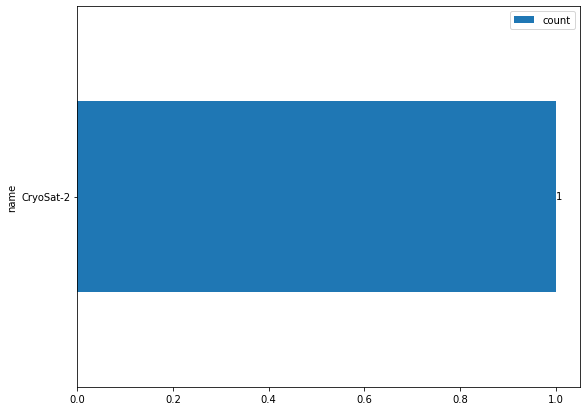

In [262]:
df = load_facet(root, "eo:platform")
ax = df.plot(kind='barh', figsize=(9, 7))
ax.bar_label(ax.containers[0])
ax

**Example: 6.10**  
>  Convert `<sru:facetedResults>` facet information for 'eo:instrument' to a dataframe and display as a bar chart.

<AxesSubplot:ylabel='name'>

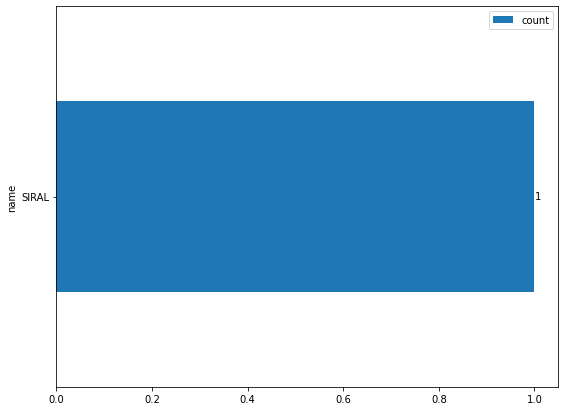

In [263]:
df = load_facet(root, "eo:instrument")
ax = df.plot(kind='barh', figsize=(9, 7))
ax.bar_label(ax.containers[0])
ax


**Example: 6.11**  
>  Convert `<sru:facetedResults>` facet information for 'eo:organizationName' to a dataframe and display as a bar chart.

<AxesSubplot:ylabel='name'>

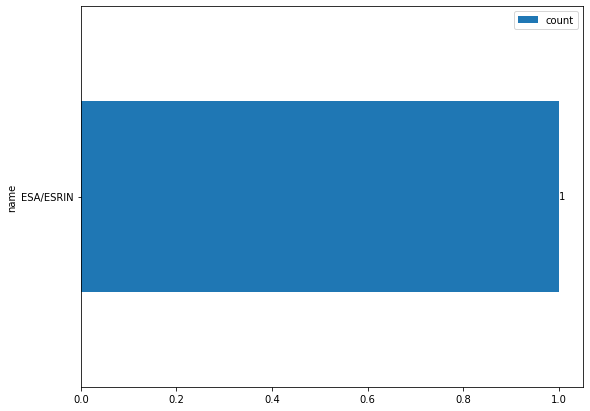

In [264]:
df = load_facet(root, "eo:organisationName")
ax = df.plot(kind='barh', figsize=(9,7))
ax.bar_label(ax.containers[0])
ax

**Example: 6.12**  
>  Convert `<sru:facetedResults>` facet information for 'eo:prcessingLevel' to a dataframe and display as a bar chart.

<AxesSubplot:ylabel='name'>

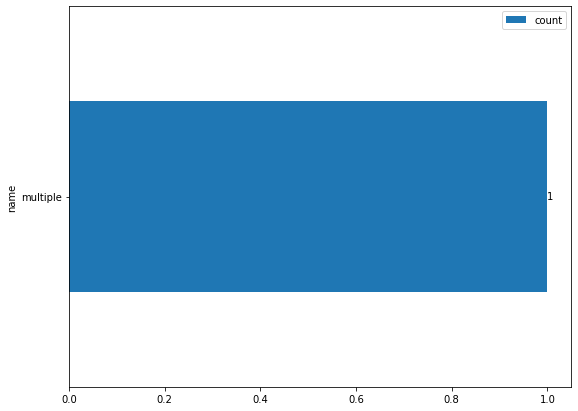

In [265]:
df = load_facet(root, "eo:processingLevel")
ax = df.plot(kind='barh', figsize=(9,7))
ax.bar_label(ax.containers[0])
ax

### Content negotiation

The API provides the `httpAccept` HTTP query parameter to request for different media types which has the same behaviour as the [searchRetrieve httpAccept parameter](http://docs.oasis-open.org/search-ws/searchRetrieve/v1.0/os/part3-sru2.0/searchRetrieve-v1.0-os-part3-sru2.0.html#_Toc324162475) in [[RD7]](#RD7).  When using the OpenSearch interface, this parameter is prefilled with the media type selected when
the URL template was extracted from the OSDD](#selecting-mediatype-in-osdd).  Future versions of the API will allow to use the HTTP header parameter `Accept` to provide the media type when the API is accessed directly without passing via the OSDD.  In case both parameters are provided, the `httpAccept` parameter has precedence.  

<a name='Further-Reading'></a>  
## Further Reading

| **ID**  | **Title** | 
| -------- | --------- | 
| `RD1` <a name="RD1"></a> | [CEOS OpenSearch Best Practice Document, Version 1.3](https://github.com/radiantearth/stac-spec/blob/master/catalog-spec/catalog-spec.md) | 
| `RD2` <a name="RD2"></a> | [OGC 10-032r8 - OpenSearch Geo and Time Extensions ](https://portal.ogc.org/files/?artifact_id=56866) | 
| `RD3` <a name="RD3"></a> | [OGC 13-026r9 - OpenSearch Extension for Earth Observation](http://docs.opengeospatial.org/is/13-026r9/13-026r9.html) | 
| `RD4` <a name="RD4"></a> | [RFC 4287 - The Atom Syndication Format](https://datatracker.ietf.org/doc/html/rfc4287) | 
| `RD5` <a name="RD5"></a> | [WGISS CDA OpenSearch Client Guide](https://ceos.org/document_management/Working_Groups/WGISS/Documents/Discovery-Access/WGISS%20CDA%20OpenSearch%20Client%20Guide-v1.2.pdf) | 
| `RD6` <a name="RD6"></a>| [OASIS searchRetrieve: Part 7. Explain Version 1.0](http://docs.oasis-open.org/search-ws/searchRetrieve/v1.0/os/part7-explain/searchRetrieve-v1.0-os-part7-explain.html) |
| `RD7` <a name="RD7"></a>| [OASIS searchRetrieve: Part 3. APD Binding for SRU 2.0 Version 1.0](http://docs.oasis-open.org/search-ws/searchRetrieve/v1.0/os/part3-sru2.0/searchRetrieve-v1.0-os-part3-sru2.0.html) |
| `RD8` <a name="RD8"></a>| [OpenSearch SRU Extension](https://github.com/dewitt/opensearch/tree/master/mediawiki/Community/Proposal/Specifications/OpenSearch/Extensions/SRU/1.0) |
| `RD9` <a name="RD9"></a>| [OpenSearch Semantic Extension](https://github.com/dewitt/opensearch/tree/master/mediawiki/Community/Proposal/Specifications/OpenSearch/Extensions/Semantic/1.0) |
| `RD10` <a name="RD10"></a>| [OGC 08-167r2 - Semantic annotations in OGC standards](https://portal.ogc.org/files/?artifact_id=47857) |